In [5]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)
library(reshape2)
library(tidyverse)
load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"

set.seed(12345)



here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Loading required package: Rcpp

── Attaching packages ────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

ℹ Loading Socrates

Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'Bioc

In [6]:

library(randomcoloR)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)

In [7]:
# bed <- system.file("extdata", "test.tn5.bed.gz", package = "Socrates")
#ann <- system.file("extdata", "gencode.v19.annotation.gff3.gz", package = "Socrates")
#chr <- system.file("extdata", "hg19.txt", package = "Socrates")

reference_genome_path <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/"

sb_leaf_rep_1 <- paste0(analysis_path, "Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed")

# set-up arguments

#ann <- "Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.nuclear.gff3"
#chr <- "Zm-B73-REFERENCE-NAM-5.0.chrom.size"
#pre <- "Sb.Leaf_rep1"
#output <- as.character(args[5])

ann <- paste0(reference_genome_path,"Sbicolorv5.1.primaryTrs.gff3")
chr <- paste0(reference_genome_path,"Sorghum_bicolor_var_BTx623.chrom.size")
pre <- "Sb.Leaf_merged_reps"



#Load Object
Sb.subcluster <- loadBEDandGenomeData(sb_leaf_rep_1, ann, chr)
#zea_m.rep.peaks  <- paste0(pre, "macs2_temp", sep=".")

Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC.merged.unique.tn5.sorted.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.primaryTrs.gff3 ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.chrom.size ... ok

Macs2 is installed .... ok

 - loading data (this may take a while for big BED files) ...

 - finished loading data



In [8]:

marker_list_sb_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/markers/Sb.leaf_markers_from_zm.markers.txt"
marker_list_sb <- read_delim(marker_list_sb_file, delim='\t', 
                                       col_names = TRUE)

Rows: 151 Columns: 7
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chr, geneID, name, type, tissue
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
loaded_socrates_data <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.annotation_V3t.LC_results.rds")

In [40]:
colnames(loaded_socrates_data$Clusters)

[1] "cellID"          "total"           "tss"             "acrs"           
 [5] "ptmt"            "nSites"          "log10nSites"     "sampleID"       
 [9] "umap1"           "umap2"           "doubletscore"    "d.type"         
[13] "LouvainClusters"

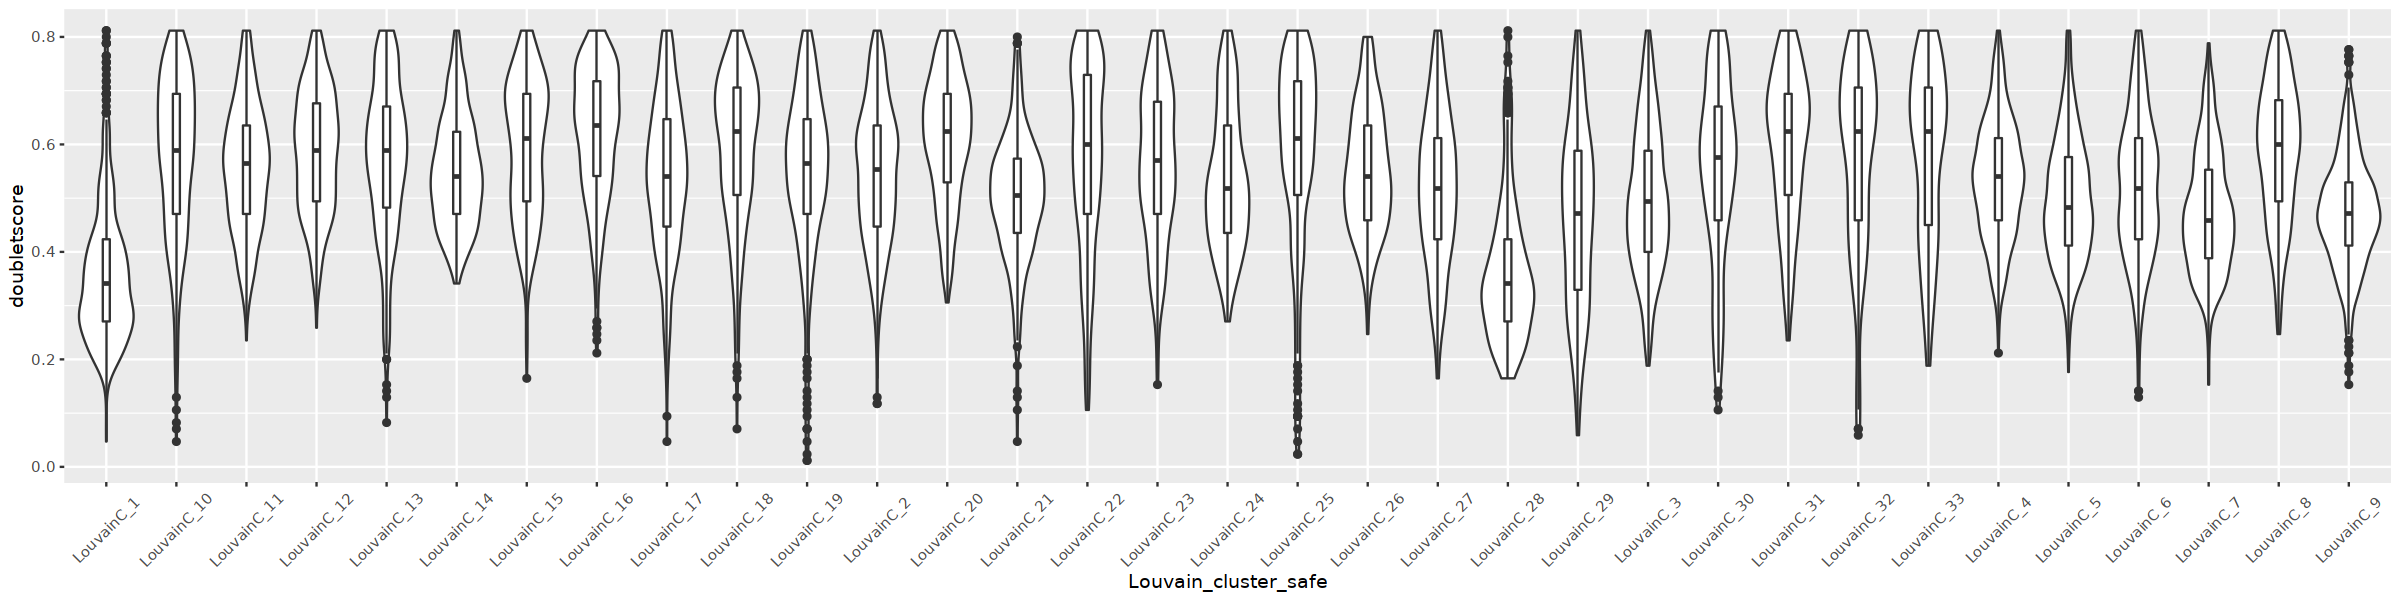

In [37]:

loaded_socrates_data$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))  %>% 
    ggplot(., aes(x = Louvain_cluster_safe, y = doubletscore)) + geom_violin() +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5)) + geom_boxplot(width=0.1)

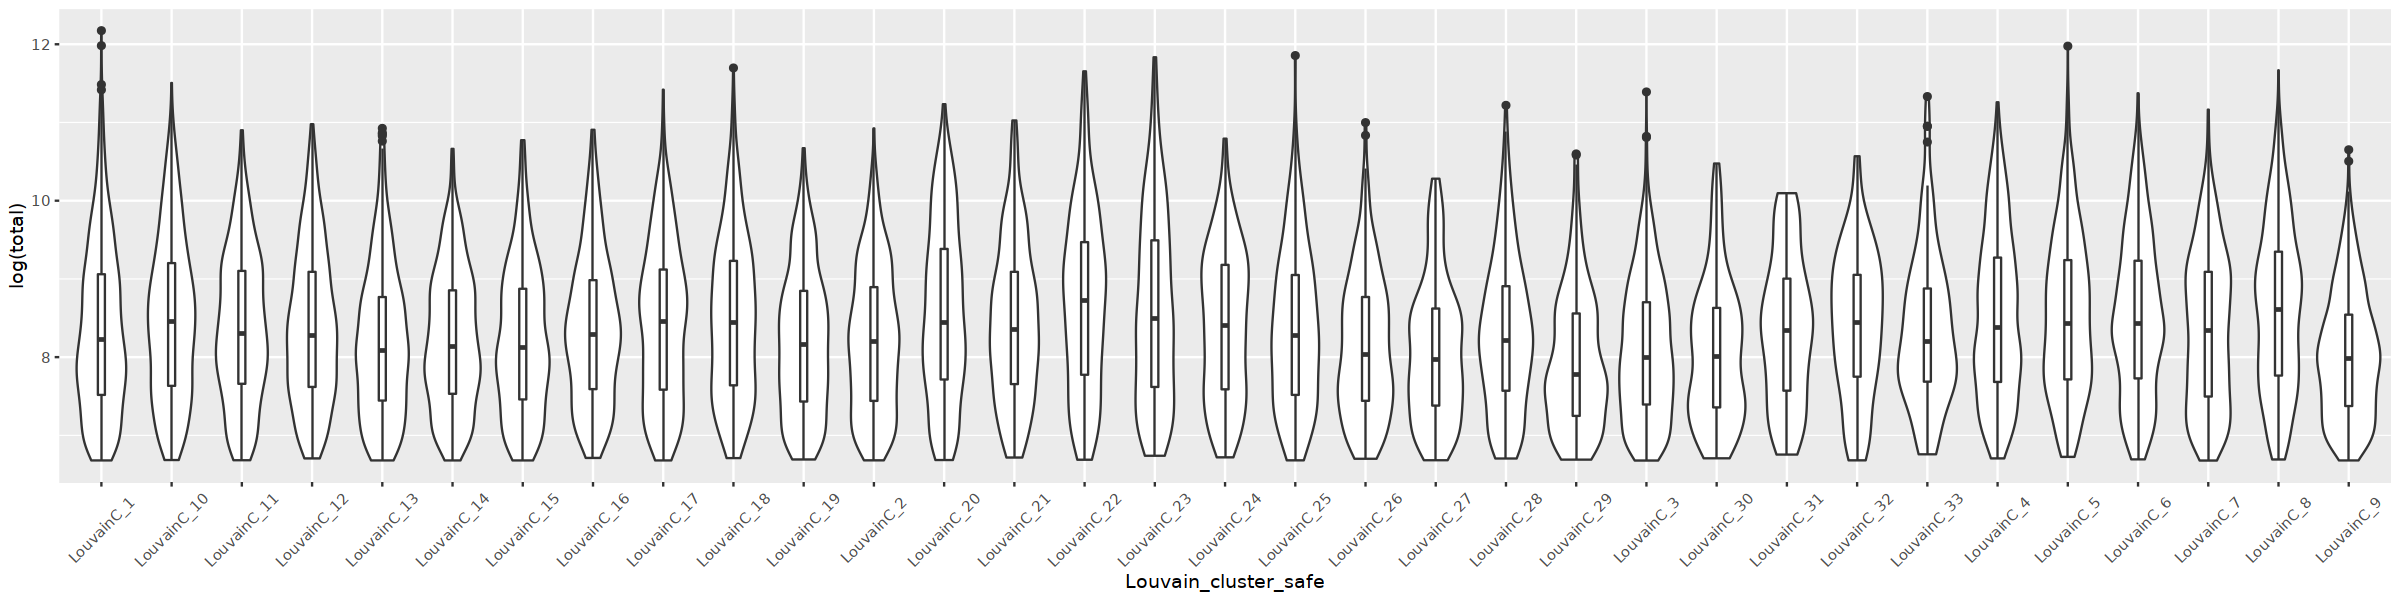

In [36]:

loaded_socrates_data$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))  %>% 
    ggplot(., aes(x = Louvain_cluster_safe, y = log(total))) + geom_violin() +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5)) + geom_boxplot(width=0.1)

In [10]:

sb.loaded_socrates_data.epidermal <- loaded_socrates_data
cleaned_cluster_meta <- sb.loaded_socrates_data.epidermal$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))
    
sb.loaded_socrates_data.epidermal$Clusters <- cleaned_cluster_meta

## SubClustering Epidermal Lineages:
"LouvainC_2", "LouvainC_12", "LouvainC_20", 
"LouvainC_4", "LouvainC_6", "LouvainC_18",
"LouvainC_15", "LouvainC_1"

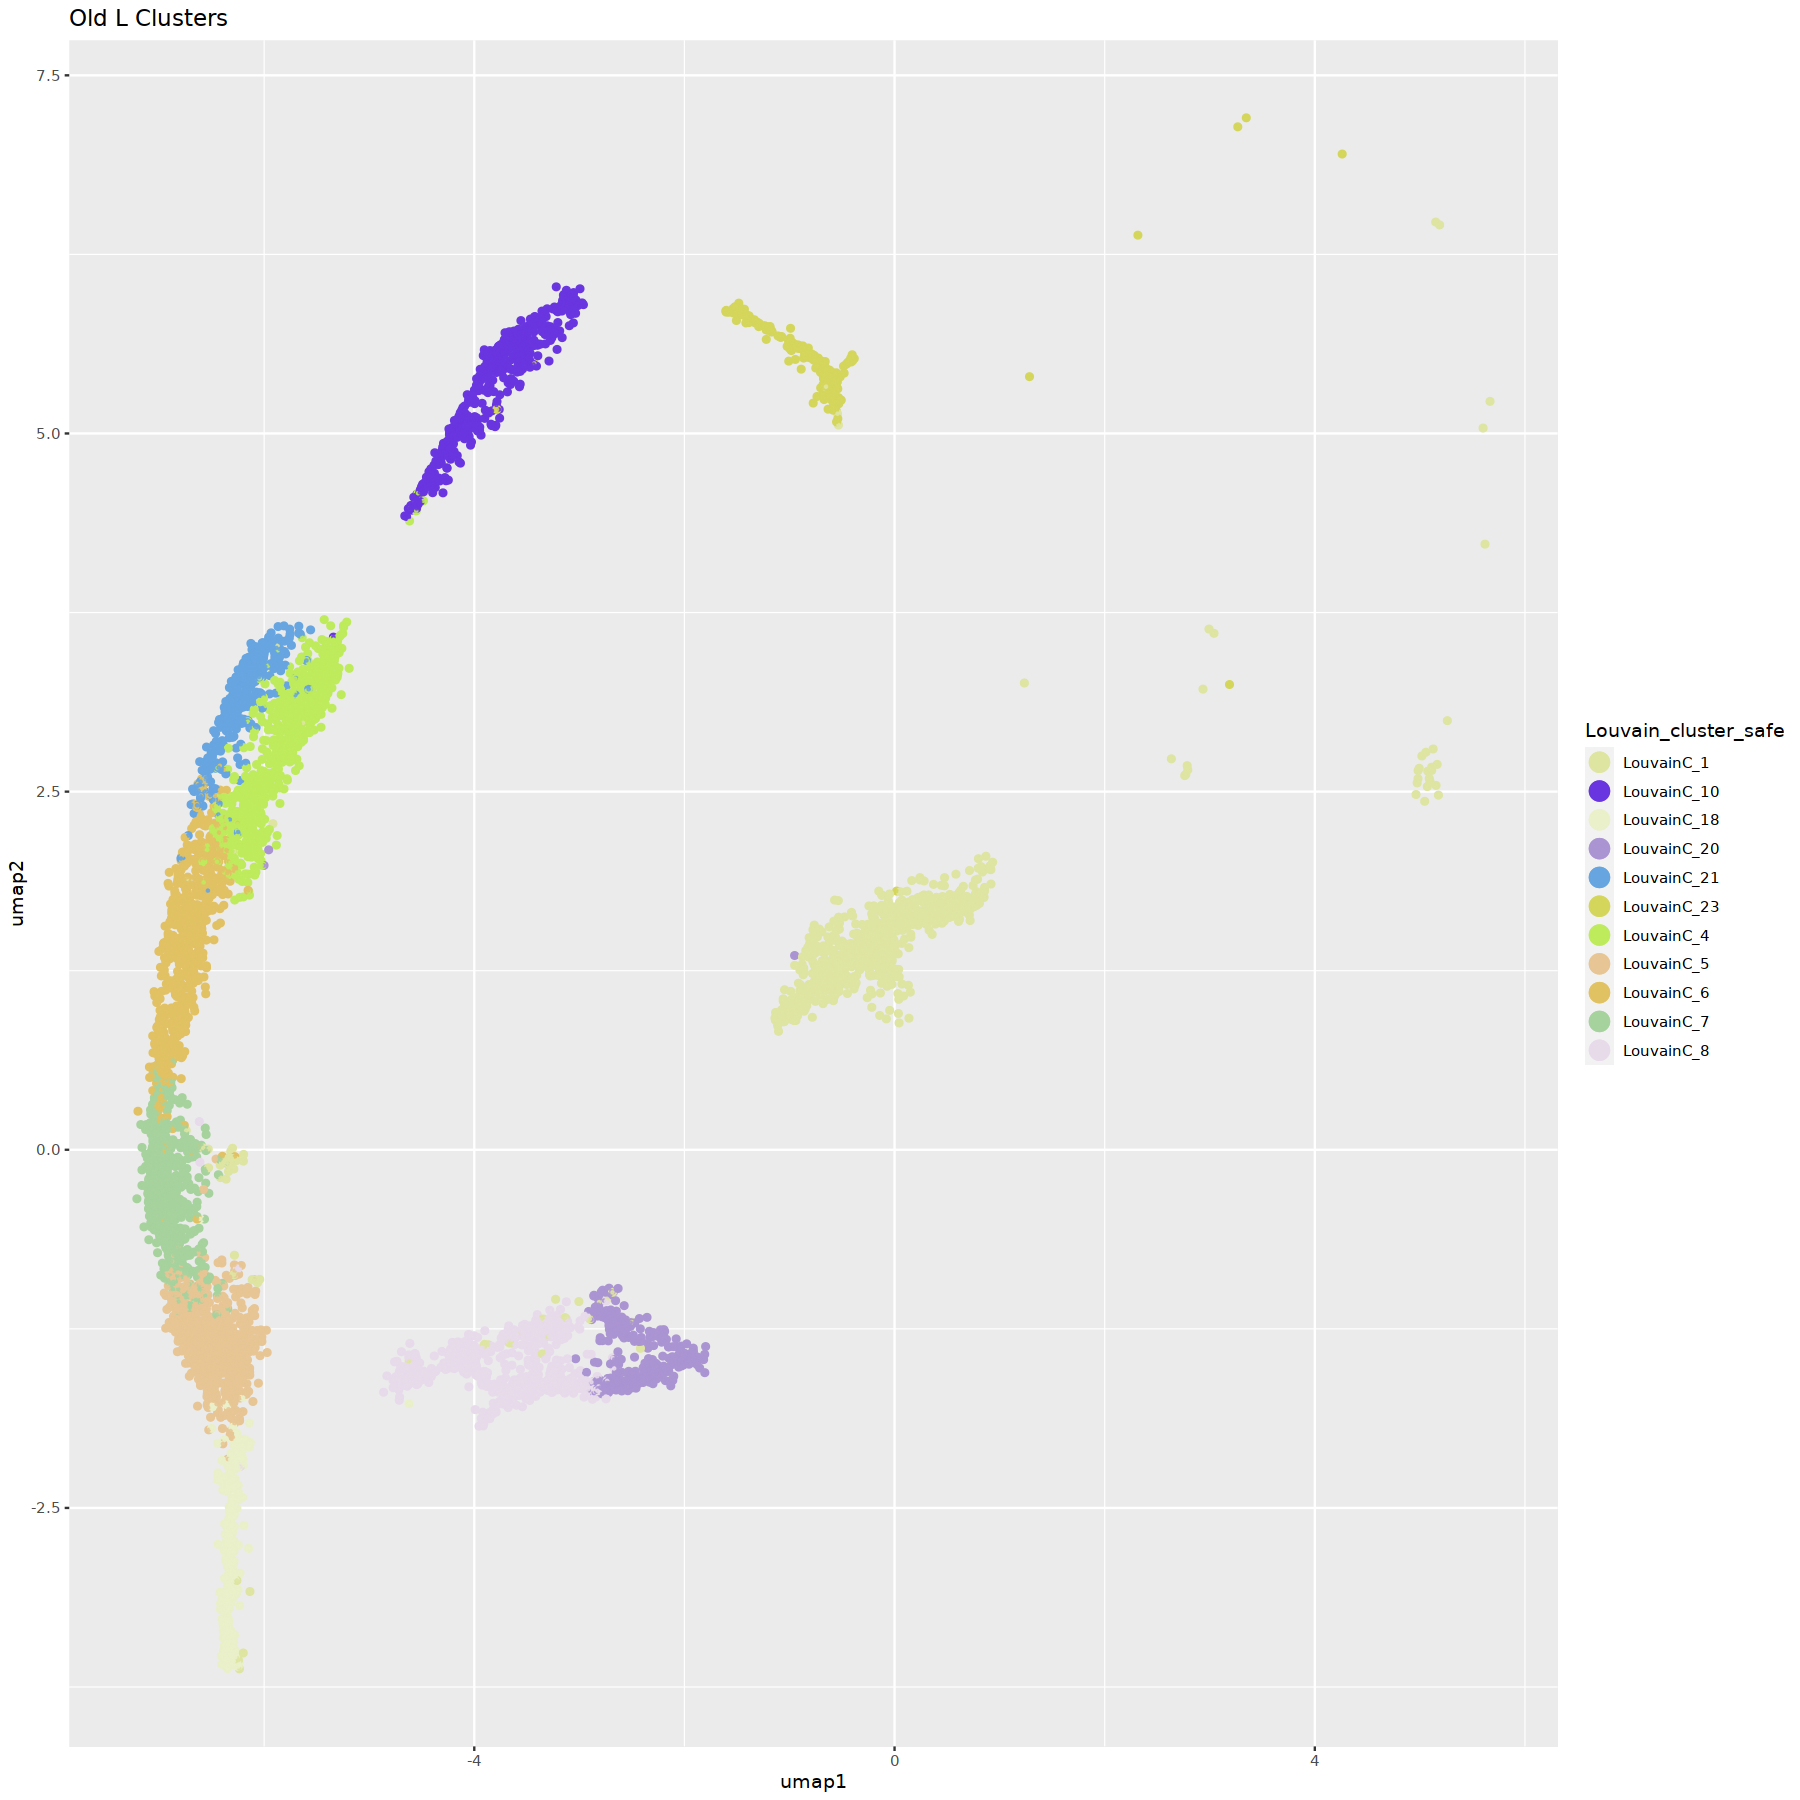

In [7]:
library(cowplot)
library(randomcoloR)
options(repr.plot.width=15, repr.plot.height=15)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)


Sb.subcluster.epidermal <- Sb.subcluster

clusters <- c("LouvainC_18","LouvainC_5","LouvainC_7","LouvainC_6","LouvainC_1",
  "LouvainC_4","LouvainC_21","LouvainC_8","LouvainC_20","LouvainC_23",
  "LouvainC_10")

#c("LouvainC_18","LouvainC_5","LouvainC_7","LouvainC_32",
#  "LouvainC_24","LouvainC_21","LouvainC_8","LouvainC_20","LouvainC_23")

sb.loaded_socrates_data.epidermal$Clusters  %>% 
    filter(Louvain_cluster_safe %in% clusters) %>% 
    group_by(Louvain_cluster_safe) %>% 
    ggplot(., aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

chosen_subcluster <- sb.loaded_socrates_data.epidermal$Clusters %>% 
    filter(Louvain_cluster_safe %in% clusters)

meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- meta_df$cellID
Sb.subcluster.epidermal$meta <- meta_df
Sb.subcluster.epidermal$meta.v3 <- meta_df

In [8]:
Sb.subcluster.epidermal <- generateMatrix(Sb.subcluster.epidermal, 
                                              filtered=FALSE,
                                              peaks = FALSE,
                                              verbose=TRUE)

In [9]:
Sb.subcluster.epidermal <- convertSparseData(Sb.subcluster.epidermal, verbose = TRUE)

 - converting triplet format to sparseMatrix



In [10]:
# clean sparse counts matrix ---------------------------------------------
Sb.subcluster.epidermal.clean <- cleanData(Sb.subcluster.epidermal, 
                     min.t=0.005,  # minimum feature frequency across cells
                     #max.t=0.1, # maximum feature frequency across cells
                     verbose=T)


   * Input: cells = 6311 | peaks = 694096

   * Filtered: cells = 6311 | peaks = 91228



In [15]:
Sb.subcluster.epidermal.clean$meta  %>% 
#    group_by(Louvain_cluster_safe)  %>% 
    summarise(n())
    

n() 
1 6311

In [12]:
# normalize with TFIDF ---------------------------------------------------
Sb.subcluster.epidermal.tfidf <- tfidf(Sb.subcluster.epidermal.clean)

In [13]:
# project with NMF -------------------------------------------------------
Sb.subcluster.epidermal.tfidf <- reduceDims(Sb.subcluster.epidermal.tfidf,
                      method="SVD", 
                      n.pcs=50, 
                      svd_slotName="SVD")

In [17]:
str(Sb.subcluster.epidermal.tfidf)

List of 10
 $ counts     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:20132561] 7 9 13 14 15 16 17 18 21 22 ...
  .. ..@ p       : int [1:6312] 0 40940 62550 96687 117847 144655 172170 198491 223495 246368 ...
  .. ..@ Dim     : int [1:2] 91228 6311
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:91228] "Chr01_10000001_10001000" "Chr01_100001_101000" "Chr01_10001001_10002000" "Chr01_10007001_10008000" ...
  .. .. ..$ : chr [1:6311] "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:TTAGGCAGTCAAAAACACGTACGTCGG-Sorghum_leaf.sciATAC_rep1" "BC:Z:ACAGTGCCGTCCCTAAGGTAGAGAGCT-Sorghum_leaf.sciATAC_rep1" ...
  .. ..@ x       : num [1:20132561] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ meta       :'data.frame':	6311 obs. of  14 variables:
  ..$ cellID              : chr [1:6311] "BC:Z:GCCAATATGTCACTAAGGGTAGCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:CGATGTAGTCAACTAAGATTCCTAC

 - non-linear dimensionality reduction with UMAP ...

10:55:59 UMAP embedding parameters a = 1.577 b = 0.8951

10:55:59 Read 6311 rows and found 49 numeric columns

10:55:59 Using Annoy for neighbor search, n_neighbors = 30

10:55:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:56:00 Writing NN index file to temp file /tmp/RtmpD4LrJj/file3a81252f2f2b8

10:56:00 Searching Annoy index using 16 threads, search_k = 3000

10:56:00 Annoy recall = 100%

10:56:04 Commencing smooth kNN distance calibration using 16 threads

10:56:07 Initializing from normalized Laplacian + noise

10:56:07 Commencing optimization for 500 epochs, with 314644 positive edges

10:56:36 Optimization finished



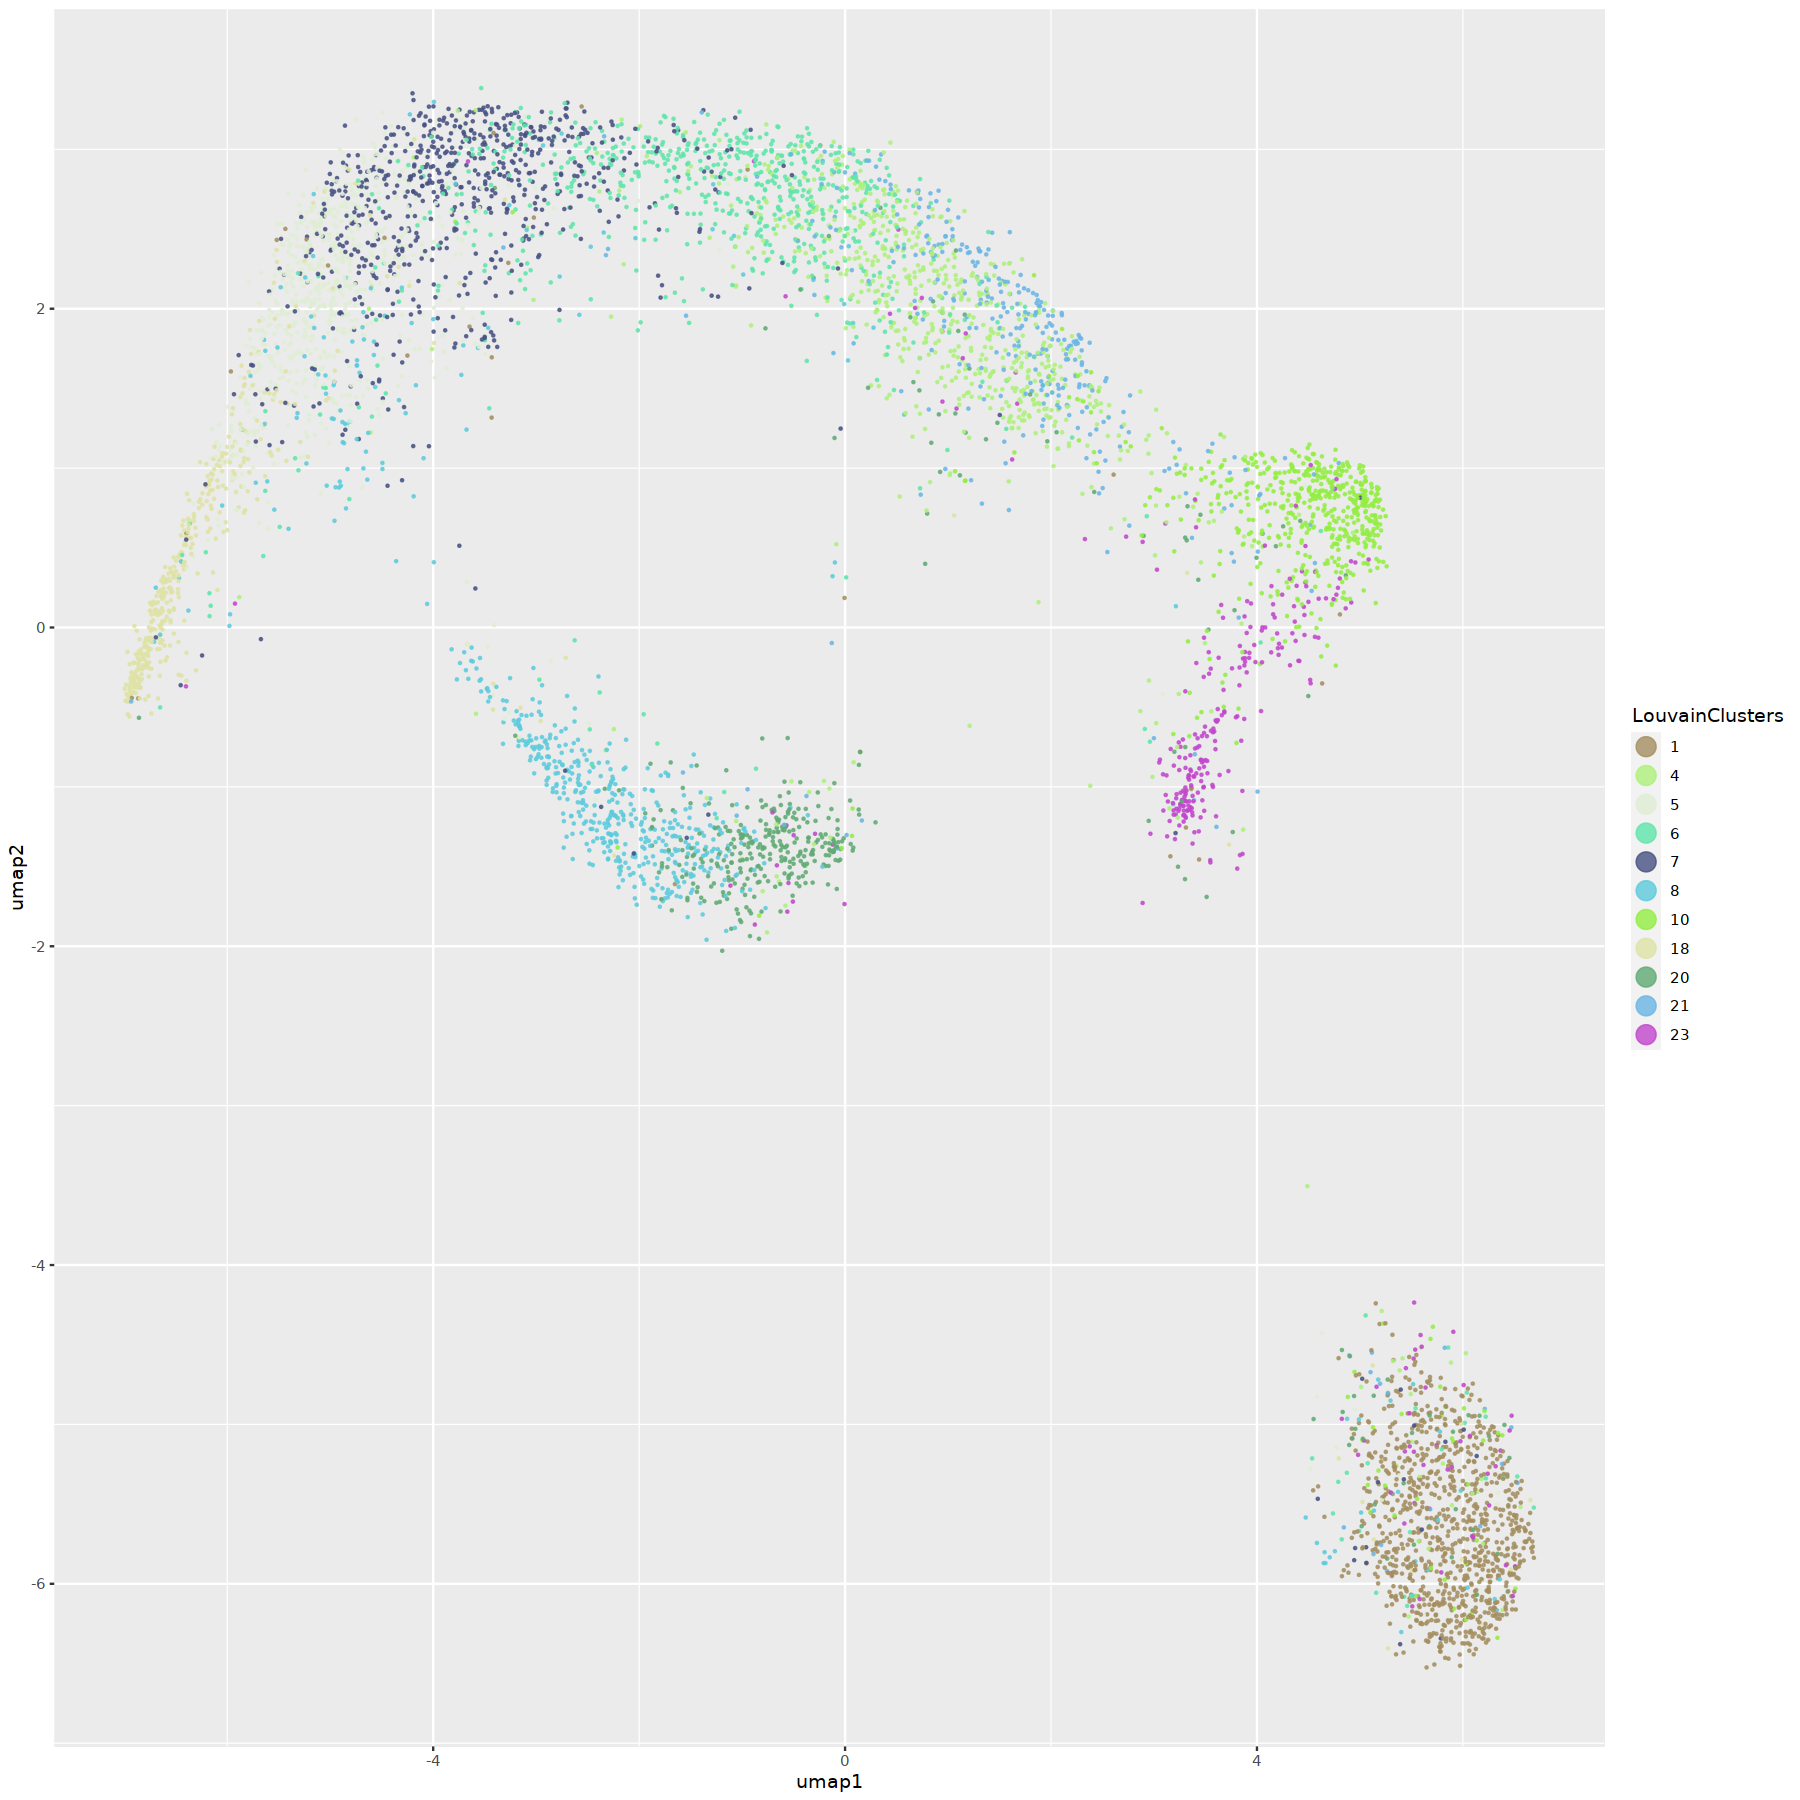

In [14]:
# reduce to 2-dimensions with UMAP ---------------------------------------
Sb.subcluster.epidermal.tfidf <- projectUMAP(Sb.subcluster.epidermal.tfidf, 
                       verbose=T,
                       k.near=30,
                       m.dist=0.1,
                       svd_slotName="SVD")

library(randomcoloR)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)

ggplot(Sb.subcluster.epidermal.tfidf$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

In [36]:
# identify clusters using neighborhood graph -----------------------------
Sb.subcluster.epidermal.tfidf.clusters <- callClusters(Sb.subcluster.epidermal.tfidf, 
                        res=3,
                        k.near = 20,
                        #min.reads=1000,
                        verbose=T,
                        min.reads=1,
                        m.clst=1,
                        e.thresh = 20,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
                        cleanCluster=F)


 - filtering outliers in UMAP manifold (z-score e.thresh = 20) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6311
Number of edges: 358921

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.5973
Number of communities: 19
Elapsed time: 7 seconds


4 singletons identified. 15 final clusters.

 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



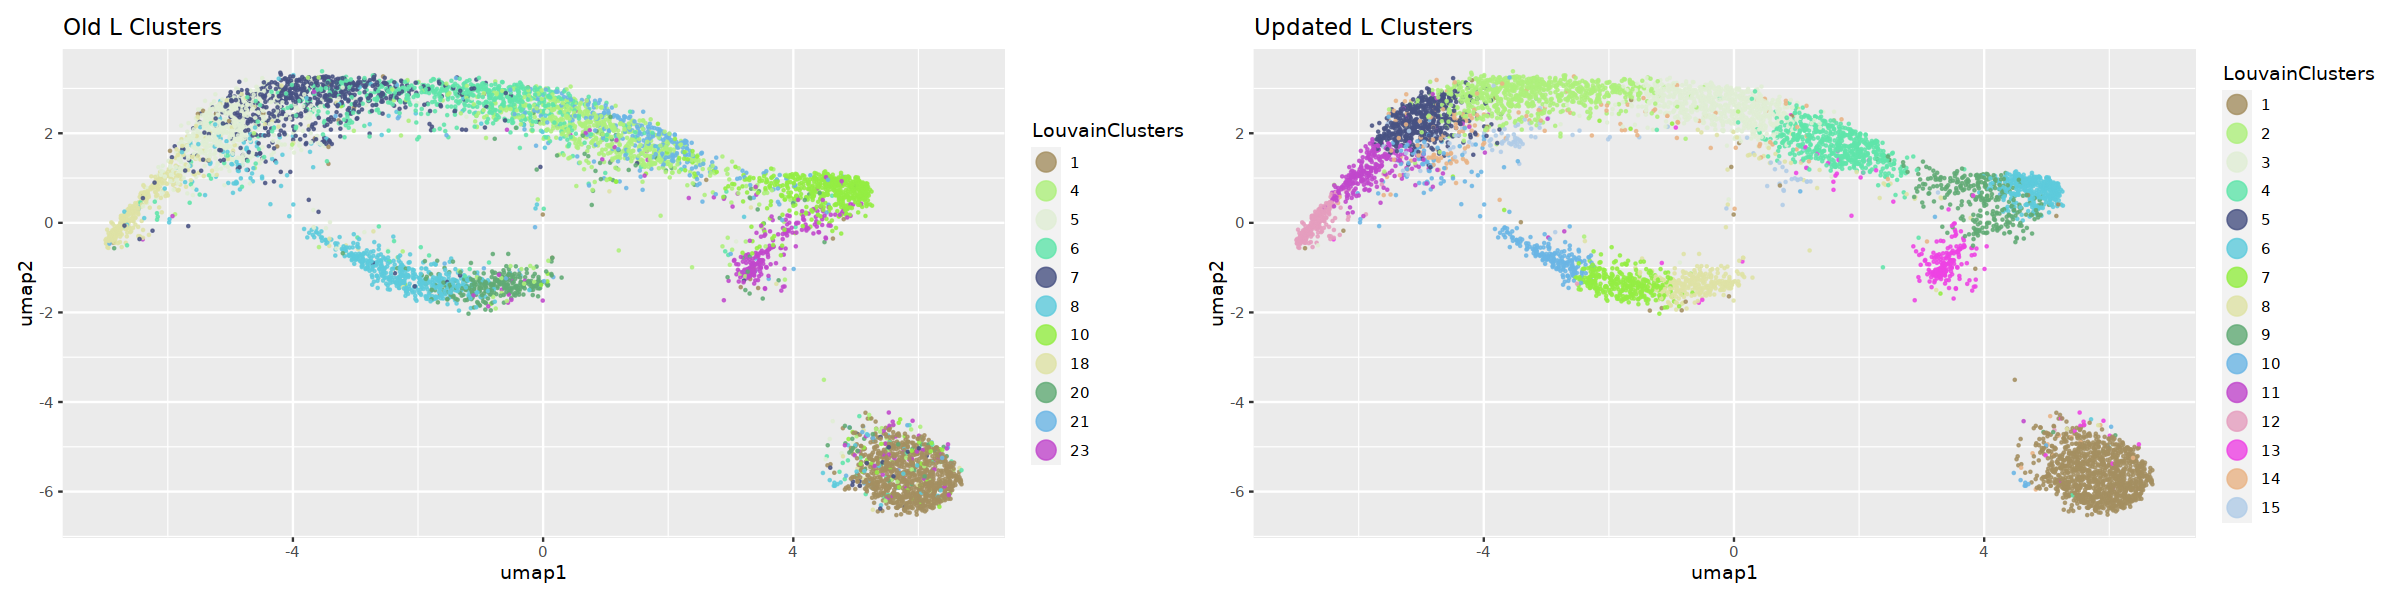

In [45]:
options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(Sb.subcluster.epidermal.tfidf.clusters$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(Sb.subcluster.epidermal.tfidf.clusters$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")


old_clusters + new_clusters 

In [48]:
Sb.subcluster.epidermal.tfidf.clusters$sub_cluster  %>% 
    group_by(LouvainClusters)  %>% 
    summarise(n())

LouvainClusters n() 
1  1               1127
2  2                749
3  3                727
4  4                546
5  5                533
6  6                367
7  7                338
8  8                317
9  9                289
10 10               289
11 11               274
12 12               261
13 13               220
14 14               174
15 15               100

In [25]:
library("presto")
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}


In [39]:
setwd("/scratch/jpm73279/comparative_single_cell/dev_location")
Sb.subcluster.epidermal.tfidf.clusters$all_genes <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.gene.bed"
#bed_intersections <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm.all_mergeed_repds.unique.mpq10.tn5.sorted.bed"
genome_file <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.mainGenome.MtPt.fasta.fai"

In [40]:
### Kernal Corrupted to just linked to the previosly run gene body accessability calculations
tfidf.obj.dob.filt.clusters.counts <- Sb.subcluster.epidermal.tfidf.clusters
tfidf.obj.dob.filt.clusters.counts$acr_counts_raw <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.gene_counts.output"

In [41]:
## Execute Annotation Attempt #1

library(presto)
Sb.subcluster.tfidf.clusters.final <- run_presto(tfidf.obj.dob.filt.clusters.counts,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 × 14
  cellID     total    tss   acrs  ptmt nSites log10nSites sampleID umap1   umap2
  <chr>      <dbl>  <dbl>  <dbl> <dbl>  <dbl>       <dbl> <chr>    <dbl>   <dbl>
1 BC:Z:GCC… 193716 115473 154235     0  47166        4.67 rep1      4.81  0.0822
2 BC:Z:CGA… 159908  50092  29336     0  69127        4.84 rep1      6.42 -6.19  
3 BC:Z:TTA… 137820  80881  99700     0  40325        4.61 rep1      3.35 -1.14  
4 BC:Z:ACA… 116704  44610  44540     0  48813        4.69 rep1      6.43 -6.05  
5 BC:Z:ACA…  99224  62412  83029     0  29116        4.46 rep1      5.08  0.397 
6 BC:Z:ACA…  98568  56617  71027     0  32074        4.51 rep1      3.25 -1.24  
# … with 4 more variables: doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, Louvain_cluster_safe <chr>
# A tibble: 6 × 3
  gene_name        barcode                                         accessability
  <chr>            <chr>                                                   <dbl>
1 Sobic.001G125600 BC:Z:ACAGTGCTTGTATG

In [42]:
grabbed_top_marker_per_cluster <- top_markers(Sb.subcluster.tfidf.clusters.final$presto_marker, 200)


In [43]:
represented_marker_lst <- list()
for (i in unique(Sb.subcluster.tfidf.clusters.final$sub_cluster$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
                                           marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(i)` instead of `i` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


$`9`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

$`1`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

$`13`
# A tibble: 2 × 8
   rank geneID                      chr      start      end name  type    tissue
  <int> <chr>                       <chr>    <dbl>    <dbl> <chr> <chr>   <chr> 
1     5 Sorbiv5.1_pg9159.m1.g       Chr06 41574374 41588764 ba2   axilla… axill…
2    26 Sorbiv5.1_pg5044.valid.m7.g Chr01 66616555 66619678 bk1   vascul… axill…

$`6`
# A tibble: 4 × 8
   rank geneID                       chr      start      end name  type   tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr> <chr>  <chr> 
1    58 Sobic.001G221900             Chr01 21229983 21235639 ad1   proto… axill…
2    71 Sobic.001G499200             Chr01 81035681 81040362 nod   stoma… axill…
3    83 Sorbiv5.1_pg14938.valid.m7.g Chr03  8560607  8567782 ocl1  proto… axill…
4   119 Sobic.002G032500             Chr02  3002965  3011531 pan2  subsi… axill…

$`3`
# A tibble: 2 × 8
   rank geneID                chr      start      end name  type          tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr> <chr>         <chr> 
1     6 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2   axillary_mer… axill…
2    33 Sobic.002G207900      Chr02 61233338 61239219 gl1   epidermis     axill…

$`11`
# A tibble: 1 × 8
   rank geneID                 chr     start     end name           type  tissue
  <int> <chr>                  <chr>   <dbl>   <dbl> <chr>          <chr> <chr> 
1    93 Sorbiv5.1_pg15531.m1.g Chr03 3341071 3347117 me3_ortho_cou… bund… axill…

$`8`
# A tibble: 4 × 8
   rank geneID                chr      start      end name  type          tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr> <chr>         <chr> 
1    24 Sobic.001G075101      Chr01  5763796  5774227 knox8 SAM,ground_m… axill…
2    59 Sobic.007G141200      Chr07 60395810 60403219 ccr1  vascular_scl… axill…
3    66 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2   axillary_mer… axill…
4   158 Sobic.004G167500      Chr04 54235401 54236447 acl2  bulliform_ce… axill…

$`14`
# A tibble: 1 × 8
   rank geneID           chr     start     end name  type                 tissue
  <int> <chr>            <chr>   <dbl>   <dbl> <chr> <chr>                <chr> 
1    80 Sobic.004G058700 Chr04 4774060 4777174 ZmAPL protophloem_sieve_e… axill…

$`10`
# A tibble: 3 × 8
   rank geneID                 chr      start      end name         type  tissue
  <int> <chr>                  <chr>    <dbl>    <dbl> <chr>        <chr> <chr> 
1     9 Sobic.002G207900       Chr02 61233338 61239219 gl1          epid… axill…
2   103 Sobic.001G537300       Chr01 84195608 84203525 rld1         SAM,… axill…
3   123 Sorbiv5.1_pg15531.m1.g Chr03  3341071  3347117 me3_ortho_c… bund… axill…

$`5`
# A tibble: 2 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1     3 Sobic.002G207900 Chr02 61233338 61239219 gl1   epidermis          axill…
2   119 Sobic.001G537300 Chr01 84195608 84203525 rld1  SAM,leaf_primordi… axill…

$`4`
# A tibble: 4 × 8
   rank geneID                       chr      start      end name   type  tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr>  <chr> <chr> 
1    42 Sorbiv5.1_pg9159.m1.g        Chr06 41574374 41588764 ba2    axil… axill…
2   130 Sobic.002G343500             Chr02 72301461 72308725 ZmCPK… guar… axill…
3   144 Sobic.002G207900             Chr02 61233338 61239219 gl1    epid… axill…
4   198 Sorbiv5.1_pg31052.valid.m1.g Chr09 63154998 63156307 mute   guar… axill…

$`7`
# A tibble: 1 × 8
   rank geneID           chr     start     end name  type                 tissue
  <int> <chr>            <chr>   <dbl>   <dbl> <chr> <chr> 

In [49]:
gathered_markers <- bind_rows(represented_marker_lst, .id = "LouvainCluster")  %>% 
    arrange(LouvainCluster, rank)


write_delim(gathered_markers, 
            "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/V3_annotations/Sb_leaf.merged_replicates.Subclustering_epidermal.LouvainCluster_annot_V3.presto.V2.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

gathered_markers

LouvainCluster rank geneID                       chr   start    end     
1  10               9  Sobic.002G207900             Chr02 61233338 61239219
2  10             103  Sobic.001G537300             Chr01 84195608 84203525
3  10             123  Sorbiv5.1_pg15531.m1.g       Chr03  3341071  3347117
4  11              93  Sorbiv5.1_pg15531.m1.g       Chr03  3341071  3347117
5  12              26  Sorbiv5.1_pg15531.m1.g       Chr03  3341071  3347117
6  13               5  Sorbiv5.1_pg9159.m1.g        Chr06 41574374 41588764
7  13              26  Sorbiv5.1_pg5044.valid.m7.g  Chr01 66616555 66619678
8  14              80  Sobic.004G058700             Chr04  4774060  4777174
9  15             128  Sorbiv5.1_pg8935.valid.m1.g  Chr06 55555652 55560116
10 15             188  ta.jpa7.902.35711FPf1.g      Chr09 53791268 53794252
11 2                2  Sobic.002G207900             Chr02 61233338 61239219
12 2              154  Sobic.008G193300             Chr08 65745228 65750046
13 3                6  Sorbiv5.1_pg9159.m1.g        Chr06 41574374 41588764
14 3               33  Sobic.002G207900             Chr02 61233338 61239219
15 4               42  Sorbiv5.1_pg9159.m1.g        Chr06 41574374 41588764
16 4              130  Sobic.002G343500             Chr02 72301461 72308725
17 4              144  Sobic.002G207900             Chr02 61233338 61239219
18 4              198  Sorbiv5.1_pg31052.valid.m1.g Chr09 63154998 63156307
19 5                3  Sobic.002G207900             Chr02 61233338 61239219
20 5              119  Sobic.001G537300             Chr01 84195608 84203525
21 6               58  Sobic.001G221900             Chr01 21229983 21235639
22 6               71  Sobic.001G499200             Chr01 81035681 81040362
23 6               83  Sorbiv5.1_pg14938.valid.m7.g Chr03  8560607  8567782
24 6              119  Sobic.002G032500             Chr02  3002965  3011531
25 7              178  Sobic.002G083600             Chr02  8962876  8967240
26 8               24  Sobic.001G075101             Chr01  5763796  5774227
27 8               59  Sobic.007G141200             Chr07 60395810 60403219
28 8               66  Sorbiv5.1_pg9159.m1.g        Chr06 41574374 41588764
29 8              158  Sobic.004G167500             Chr04 54235401 54236447
   name             
1  gl1              
2  rld1             
3  me3_ortho_count_1
4  me3_ortho_count_1
5  me3_ortho_count_1
6  ba2              
7  bk1              
8  ZmAPL            
9  slac             
10 sweet1b          
11 gl1              
12 sut2             
13 ba2              
14 gl1              
15 ba2              
16 ZmCPK37__ZmCPK35 
17 gl1              
18 mute             
19 gl1              
20 rld1             
21 ad1              
22 nod              
23 ocl1             
24 pan2             
25 SID1             
26 knox8            
27 ccr1             
28 ba2              
29 acl2             
   type                                                                                                                                                                                                                                                                                                               
1  epidermis                                                                                                                                                                                                                                                                                                          
2  SAM,leaf_primordia,provascular_strands,protoxylem                                                                                                                                                                                                                                                                  
3  bundle_sheath                                                                                                                                                

In [28]:
represented_marker_lst

$`10`
# A tibble: 1 × 8
   rank geneID           chr     start     end name  type                 tissue
  <int> <chr>            <chr>   <dbl>   <dbl> <chr> <chr>                <chr> 
1   172 Sobic.002G032500 Chr02 3002965 3011531 pan2  subsidiary_mother_c… axill…

$`1`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

$`12`
# A tibble: 2 × 8
   rank geneID                      chr      start      end name  type    tissue
  <int> <chr>                       <chr>    <dbl>    <dbl> <chr> <chr>   <chr> 
1     5 Sorbiv5.1_pg9159.m1.g       Chr06 41574374 41588764 ba2   axilla… axill…
2    24 Sorbiv5.1_pg5044.valid.m7.g Chr01 66616555 66619678 bk1   vascul… axill…

$`8`
# A tibble: 4 × 8
   rank geneID                       chr      start      end name  type   tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr> <chr>  <chr> 
1    58 Sobic.001G221900             Chr01 21229983 21235639 ad1   proto… axill…
2    75 Sorbiv5.1_pg14938.valid.m7.g Chr03  8560607  8567782 ocl1  proto… axill…
3    80 Sobic.001G499200             Chr01 81035681 81040362 nod   stoma… axill…
4   107 Sobic.002G032500             Chr02  3002965  3011531 pan2  subsi… axill…

$`3`
# A tibble: 2 × 8
   rank geneID                chr      start      end name  type          tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr> <chr>         <chr> 
1     5 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2   axillary_mer… axill…
2    38 Sobic.002G207900      Chr02 61233338 61239219 gl1   epidermis     axill…

$`4`
# A tibble: 3 × 8
   rank geneID           chr      start      end name           type      tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr>          <chr>     <chr> 
1     1 Sobic.002G207900 Chr02 61233338 61239219 gl1            epidermis axill…
2   123 Sobic.001G537300 Chr01 84195608 84203525 rld1           SAM,leaf… axill…
3   197 Sobic.009G162000 Chr09 55658168 55661565 gpat11__gpat12 epidermi… axill…

$`7`
# A tibble: 4 × 8
   rank geneID                chr      start      end name  type          tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr> <chr>         <chr> 
1    46 Sobic.001G075101      Chr01  5763796  5774227 knox8 SAM,ground_m… axill…
2    75 Sobic.007G141200      Chr07 60395810 60403219 ccr1  vascular_scl… axill…
3    90 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2   axillary_mer… axill…
4   168 Sobic.004G167500      Chr04 54235401 54236447 acl2  bulliform_ce… axill…

$`11`
# A tibble: 1 × 8
   rank geneID                 chr     start     end name           type  tissue
  <int> <chr>                  <chr>   <dbl>   <dbl> <chr>          <chr> <chr> 
1    92 Sorbiv5.1_pg15531.m1.g Chr03 3341071 3347117 me3_ortho_cou… bund… axill…

$`2`
# A tibble: 2 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1     5 Sobic.002G207900 Chr02 61233338 61239219 gl1   epidermis          axill…
2   185 Sobic.008G193300 Chr08 65745228 65750046 sut2  companion_cells,x… axill…

$`5`
# A tibble: 4 × 8
   rank geneID                       chr      start      end name   type  tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr>  <chr> <chr> 
1    49 Sorbiv5.1_pg9159.m1.g        Chr06 41574374 41588764 ba2    axil… axill…
2   140 Sobic.002G207900             Chr02 61233338 61239219 gl1    epid… axill…
3   150 Sobic.002G343500             Chr02 72301461 72308725 ZmCPK… guar… axill…
4   199 Sorbiv5.1_pg31052.valid.m1.g Chr09 63154998 63156307 mute   guar… axill…

$`6`
# A tibble: 2 × 8
   rank geneID                 chr      start      end name         type  tissue
  <int> <chr>                  <chr>    <dbl>    <dbl> <chr>        <chr> <chr> 
1    37 Sobic.002G207900       Chr02 61233338 61239219 gl1          epid… axill…
2    94 Sorbiv5.1_pg15531.m1.g Chr03  3341071 

## Write the output for marker visualization

In [50]:

prefix <- "Sb_leaf.merged_replicates.Subclustering_epidermal.V2"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"

# output text files
nmf.meta <- Sb.subcluster.tfidf.clusters.final$sub_cluster
nmf.rd <- Sb.subcluster.tfidf.clusters.final$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


#Generate Sparse Matrix-
trip <- as.data.frame(summary(Sb.subcluster.tfidf.clusters.final$counts))
trip$i <- rownames(Sb.subcluster.tfidf.clusters.final$counts)[trip$i]
trip$j <- colnames(Sb.subcluster.tfidf.clusters.final$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")



In [51]:
saveRDS(Sb.subcluster.tfidf.clusters.final, file = paste0(output_location, prefix, ".rds"))

## SubClustering Vasculature

In [52]:

sb.loaded_socrates_data.vasculature <- loaded_socrates_data
cleaned_cluster_meta <- sb.loaded_socrates_data.vasculature$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))
    
sb.loaded_socrates_data.vasculature$Clusters <- cleaned_cluster_meta

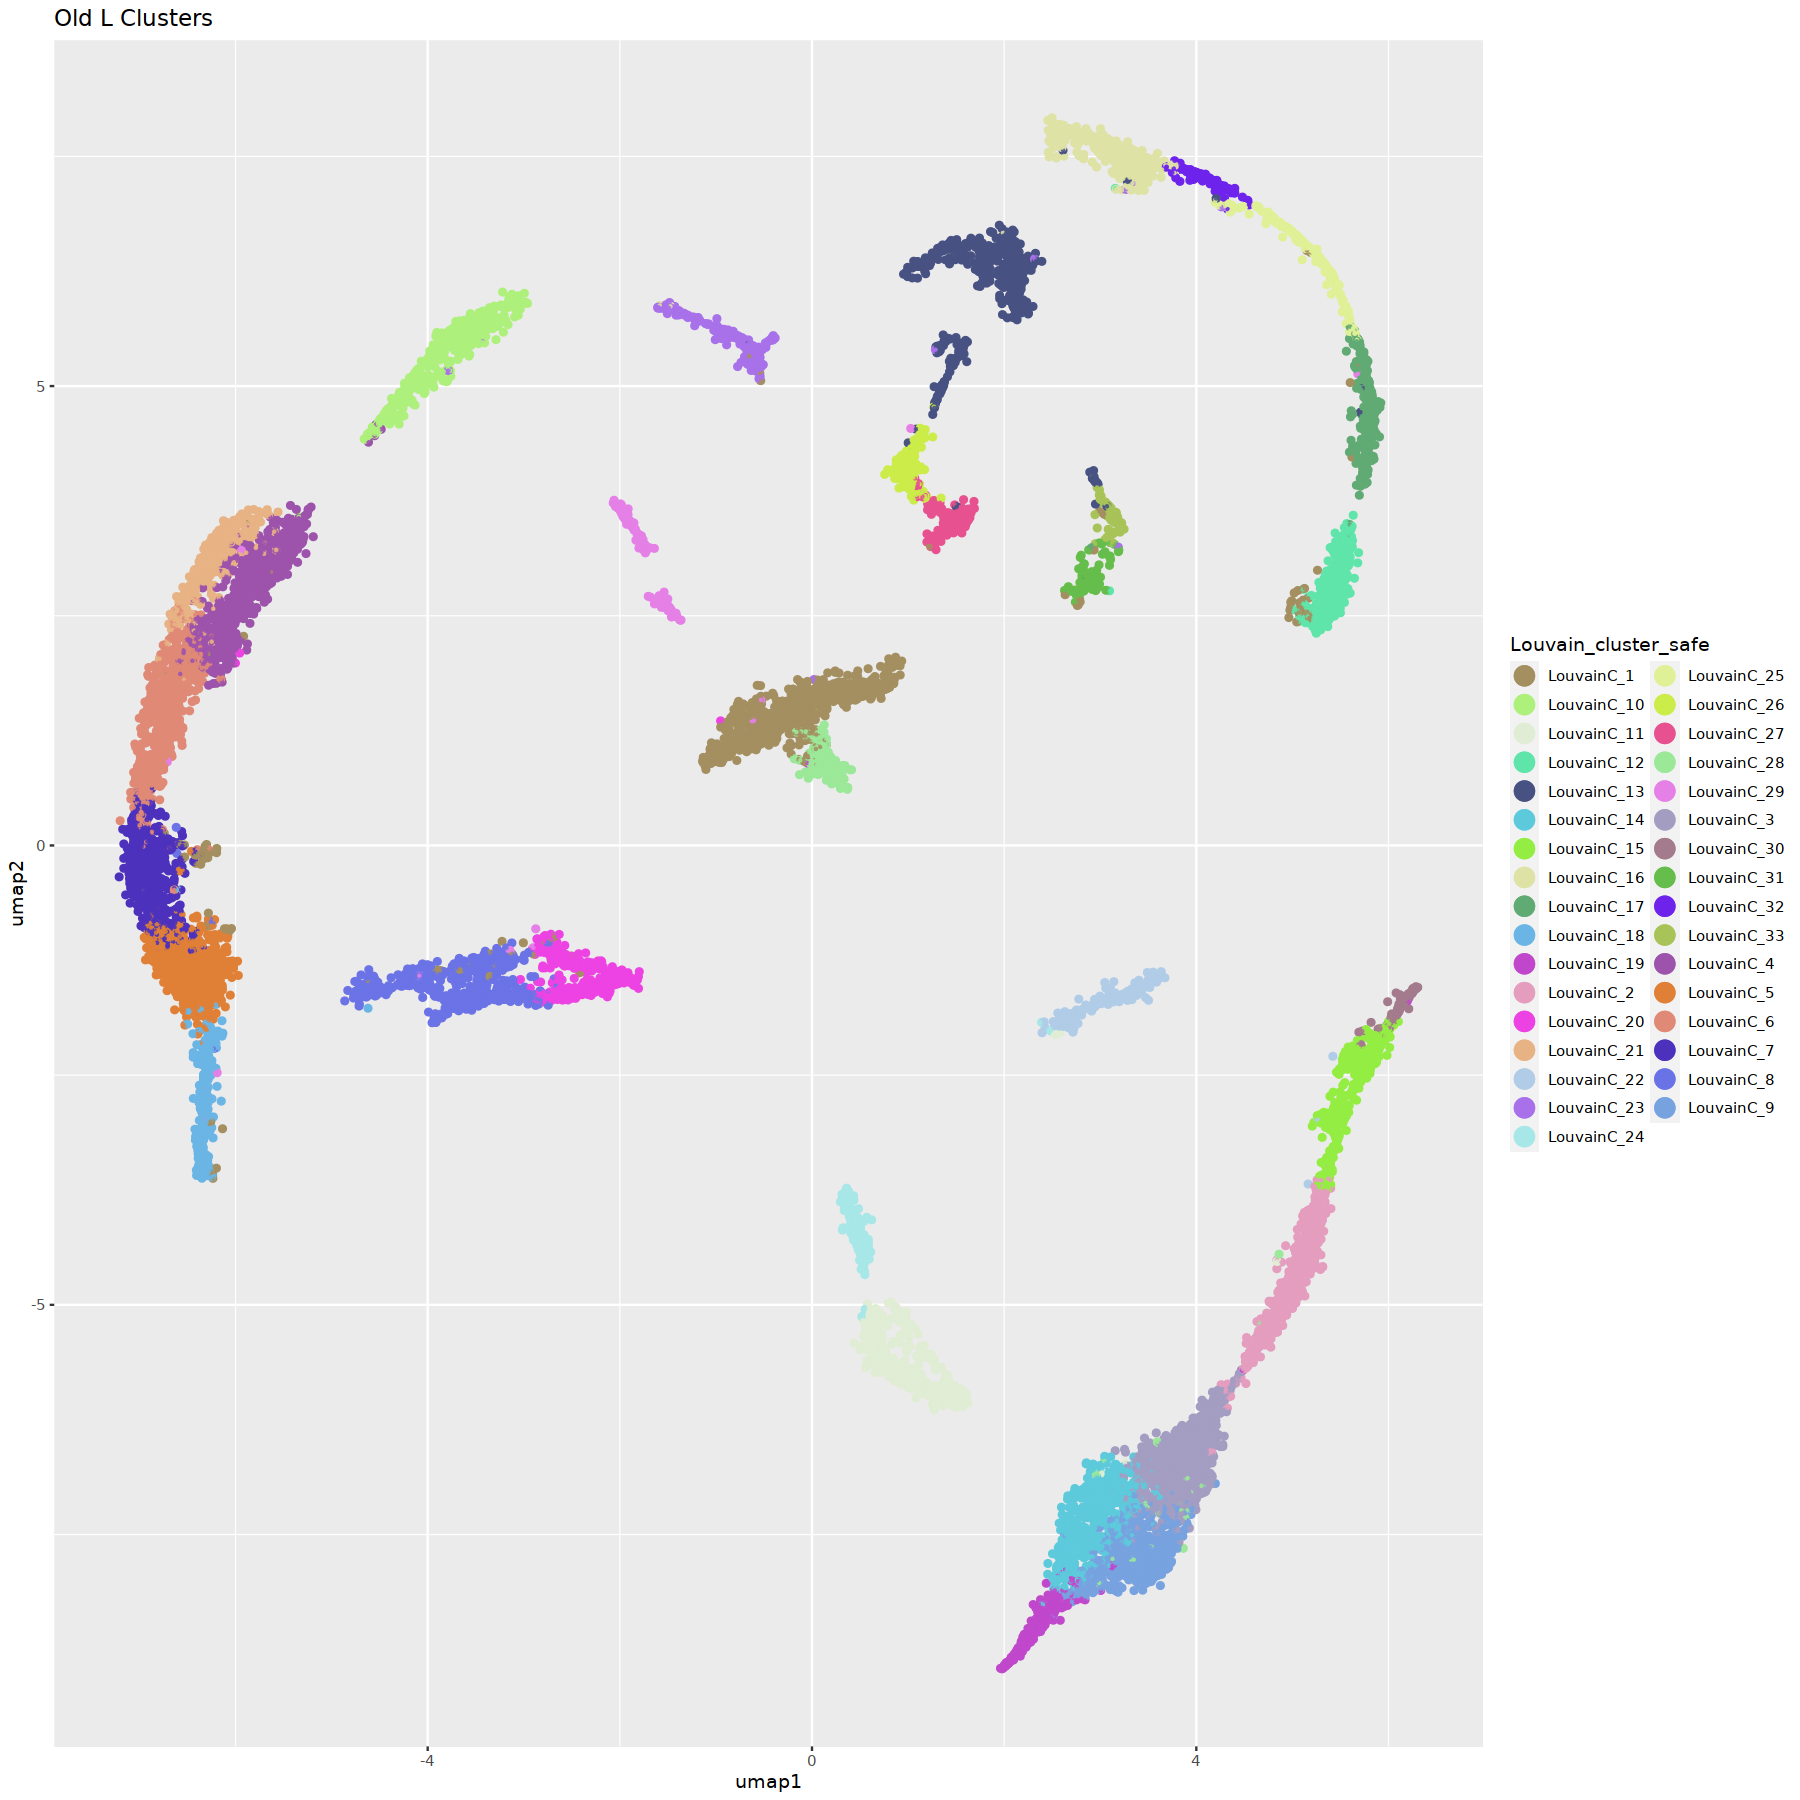

In [53]:
options(repr.plot.width=15, repr.plot.height=15)
ggplot(sb.loaded_socrates_data.vasculature$Clusters, aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

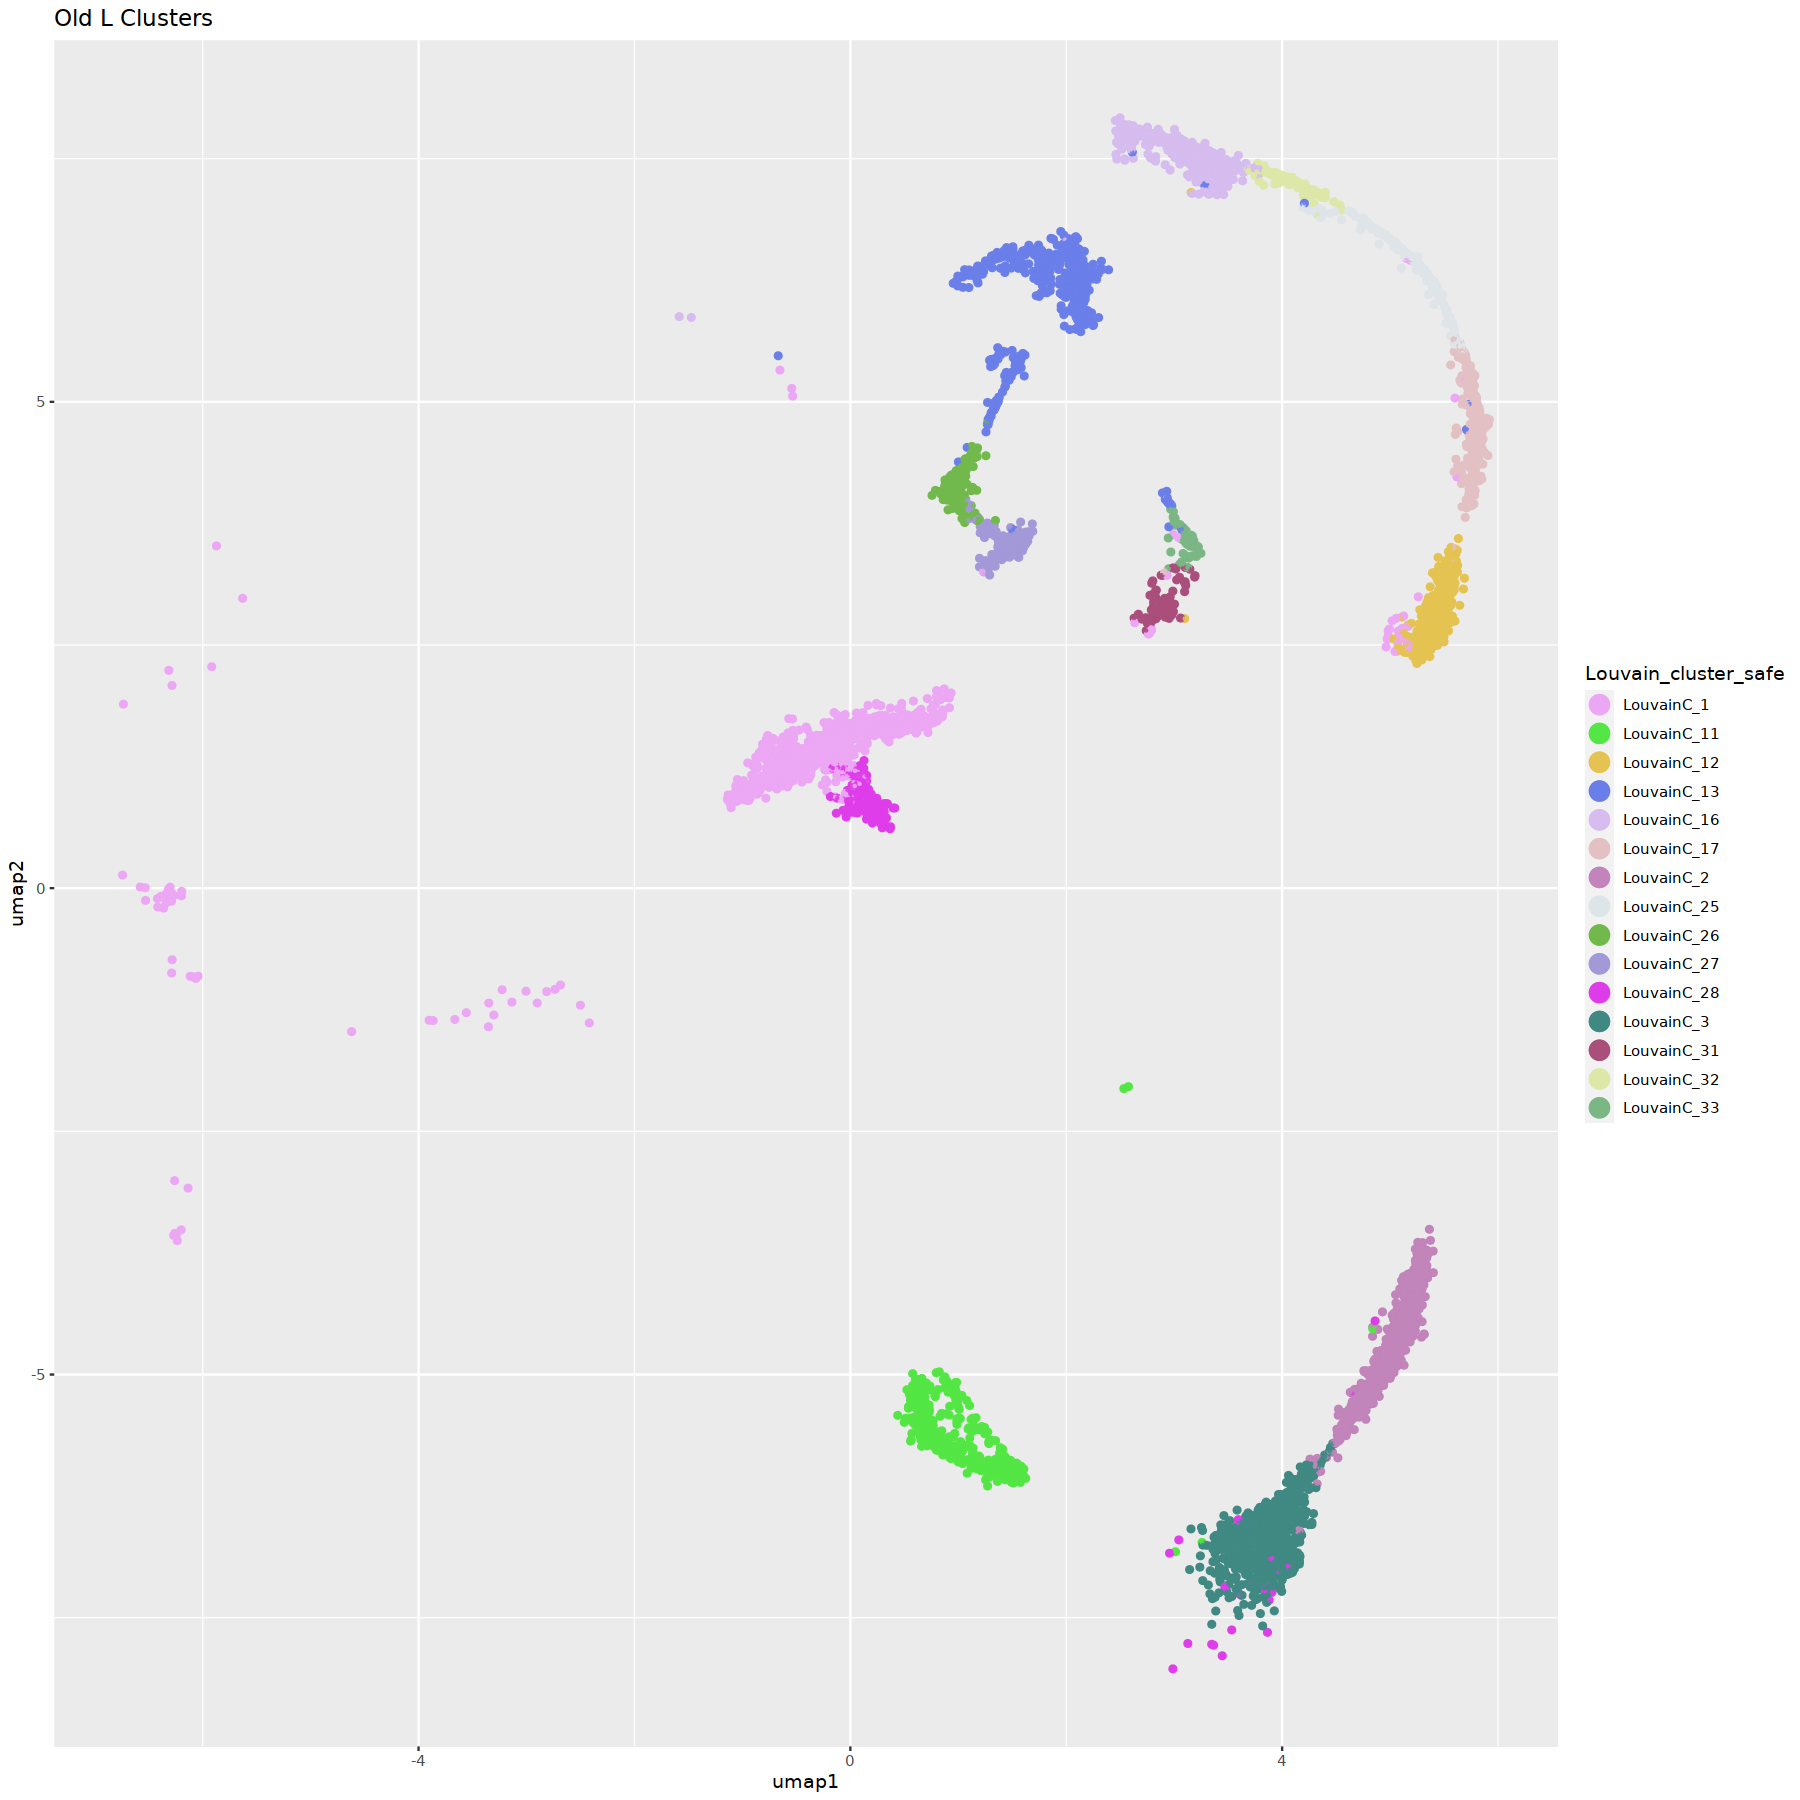

In [56]:
library(cowplot)
library(randomcoloR)
options(repr.plot.width=15, repr.plot.height=15)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)


Sb.subcluster.vasculature <- Sb.subcluster

#clusters <- c("LouvainC_9","LouvainC_19","LouvainC_12","LouvainC_17","LouvainC_13",
#  "LouvainC_35","LouvainC_16","LouvainC_32","LouvainC_24","LouvainC_9","LouvainC_14","LouvainC_23",
#              "LouvainC_25","LouvainC_26","LouvainC_27","LouvainC_31", "LouvainC_1")


## New Cluster selection round 2 
clusters <- c("LouvainC_16","LouvainC_32","LouvainC_25","LouvainC_17","LouvainC_12","LouvainC_3",
              "LouvainC_24", "LouvainC_13","LouvainC_33","LouvainC_31","LouvainC_2","LouvainC_11","LouvainC_28",
              "LouvainC_25","LouvainC_26","LouvainC_27","LouvainC_31", "LouvainC_1")


sb.loaded_socrates_data.vasculature$Clusters  %>% 
    dplyr::filter(Louvain_cluster_safe %in% clusters) %>% 
    group_by(Louvain_cluster_safe) %>% 
    ggplot(., aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

chosen_subcluster <- sb.loaded_socrates_data.vasculature$Clusters %>% 
    filter(Louvain_cluster_safe %in% clusters)

meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- meta_df$cellID
Sb.subcluster.vasculature$meta <- meta_df
Sb.subcluster.vasculature$meta.v3 <- meta_df

In [57]:
Sb.subcluster.vasculature <- generateMatrix(Sb.subcluster.vasculature, 
                                              filtered=FALSE,
                                              peaks = FALSE,
                                              verbose=TRUE)


## Generate Sparse Matrix
Sb.subcluster.vasculature <- convertSparseData(Sb.subcluster.vasculature, verbose = TRUE)

 - converting triplet format to sparseMatrix



In [58]:
# clean sparse counts matrix ---------------------------------------------
Sb.subcluster.vasculature <- cleanData(Sb.subcluster.vasculature, 
                     min.t=0.005,  # minimum feature frequency across cells
                                       max.t = .01,
                     verbose=T)


   * Input: cells = 6527 | peaks = 694096

   * Filtered: cells = 6527 | peaks = 87155



In [59]:
# normalize with TFIDF ---------------------------------------------------
Sb.subcluster.vasculature.tfidf <- tfidf(Sb.subcluster.vasculature)

# project with NMF -------------------------------------------------------
Sb.subcluster.vasculature.tfidf <- reduceDims(Sb.subcluster.vasculature.tfidf,
                      method="SVD", 
                      n.pcs=30, 
                      svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

11:54:07 UMAP embedding parameters a = 1.577 b = 0.8951

11:54:07 Read 6527 rows and found 29 numeric columns

11:54:07 Using Annoy for neighbor search, n_neighbors = 15

11:54:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:54:08 Writing NN index file to temp file /tmp/RtmpD4LrJj/file3a8127dcd66fb

11:54:08 Searching Annoy index using 16 threads, search_k = 1500

11:54:08 Annoy recall = 100%

11:54:12 Commencing smooth kNN distance calibration using 16 threads

11:54:15 Initializing from normalized Laplacian + noise

11:54:15 Commencing optimization for 500 epochs, with 151544 positive edges

11:54:38 Optimization finished



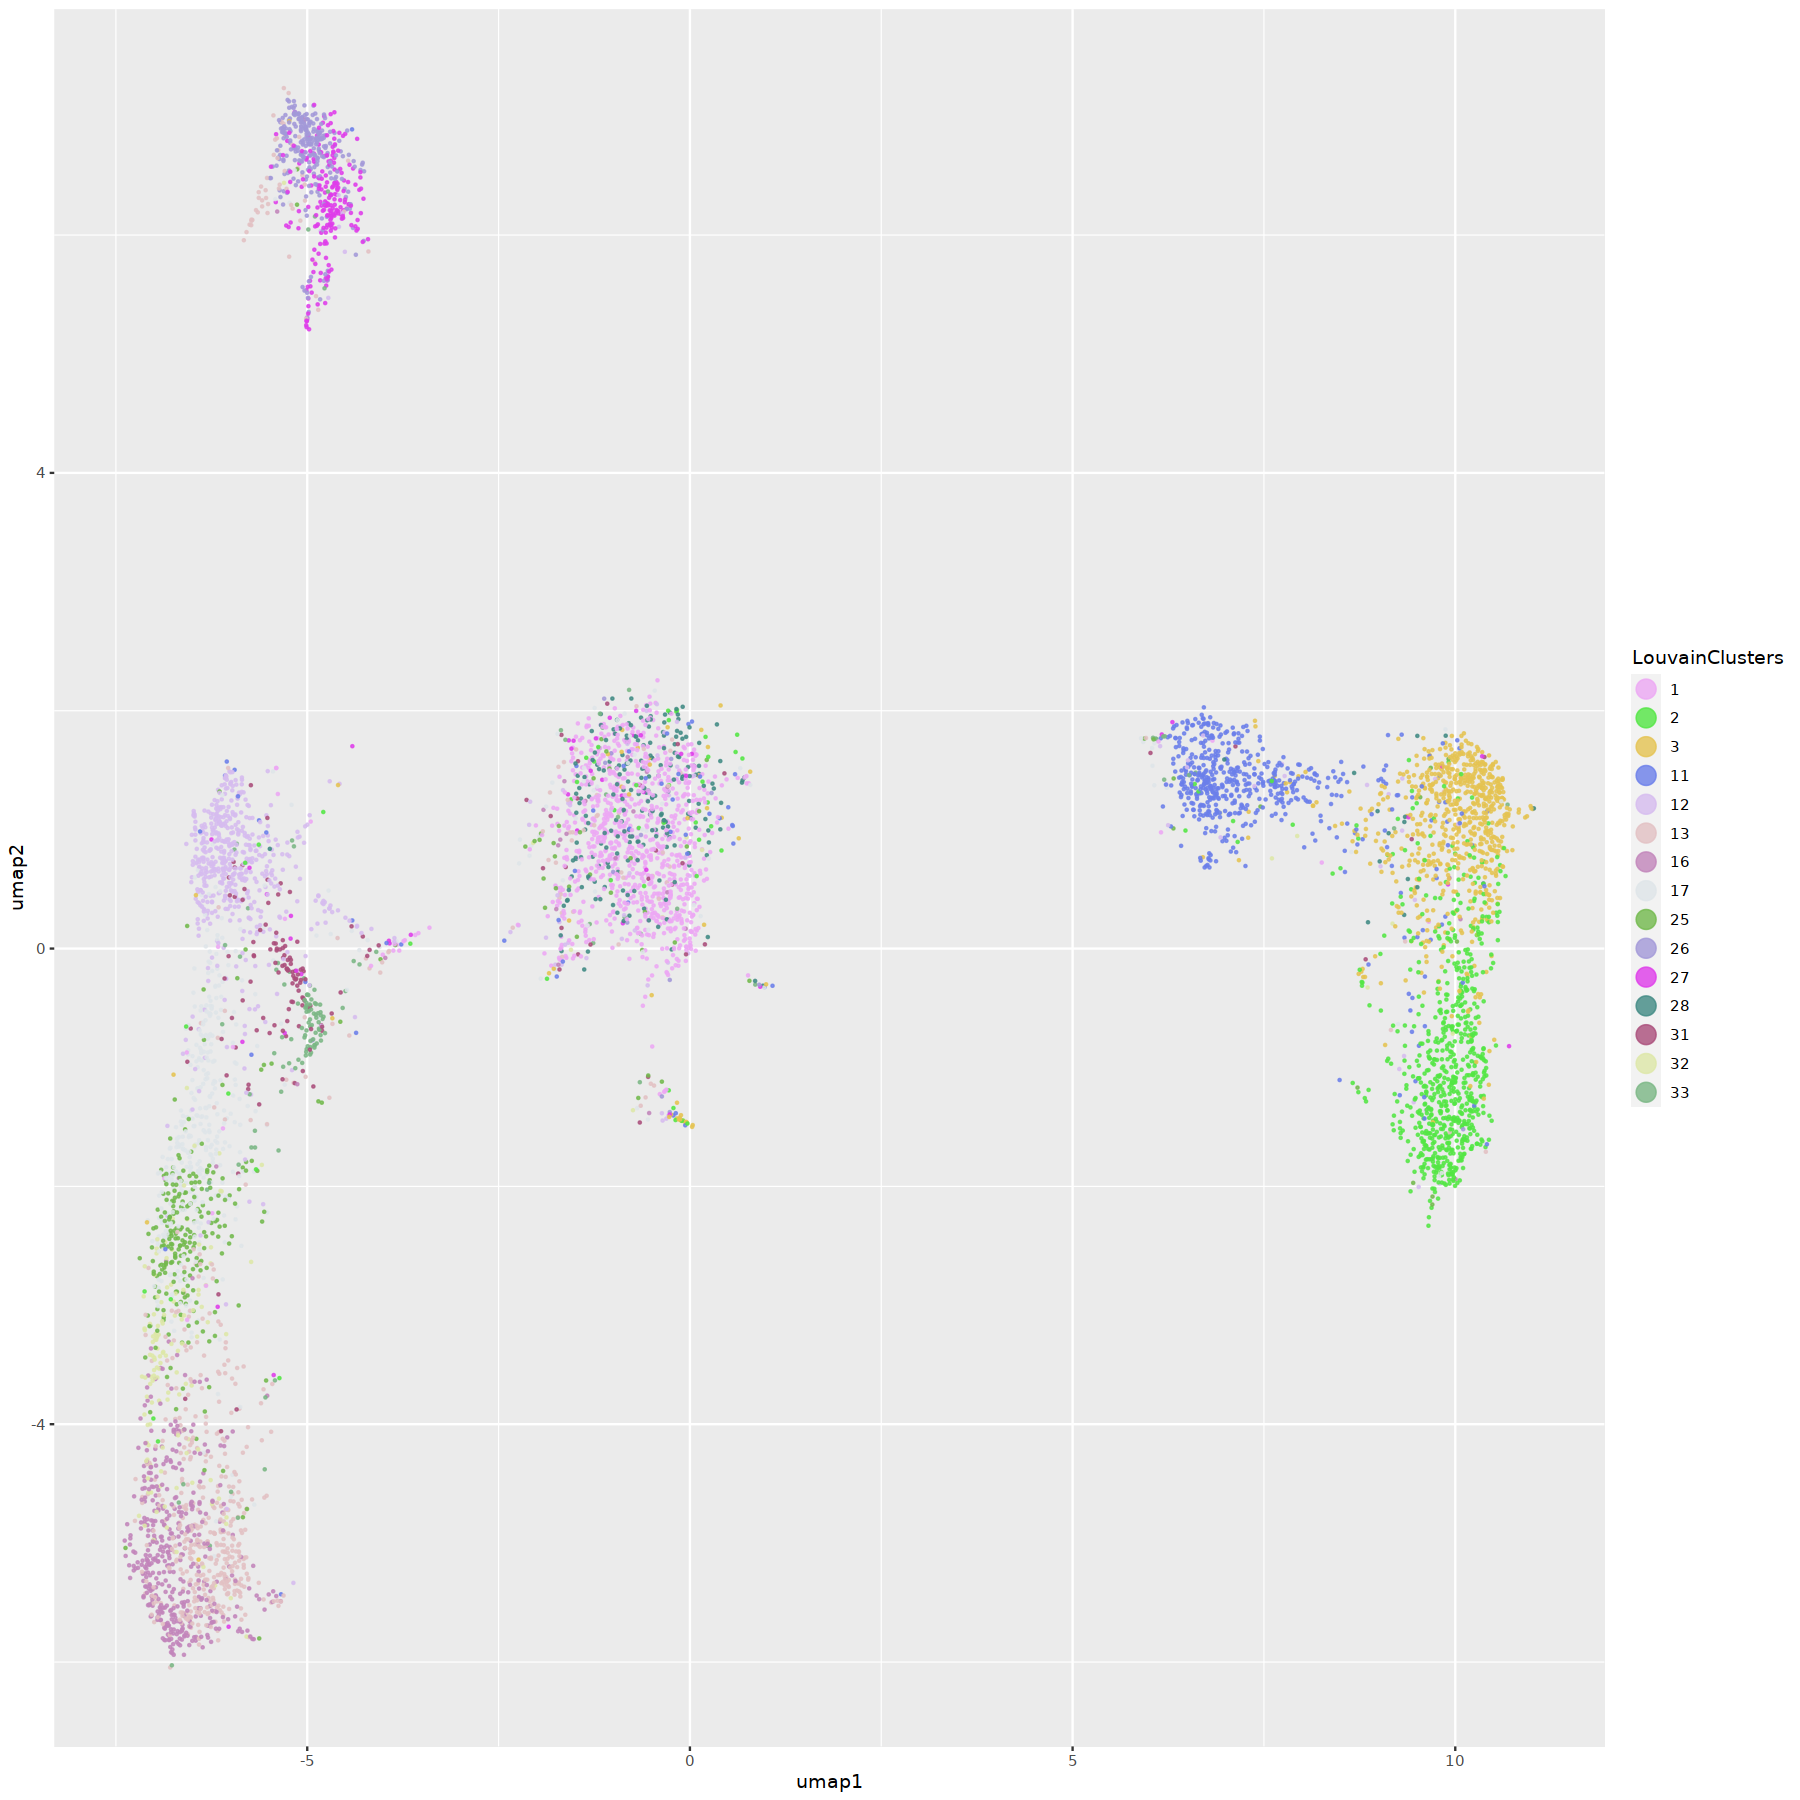

In [60]:
# reduce to 2-dimensions with UMAP ---------------------------------------
Sb.subcluster.vasculature.tfidf <- projectUMAP(Sb.subcluster.vasculature.tfidf, 
                       verbose=T,
                       k.near=15,
                       m.dist=0.1,
                       svd_slotName="SVD")


ggplot(Sb.subcluster.vasculature.tfidf$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

In [61]:
# identify clusters using neighborhood graph -----------------------------
Sb.subcluster.vasculature.tfidf.cluster <- callClusters(Sb.subcluster.vasculature.tfidf, 
                        res=2.5,
                        k.near = 15,
                        #min.reads=1000,
                        verbose=T,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
  
                        cleanCluster=FALSE)


 - filtering outliers in UMAP manifold (z-score e.thresh = 20) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6527
Number of edges: 289826

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.6675
Number of communities: 19
Elapsed time: 8 seconds


 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



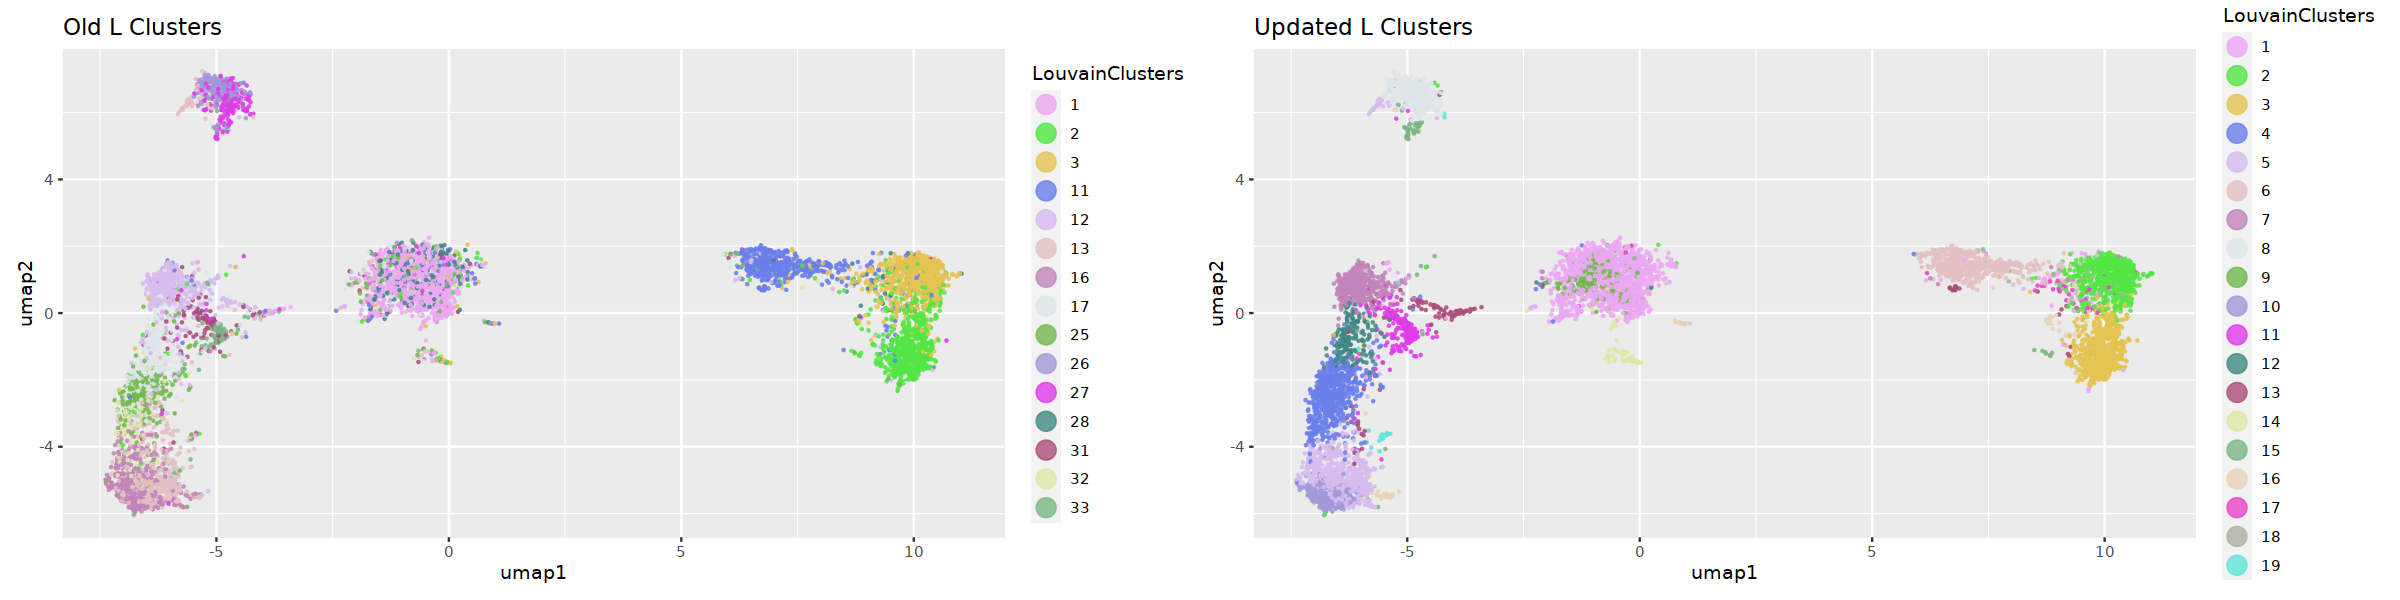

In [62]:
options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(Sb.subcluster.vasculature.tfidf.cluster$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(Sb.subcluster.vasculature.tfidf.cluster$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")


old_clusters + new_clusters 

In [63]:
### Kernal Corrupted to just linked to the previosly run gene body accessability calculations
Sb.subcluster.vasculature.tfidf.cluster <- Sb.subcluster.vasculature.tfidf.cluster
Sb.subcluster.vasculature.tfidf.cluster$acr_counts_raw <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.gene_counts.output"
## Execute Annotation Attempt #1

library(presto)
Sb.subcluster.vasculature.tfidf.cluster <- run_presto(Sb.subcluster.vasculature.tfidf.cluster,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 × 14
  cellID          total    tss   acrs  ptmt nSites log10nSites sampleID    umap1
  <chr>           <dbl>  <dbl>  <dbl> <dbl>  <dbl>       <dbl> <chr>       <dbl>
1 BC:Z:GCCAATAT… 193716 115473 154235     0  47166        4.67 rep1     -0.00267
2 BC:Z:CGATGTAG… 159908  50092  29336     0  69127        4.84 rep1     -1.20   
3 BC:Z:TTAGGCTA…  97214  55597  66879     0  34587        4.54 rep1      0.0151 
4 BC:Z:TTAGGCCT…  88482  54555  72636     0  28966        4.46 rep1     10.5    
5 BC:Z:ACAGTGGG…  85372  44652  47133     0  34058        4.53 rep1     -0.164  
6 BC:Z:GCCAATGA…  83441  49165  67016     0  27966        4.45 rep1     -5.07   
# … with 5 more variables: umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, Louvain_cluster_safe <chr>
# A tibble: 6 × 3
  gene_name        barcode                                         accessability
  <chr>            <chr>                                                   <dbl>
1 Sobic.001G125600 BC:Z:A

In [64]:
grabbed_top_marker_per_cluster <- top_markers(Sb.subcluster.vasculature.tfidf.cluster$presto_marker, 200)

represented_marker_lst <- list()
for (i in unique(Sb.subcluster.vasculature.tfidf.cluster$sub_cluster$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
                                           marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

$`1`
# A tibble: 1 × 8
   rank geneID                       chr      start      end name  type   tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr> <chr>  <chr> 
1    89 Sorbiv5.1_pg7967.valid.m15.g Chr06 58346770 58354051 pdf2  proto… axill…

$`9`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

$`2`
# A tibble: 3 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     1 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2     2 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
3   143 Sobic.005G042000              Chr05  3935393  3936843 ssu2… bund… axill…

$`11`
# A tibble: 4 × 8
   rank geneID                 chr      start      end name         type  tissue
  <int> <chr>                  <chr>    <dbl>    <dbl> <chr>        <chr> <chr> 
1    37 Sobic.002G083600       Chr02  8962876  8967240 SID1         spik… axill…
2    95 Sobic.001G327900       Chr01 65660828 65664161 shr1         matu… axill…
3   124 Sorbiv5.1_pg15531.m1.g Chr03  3341071  3347117 me3_ortho_c… bund… axill…
4   175 Sobic.007G141200       Chr07 60395810 60403219 ccr1         vasc… axill…

$`7`
# A tibble: 2 × 8
   rank geneID                 chr     start     end name           type  tissue
  <int> <chr>                  <chr>   <dbl>   <dbl> <chr>          <chr> <chr> 
1    30 Sorbiv5.1_pg15531.m1.g Chr03 3341071 3347117 me3_ortho_cou… bund… axill…
2    84 Sobic.005G042000       Chr05 3935393 3936843 ssu2__ssu1     bund… axill…

$`12`
# A tibble: 2 × 8
   rank geneID                chr      start      end name  type          tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr> <chr>         <chr> 
1     6 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2   axillary_mer… axill…
2    29 Sobic.007G141200      Chr07 60395810 60403219 ccr1  vascular_scl… axill…

$`5`
# A tibble: 2 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1    85 Sobic.002G032500 Chr02  3002965  3011531 pan2  subsidiary_mother… axill…
2   122 Sobic.007G211200 Chr07 67406141 67408727 pan1  subsidary_mother_… axill…

$`6`
# A tibble: 3 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     4 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
2     5 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
3   189 Sobic.008G193300              Chr08 65745228 65750046 sut2  comp… axill…

$`3`
# A tibble: 6 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     1 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2     9 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
3    41 Sorbiv5.1_pg24873.valid.m3.g  Chr02  2529322  2534592 ZmAA… xyle… axill…
4    64 Sobic.005G042000              Chr05  3935393  3936843 ssu2… bund… axill…
5   121 Sobic.002G207900              Chr02 61233338 61239219 gl1   epid… axill…
6   165 Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764 ba2   axil… axill…

$`8`
# A tibble: 4 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1    37 Sorbiv5.1_pg26238.m1.g        Chr02 19991876 19997282 hp2   prot… axill…
2   104 Sorbiv5.1_pg1793.valid.m1.g   Chr01 13056142 13064330 bhlh… bund… axill…
3   117 Sorbiv5.1_pg29247.valid.m13.g Chr09 53708860 53712249 ZmAA… xyle… axill…
4   118 Sobic.001G488700              Chr01 80047831 80054246 sut1… com

In [65]:
gathered_markers <- bind_rows(represented_marker_lst, .id = "LouvainCluster")  %>% 
    arrange(LouvainCluster, rank)


write_delim(gathered_markers, 
            "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/V3_annotations/Sb_leaf.merged_replicates.Subclustering_vaculature.LouvainCluster_annot_V3.presto.V2.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

gathered_markers

LouvainCluster rank geneID                        chr   start    end     
1  1               89  Sorbiv5.1_pg7967.valid.m15.g  Chr06 58346770 58354051
2  10             102  Sobic.002G032500              Chr02  3002965  3011531
3  10             153  Sobic.007G211200              Chr07 67406141 67408727
4  11              37  Sobic.002G083600              Chr02  8962876  8967240
5  11              95  Sobic.001G327900              Chr01 65660828 65664161
6  11             124  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
7  11             175  Sobic.007G141200              Chr07 60395810 60403219
8  12               6  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
9  12              29  Sobic.007G141200              Chr07 60395810 60403219
10 13             115  Sobic.004G062500              Chr04  5115447  5120789
11 15              75  Sorbiv5.1_pg32051.valid.m7.g  Chr05 69077566 69080525
12 15             166  Sobic.004G058700              Chr04  4774060  4777174
13 17              10  Sobic.004G356700              Chr04 70914994 70920284
14 17              54  Sorbiv5.1_pg3725.valid.m5.g   Chr01 60301159 60308114
15 17              60  Sobic.010G027300              Chr10  2227880  2229782
16 17              80  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
17 18               8  Sobic.010G160700              Chr10 48834723 48842334
18 18             131  Sorbiv5.1_pg32051.valid.m7.g  Chr05 69077566 69080525
19 19               8  Sorbiv5.1_pg5044.valid.m7.g   Chr01 66616555 66619678
20 19             128  Sobic.003G359200              Chr03 74006712 74009512
21 2                1  Sobic.010G160700              Chr10 48834723 48842334
22 2                2  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
23 2              143  Sobic.005G042000              Chr05  3935393  3936843
24 3                1  Sobic.010G160700              Chr10 48834723 48842334
25 3                9  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
26 3               41  Sorbiv5.1_pg24873.valid.m3.g  Chr02  2529322  2534592
27 3               64  Sobic.005G042000              Chr05  3935393  3936843
28 3              121  Sobic.002G207900              Chr02 61233338 61239219
29 3              165  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
30 4                2  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
31 4               75  Sobic.007G141200              Chr07 60395810 60403219
32 4              165  Sobic.009G162000              Chr09 55658168 55661565
33 4              177  Sorbiv5.1_pg31052.valid.m1.g  Chr09 63154998 63156307
34 4              190  Sobic.008G015200              Chr08  1324018  1337760
35 5               85  Sobic.002G032500              Chr02  3002965  3011531
36 5              122  Sobic.007G211200              Chr07 67406141 67408727
37 6                4  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
38 6                5  Sobic.010G160700              Chr10 48834723 48842334
39 6              189  Sobic.008G193300              Chr08 65745228 65750046
40 7               30  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
41 7               84  Sobic.005G042000              Chr05  3935393  3936843
42 8               37  Sorbiv5.1_pg26238.m1.g        Chr02 19991876 19997282
43 8              104  Sorbiv5.1_pg1793.valid.m1.g   Chr01 13056142 13064330
44 8              117  Sorbiv5.1_pg29247.valid.m13.g Chr09 53708860 53712249
45 8              118  Sobic.001G488700              Chr01 80047831 80054246
   name             
1  pdf2             
2  pan2             
3  pan1             
4  SID1             
5  shr1             
6  me3_ortho_count_1
7  ccr1             
8  ba2              
9  ccr1             
10 bm5              
11 mlks2            
12 ZmAPL            
13 brk1             
14 ocl4             
15 BAF1             
16 cah1             
17 pepc1            
18 mlks2            
19 bk1              
20 ZmOPL2           
21 pepc1            

In [66]:

prefix <- "Sb_leaf.merged_replicates.Subclustering_vasculature.V2"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"

# output text files
nmf.meta <- Sb.subcluster.vasculature.tfidf.cluster$sub_cluster
nmf.rd <- Sb.subcluster.vasculature.tfidf.cluster$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


#Generate Sparse Matrix-
trip <- as.data.frame(summary(Sb.subcluster.vasculature.tfidf.cluster$counts))
trip$i <- rownames(Sb.subcluster.vasculature.tfidf.cluster$counts)[trip$i]
trip$j <- colnames(Sb.subcluster.vasculature.tfidf.cluster$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")



In [67]:
saveRDS(Sb.subcluster.vasculature.tfidf.cluster, file = paste0(output_location, prefix, ".rds"))

In [3]:
## After Inital Analysis - wanting to re-run presto while dropping the identified mesophyll clusters to add resolution tl
## Louvain cluster 1 


re_run_presto <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb_leaf.merged_replicates.Subclustering_vasculature.rds")

In [11]:
unique(re_run_presto$sub_cluster$LouvainClusters)

[1] 8  1  4  9  3  5  11 2  6  7  13 10 12
Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13

In [24]:
`%notin%` <- Negate(`%in%`)
filtered_clusters <- re_run_presto$sub_cluster  %>% 
    dplyr::filter(LouvainClusters %notin% c("2", "10", "7"))

re_run_presto$sub_cluster <- as.data.frame(filtered_clusters)

In [25]:
unique(filtered_clusters$LouvainClusters)

[1] 8  1  4  9  3  5  11 6  13 12
Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13

In [26]:
Sb.subcluster.vasculature.tfidf.cluster.2 <- run_presto(re_run_presto,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 × 14
  cellID     total    tss   acrs  ptmt nSites log10nSites sampleID  umap1  umap2
  <chr>      <dbl>  <dbl>  <dbl> <dbl>  <dbl>       <dbl> <chr>     <dbl>  <dbl>
1 BC:Z:GCC… 193716 115473 154235     0  47166        4.67 rep1     -0.815  0.191
2 BC:Z:CGA… 159908  50092  29336     0  69127        4.84 rep1     -3.95  -0.879
3 BC:Z:TTA… 137820  80881  99700     0  40325        4.61 rep1     -1.09   0.698
4 BC:Z:ACA…  98568  56617  71027     0  32074        4.51 rep1     -1.01   0.531
5 BC:Z:TTA…  97214  55597  66879     0  34587        4.54 rep1     -1.40   0.154
6 BC:Z:ACA…  85372  44652  47133     0  34058        4.53 rep1     -2.09  -0.533
# … with 4 more variables: doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, Louvain_cluster_safe <chr>
# A tibble: 6 × 3
  gene_name        barcode                                         accessability
  <chr>            <chr>                                                   <dbl>
1 Sobic.001G125600 BC:Z:ACAGTGCTTGTATG

In [27]:
grabbed_top_marker_per_cluster <- top_markers(Sb.subcluster.vasculature.tfidf.cluster.2$presto_marker, 200)

represented_marker_lst <- list()
for (i in unique(Sb.subcluster.vasculature.tfidf.cluster.2$sub_cluster$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
                                           marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

$`8`
# A tibble: 3 × 8
   rank geneID                      chr      start      end name  type    tissue
  <int> <chr>                       <chr>    <dbl>    <dbl> <chr> <chr>   <chr> 
1     1 Sobic.002G207900            Chr02 61233338 61239219 gl1   epider… axill…
2     9 Sorbiv5.1_pg9159.m1.g       Chr06 41574374 41588764 ba2   axilla… axill…
3    35 Sorbiv5.1_pg5044.valid.m7.g Chr01 66616555 66619678 bk1   vascul… axill…

$`1`
# A tibble: 1 × 8
   rank geneID                       chr      start      end name  type   tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr> <chr>  <chr> 
1   155 Sorbiv5.1_pg7967.valid.m15.g Chr06 58346770 58354051 pdf2  proto… axill…

$`4`
# A tibble: 2 × 8
   rank geneID                 chr     start     end name           type  tissue
  <int> <chr>                  <chr>   <dbl>   <dbl> <chr>          <chr> <chr> 
1    12 Sobic.005G042000       Chr05 3935393 3936843 ssu2__ssu1     bund… axill…
2   130 Sorbiv5.1_pg15531.m1.g Chr03 3341071 3347117 me3_ortho_cou… bund… axill…

$`9`
# A tibble: 3 × 8
   rank geneID                chr      start      end name       type     tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr>      <chr>    <chr> 
1     3 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2        axillar… axill…
2     7 Sobic.007G141200      Chr07 60395810 60403219 ccr1       vascula… axill…
3    11 Sobic.005G042000      Chr05  3935393  3936843 ssu2__ssu1 bundle_… axill…

$`3`
# A tibble: 3 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1   109 Sobic.002G032500 Chr02  3002965  3011531 pan2  subsidiary_mother… axill…
2   138 Sobic.007G211200 Chr07 67406141 67408727 pan1  subsidary_mother_… axill…
3   144 Sobic.001G499200 Chr01 81035681 81040362 nod   stomata            axill…

$`5`
# A tibble: 4 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1    29 Sorbiv5.1_pg26238.m1.g        Chr02 19991876 19997282 hp2   prot… axill…
2    68 Sobic.001G488700              Chr01 80047831 80054246 sut1… comp… axill…
3   120 Sorbiv5.1_pg29247.valid.m13.g Chr09 53708860 53712249 ZmAA… xyle… axill…
4   132 Sobic.004G058700              Chr04  4774060  4777174 ZmAPL prot… axill…

$`11`
# A tibble: 6 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1    15 Sobic.001G075101              Chr01  5763796  5774227 knox8 SAM,… axill…
2    16 Sobic.002G207900              Chr02 61233338 61239219 gl1   epid… axill…
3    21 Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764 ba2   axil… axill…
4   130 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
5   138 Sorbiv5.1_pg24873.valid.m3.g  Chr02  2529322  2534592 ZmAA… xyle… axill…
6   154 Sobic.001G537300              Chr01 84195608 84203525 rld1  SAM,… axill…

$`6`
# A tibble: 3 × 8
   rank geneID                       chr      start      end name   type  tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr>  <chr> <chr> 
1     7 Sorbiv5.1_pg9159.m1.g        Chr06 41574374 41588764 ba2    axil… axill…
2    55 Sobic.009G162000             Chr09 55658168 55661565 gpat1… epid… axill…
3   116 Sorbiv5.1_pg31052.valid.m1.g Chr09 63154998 63156307 mute   guar… axill…

$`13`
# A tibble: 2 × 8
   rank geneID           chr      start      end name               type  tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr>              <chr> <chr> 
1    24 Sobic.008G094000 Chr08 46768135 46771205 sweet13a_ortho_co… abax… leaf  
2   132 Sobic.006G262100 Chr06 61127079 61135209 ZmMP_3             proc… axill…

$`12`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, ti

# Subclustering Mesophyll and Unknown Clusters

In [7]:
sb.loaded_socrates_data.mesophyll <- loaded_socrates_data
cleaned_cluster_meta <- sb.loaded_socrates_data.mesophyll$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))
    
sb.loaded_socrates_data.mesophyll$Clusters <- cleaned_cluster_meta

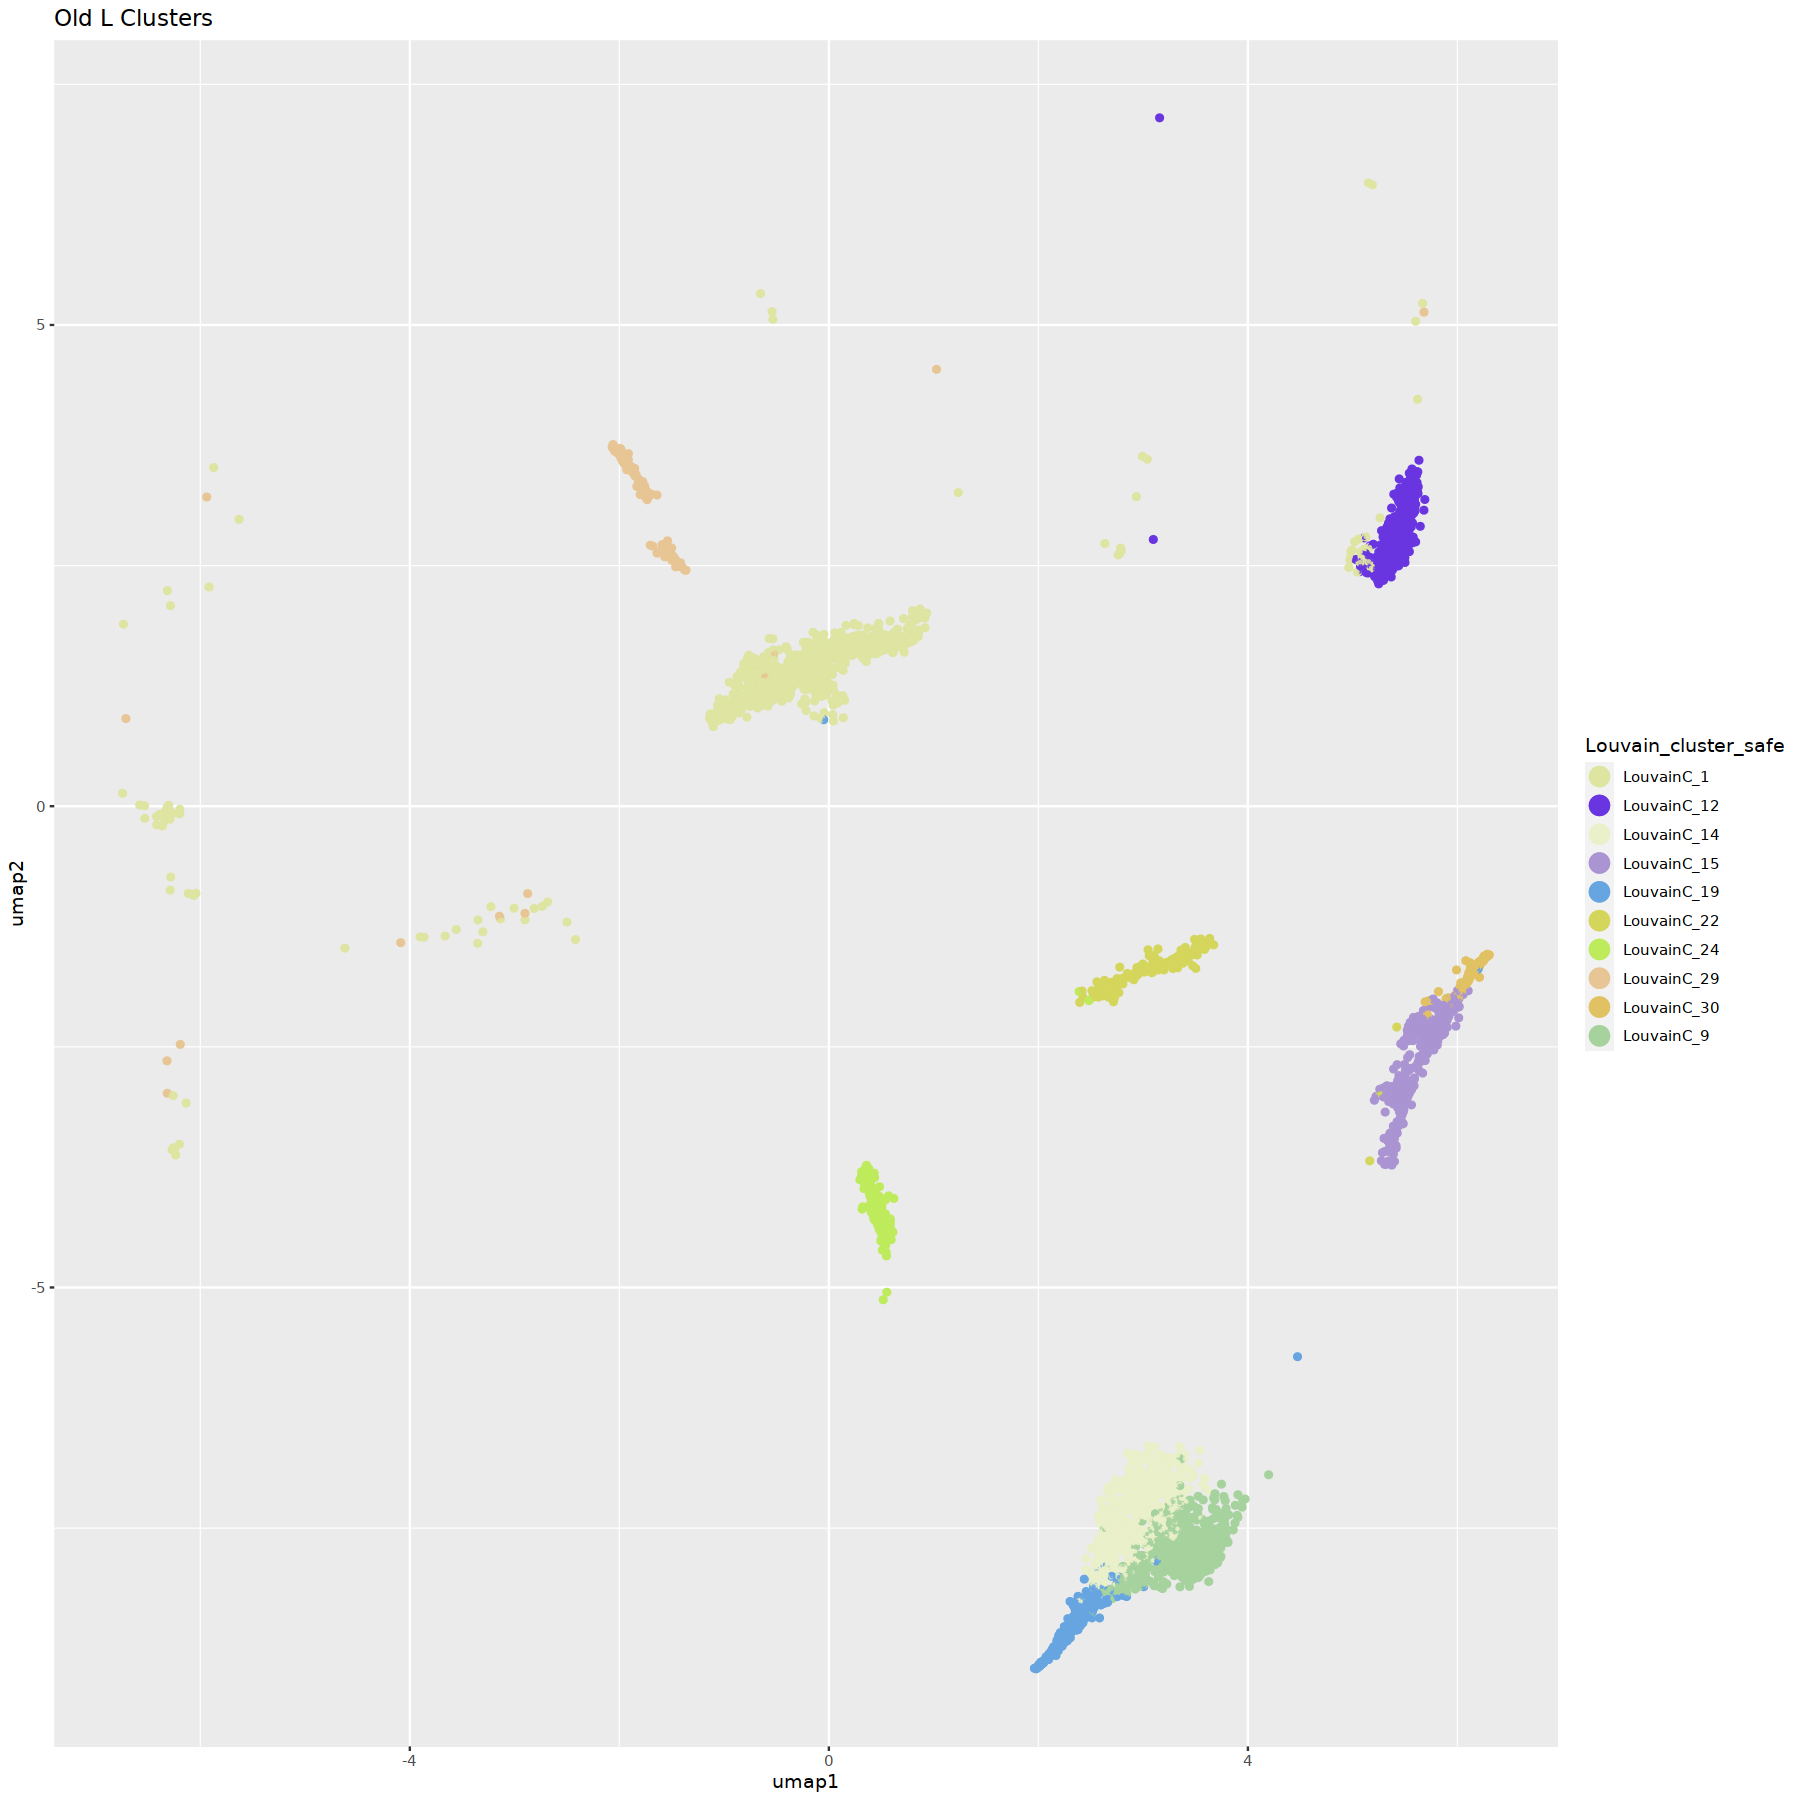

In [8]:
library(cowplot)
library(randomcoloR)
options(repr.plot.width=15, repr.plot.height=15)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)


Sb.subcluster.mesophyll <- Sb.subcluster

clusters <- c("LouvainC_9","LouvainC_14","LouvainC_19","LouvainC_24",
              "LouvainC_19","LouvainC_12", "LouvainC_1",
  "LouvainC_15","LouvainC_30","LouvainC_22", "LouvainC_29")

#c("LouvainC_18","LouvainC_5","LouvainC_7","LouvainC_32",
#  "LouvainC_24","LouvainC_21","LouvainC_8","LouvainC_20","LouvainC_23")

sb.loaded_socrates_data.mesophyll$Clusters  %>% 
    dplyr::filter(Louvain_cluster_safe %in% clusters) %>% 
    group_by(Louvain_cluster_safe) %>% 
    ggplot(., aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

chosen_subcluster <- sb.loaded_socrates_data.mesophyll$Clusters %>% 
    filter(Louvain_cluster_safe %in% clusters)

meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- meta_df$cellID
Sb.subcluster.mesophyll$meta <- meta_df
Sb.subcluster.mesophyll$meta.v3 <- meta_df

In [9]:
Sb.subcluster.mesophyll <- generateMatrix(Sb.subcluster.mesophyll, 
                                              filtered=FALSE,
                                              peaks = FALSE,
                                              verbose=TRUE)


## Generate Sparse Matrix
Sb.subcluster.mesophyll <- convertSparseData(Sb.subcluster.mesophyll, verbose = TRUE)

 - converting triplet format to sparseMatrix



In [10]:
# clean sparse counts matrix ---------------------------------------------
Sb.subcluster.mesophyll <- cleanData(Sb.subcluster.mesophyll, 
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t = .01,
                     verbose=T)


   * Input: cells = 4515 | peaks = 694096

   * Filtered: cells = 4515 | peaks = 88252



In [11]:
# normalize with TFIDF ---------------------------------------------------
Sb.subcluster.mesophyll.tfidf <- tfidf(Sb.subcluster.mesophyll)

# project with NMF -------------------------------------------------------
Sb.subcluster.mesophyll.tfidf <- reduceDims(Sb.subcluster.mesophyll.tfidf,
                      method="SVD", 
                      n.pcs=30, 
                      svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

14:08:18 UMAP embedding parameters a = 1.577 b = 0.8951

14:08:18 Read 4515 rows and found 29 numeric columns

14:08:18 Using Annoy for neighbor search, n_neighbors = 30

14:08:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:08:18 Writing NN index file to temp file /tmp/RtmpjxCfFk/file426085c6303

14:08:18 Searching Annoy index using 16 threads, search_k = 3000

14:08:18 Annoy recall = 100%

14:08:22 Commencing smooth kNN distance calibration using 16 threads

14:08:24 Initializing from normalized Laplacian + noise

14:08:25 Commencing optimization for 500 epochs, with 217840 positive edges

14:08:45 Optimization finished



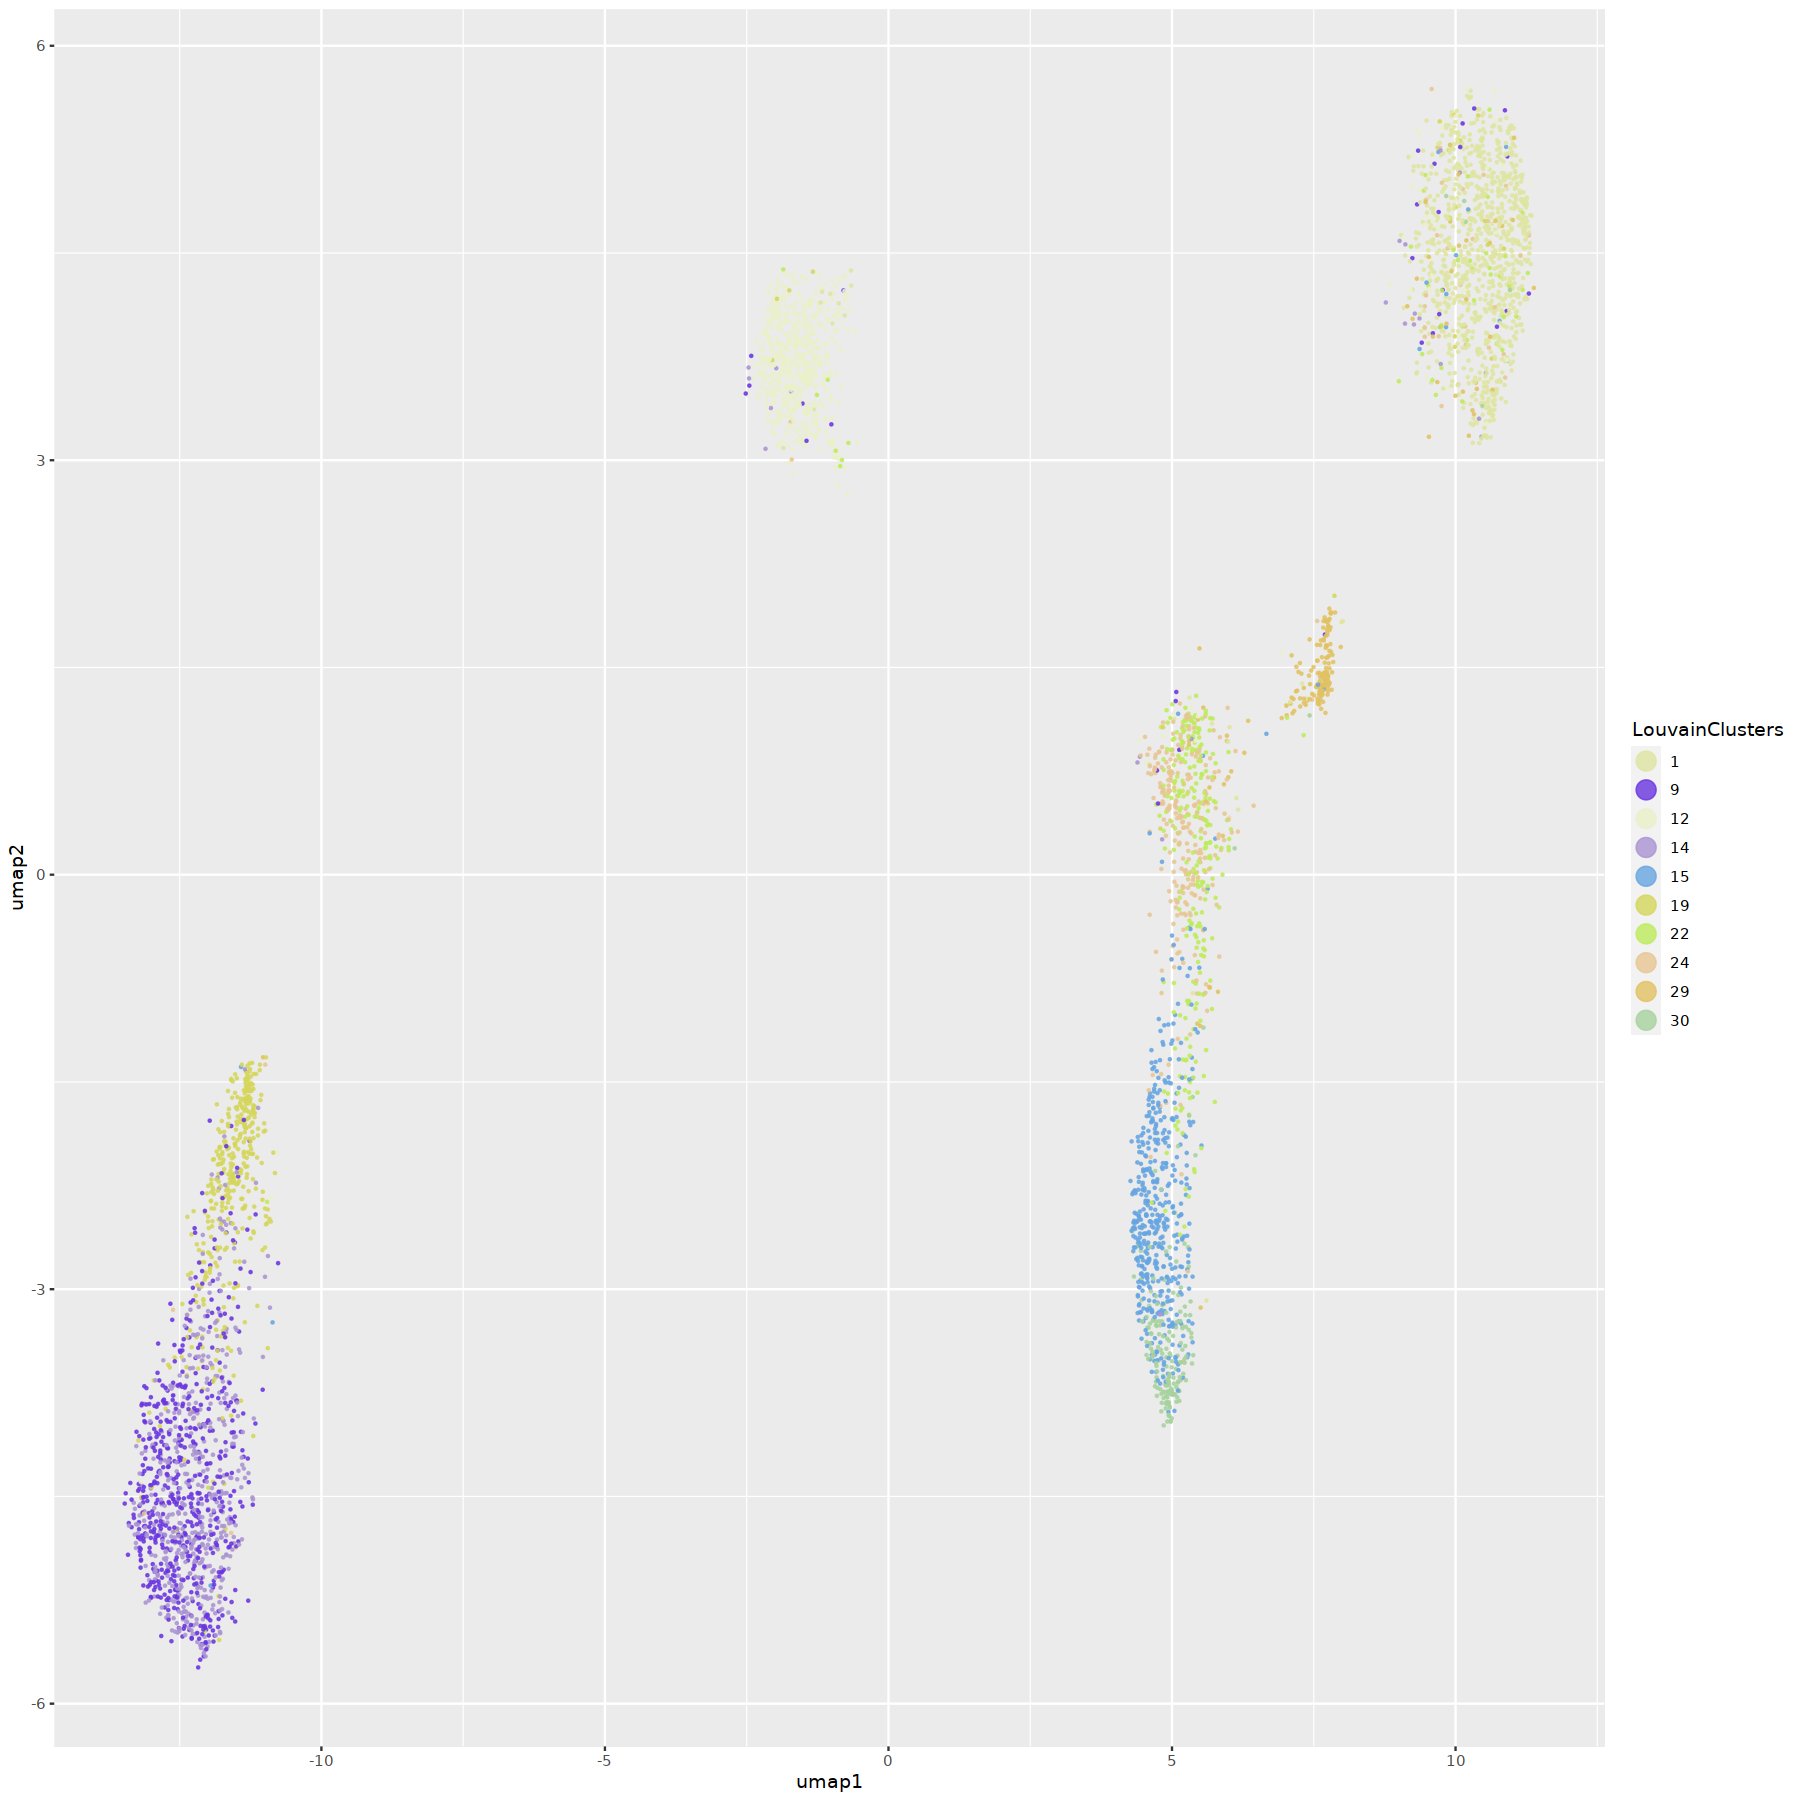

In [12]:
# reduce to 2-dimensions with UMAP ---------------------------------------
Sb.subcluster.mesophyll.tfidf <- projectUMAP(Sb.subcluster.mesophyll.tfidf, 
                       verbose=T,
                       k.near=30,
                       m.dist=0.1,
                       svd_slotName="SVD")


ggplot(Sb.subcluster.mesophyll.tfidf$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

In [13]:
# identify clusters using neighborhood graph -----------------------------
Sb.subcluster.mesophyll.tfidf.cluster <- callClusters(Sb.subcluster.mesophyll.tfidf, 
                        res=2.5,
                        k.near = 30,
                        #min.reads=1000,
                        verbose=T,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
                        min.reads=1,
                        m.clst=1,
                        e.thresh = 20,
                        cleanCluster=FALSE)


 - filtering outliers in UMAP manifold (z-score e.thresh = 20) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4515
Number of edges: 388029

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.5779
Number of communities: 10
Elapsed time: 8 seconds


 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



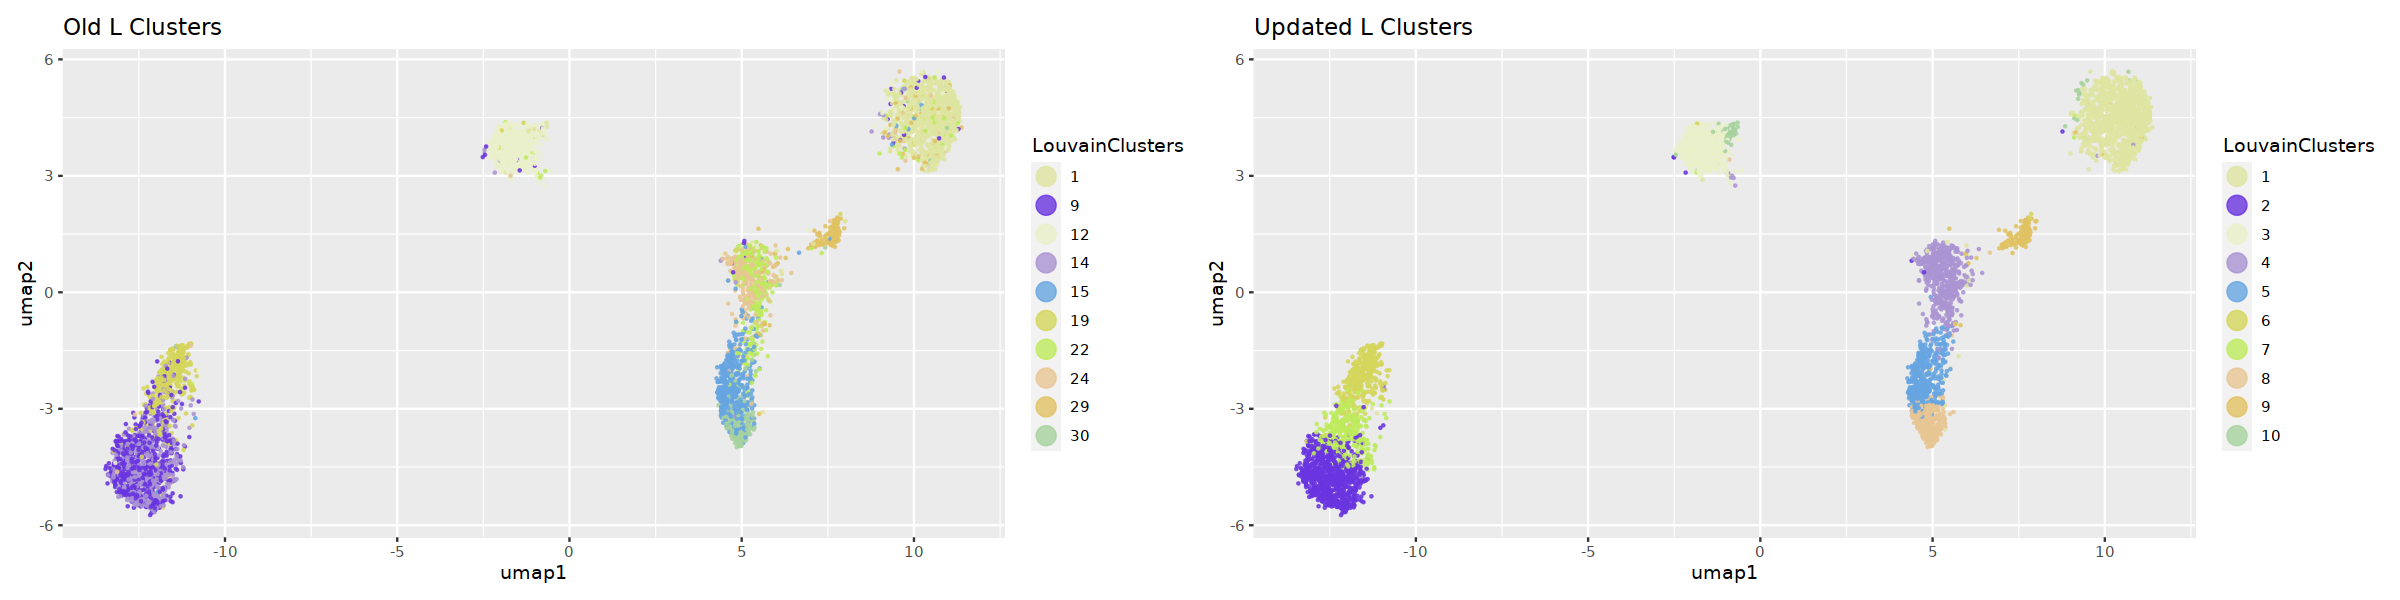

In [14]:
options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(Sb.subcluster.mesophyll.tfidf.cluster$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(Sb.subcluster.mesophyll.tfidf.cluster$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")


old_clusters + new_clusters 

In [17]:
### Kernal Corrupted to just linked to the previosly run gene body accessability calculations
Sb.subcluster.mesophyll.tfidf.cluster.cluster <- Sb.subcluster.mesophyll.tfidf.cluster
Sb.subcluster.mesophyll.tfidf.cluster.cluster$acr_counts_raw <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.gene_counts.output"
## Execute Annotation Attempt #1

library(presto)
Sb.subcluster.mesophyll.tfidf.cluster.cluster <- run_presto(Sb.subcluster.mesophyll.tfidf.cluster.cluster,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 × 14
  cellID      total    tss   acrs  ptmt nSites log10nSites sampleID umap1  umap2
  <chr>       <dbl>  <dbl>  <dbl> <dbl>  <dbl>       <dbl> <chr>    <dbl>  <dbl>
1 BC:Z:GCCA… 193716 115473 154235     0  47166        4.67 rep1      6.13  0.556
2 BC:Z:CGAT… 159908  50092  29336     0  69127        4.84 rep1     11.3   4.65 
3 BC:Z:TGAC… 115159  66137  88585     0  35122        4.55 rep1      5.50  0.825
4 BC:Z:TTAG…  97214  55597  66879     0  34587        4.54 rep1     10.6   3.17 
5 BC:Z:ACAG…  85372  44652  47133     0  34058        4.53 rep1     10.7   3.29 
6 BC:Z:ATCA…  79947  38798  43908     0  32706        4.51 rep1      5.76 -1.64 
# … with 4 more variables: doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, Louvain_cluster_safe <chr>
# A tibble: 6 × 3
  gene_name        barcode                                         accessability
  <chr>            <chr>                                                   <dbl>
1 Sobic.001G125600 BC:Z:ACAGTGCTTGTATG

In [18]:
grabbed_top_marker_per_cluster <- top_markers(Sb.subcluster.mesophyll.tfidf.cluster.cluster$presto_marker, 200)

represented_marker_lst <- list()
for (i in unique(Sb.subcluster.mesophyll.tfidf.cluster.cluster$sub_cluster$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
                                           marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(i)` instead of `i` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


$`4`
# A tibble: 2 × 8
   rank geneID                chr      start      end name  type          tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr> <chr>         <chr> 
1     2 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2   axillary_mer… axill…
2    56 Sobic.002G207900      Chr02 61233338 61239219 gl1   epidermis     axill…

$`1`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

$`5`
# A tibble: 3 × 8
   rank geneID                       chr      start      end name   type  tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr>  <chr> <chr> 
1   123 Sorbiv5.1_pg10258.valid.m1.g Chr10 11111919 11115601 fea4   peri… axill…
2   141 Sobic.001G499200             Chr01 81035681 81040362 nod    stom… axill…
3   190 Sobic.001G267100             Chr01 54978216 54983302 ZmLAX2 proc… axill…

$`3`
# A tibble: 2 × 8
   rank geneID                 chr     start     end name           type  tissue
  <int> <chr>                  <chr>   <dbl>   <dbl> <chr>          <chr> <chr> 
1    45 Sobic.005G042000       Chr05 3935393 3936843 ssu2__ssu1     bund… axill…
2   102 Sorbiv5.1_pg15531.m1.g Chr03 3341071 3347117 me3_ortho_cou… bund… axill…

$`2`
# A tibble: 2 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     1 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2     2 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…

$`9`
# A tibble: 5 × 8
   rank geneID                       chr      start      end name   type  tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr>  <chr> <chr> 
1     6 Sobic.001G221900             Chr01 21229983 21235639 ad1    prot… axill…
2    23 Sobic.007G003000             Chr07   278193   279964 vnd7_1 prot… axill…
3    24 Sobic.002G343500             Chr02 72301461 72308725 ZmCPK… guar… axill…
4    73 Sorbiv5.1_pg5044.valid.m7.g  Chr01 66616555 66619678 bk1    vasc… axill…
5   167 Sorbiv5.1_pg18344.valid.m8.g Chr07  4750649  4755104 nac77  phlo… axill…

$`8`
# A tibble: 2 × 8
   rank geneID                       chr      start      end name  type   tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr> <chr>  <chr> 
1    22 Sorbiv5.1_pg14938.valid.m7.g Chr03  8560607  8567782 ocl1  proto… axill…
2    95 Sobic.001G499200             Chr01 81035681 81040362 nod   stoma… axill…

$`7`
# A tibble: 2 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     1 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2     6 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…

$`10`
# A tibble: 3 × 8
   rank geneID           chr      start      end name       type          tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr>      <chr>         <chr> 
1    39 Sobic.005G042000 Chr05  3935393  3936843 ssu2__ssu1 bundle_sheath axill…
2    40 Sobic.007G141200 Chr07 60395810 60403219 ccr1       vascular_scl… axill…
3   167 Sobic.003G052700 Chr03  4799275  4804531 vt2        epidermis,pr… axill…

$`6`
# A tibble: 2 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     2 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2    52 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…

In [19]:
gathered_markers <- bind_rows(represented_marker_lst, .id = "LouvainCluster")  %>% 
    arrange(LouvainCluster, rank)


write_delim(gathered_markers, 
            "/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/V3_annotations/Sb_leaf.merged_replicates.Subclustering_mesophyll.LouvainCluster_annot_V3.presto.V2.txt", 
            col_names = TRUE, quote = "none", delim = "\t")

gathered_markers

LouvainCluster rank geneID                        chr   start    end     
1  10              39  Sobic.005G042000              Chr05  3935393  3936843
2  10              40  Sobic.007G141200              Chr07 60395810 60403219
3  10             167  Sobic.003G052700              Chr03  4799275  4804531
4  2                1  Sobic.010G160700              Chr10 48834723 48842334
5  2                2  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
6  3               45  Sobic.005G042000              Chr05  3935393  3936843
7  3              102  Sorbiv5.1_pg15531.m1.g        Chr03  3341071  3347117
8  4                2  Sorbiv5.1_pg9159.m1.g         Chr06 41574374 41588764
9  4               56  Sobic.002G207900              Chr02 61233338 61239219
10 5              123  Sorbiv5.1_pg10258.valid.m1.g  Chr10 11111919 11115601
11 5              141  Sobic.001G499200              Chr01 81035681 81040362
12 5              190  Sobic.001G267100              Chr01 54978216 54983302
13 6                2  Sobic.010G160700              Chr10 48834723 48842334
14 6               52  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
15 7                1  Sobic.010G160700              Chr10 48834723 48842334
16 7                6  Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676
17 8               22  Sorbiv5.1_pg14938.valid.m7.g  Chr03  8560607  8567782
18 8               95  Sobic.001G499200              Chr01 81035681 81040362
19 9                6  Sobic.001G221900              Chr01 21229983 21235639
20 9               23  Sobic.007G003000              Chr07   278193   279964
21 9               24  Sobic.002G343500              Chr02 72301461 72308725
22 9               73  Sorbiv5.1_pg5044.valid.m7.g   Chr01 66616555 66619678
23 9              167  Sorbiv5.1_pg18344.valid.m8.g  Chr07  4750649  4755104
   name             
1  ssu2__ssu1       
2  ccr1             
3  vt2              
4  pepc1            
5  cah1             
6  ssu2__ssu1       
7  me3_ortho_count_1
8  ba2              
9  gl1              
10 fea4             
11 nod              
12 ZmLAX2           
13 pepc1            
14 cah1             
15 pepc1            
16 cah1             
17 ocl1             
18 nod              
19 ad1              
20 vnd7_1           
21 ZmCPK37__ZmCPK35 
22 bk1              
23 nac77            
   type                                                                                                                                                                                                                                                                                                               
1  bundle_sheath                                                                                                                                                                                                                                                                                                      
2  vascular_sclerenchyma                                                                                                                                                                                                                                                                                              
3  epidermis,provascular_strands,L1_spikelet_pair_meristem,L1_glume_primordia,L1_spikelet_meristem                                                                                                                                                                                                                    
4  mesophyll                                                                                                                                                                                                                                                                                                          
5  mesophyll                                                                                    

In [20]:

prefix <- "Sb_leaf.merged_replicates.Subclustering_mesophyll.V2"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/"

# output text files
nmf.meta <- Sb.subcluster.mesophyll.tfidf.cluster$sub_cluster
nmf.rd <- Sb.subcluster.mesophyll.tfidf.cluster$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")


#Generate Sparse Matrix-
trip <- as.data.frame(summary(Sb.subcluster.mesophyll.tfidf.cluster$counts))
trip$i <- rownames(Sb.subcluster.mesophyll.tfidf.cluster$counts)[trip$i]
trip$j <- colnames(Sb.subcluster.mesophyll.tfidf.cluster$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")



In [21]:
saveRDS(Sb.subcluster.mesophyll.tfidf.cluster, file = paste0(output_location, prefix, ".rds"))

# Re-Clustering Unknown Epidermal and Central Lineage




In [11]:
sb.loaded_socrates_data.LC1 <- loaded_socrates_data
cleaned_cluster_meta <- sb.loaded_socrates_data.LC1$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))
    
sb.loaded_socrates_data.LC1$Clusters <- cleaned_cluster_meta

 - converting triplet format to sparseMatrix



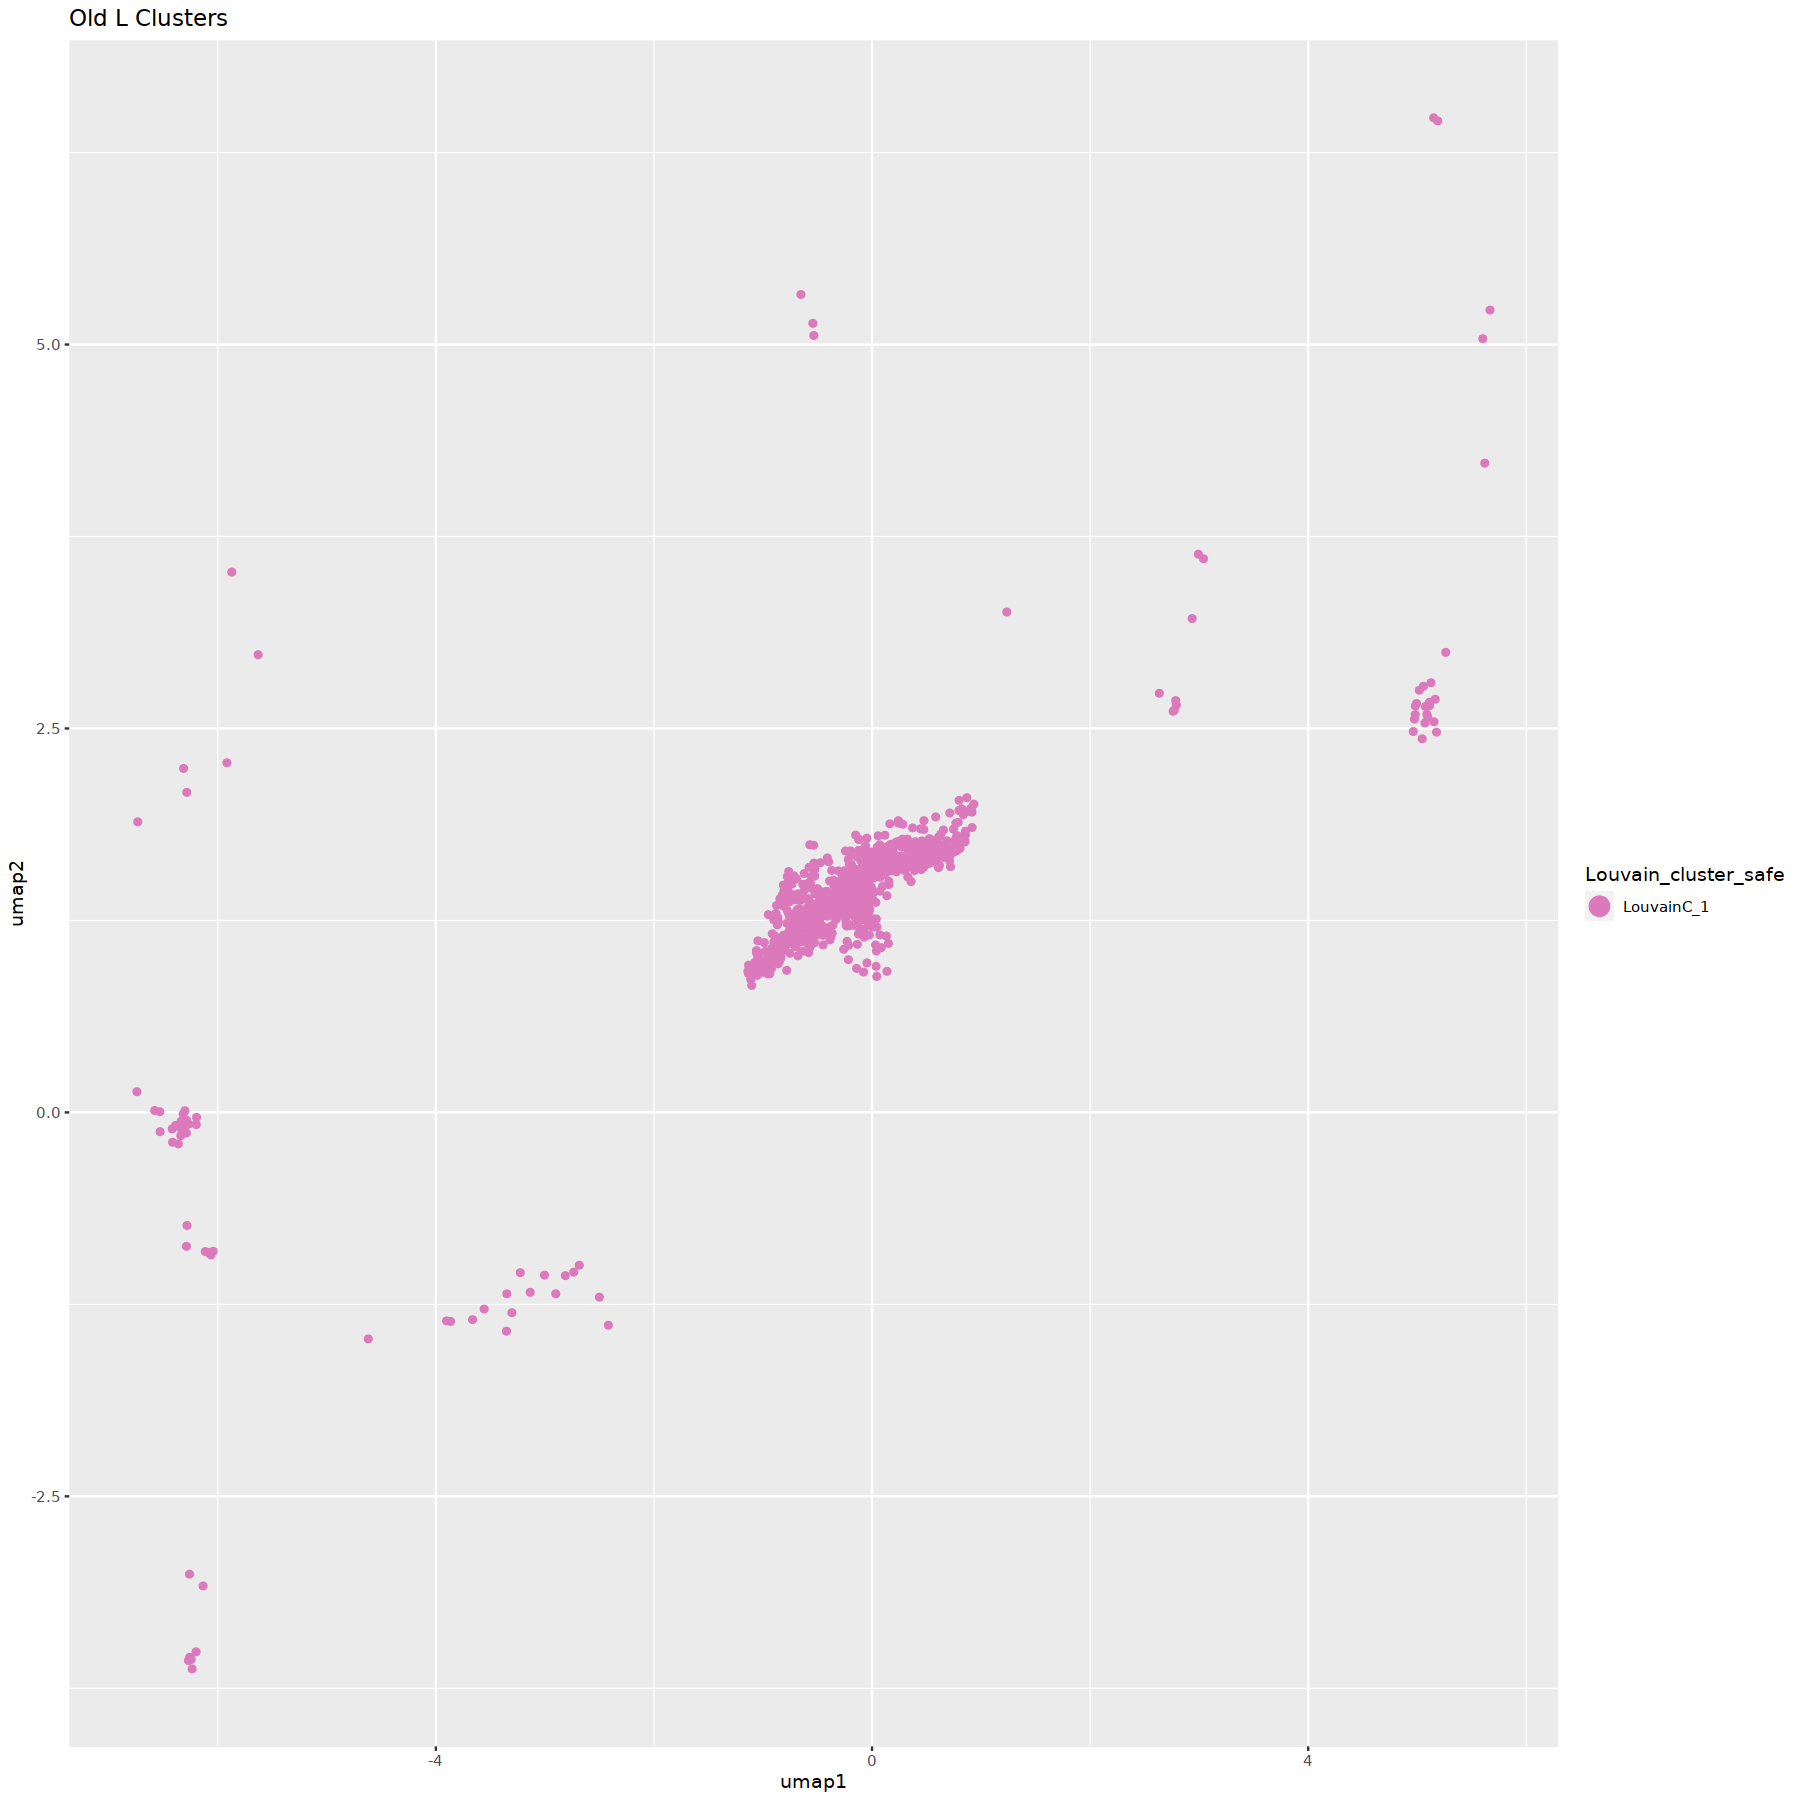

In [12]:
library(cowplot)
library(randomcoloR)
options(repr.plot.width=15, repr.plot.height=15)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)


Sb.subcluster.LC1 <- Sb.subcluster

clusters <- c("LouvainC_1")

#c("LouvainC_18","LouvainC_5","LouvainC_7","LouvainC_32",
#  "LouvainC_24","LouvainC_21","LouvainC_8","LouvainC_20","LouvainC_23")

sb.loaded_socrates_data.LC1$Clusters  %>% 
    dplyr::filter(Louvain_cluster_safe %in% clusters) %>% 
    group_by(Louvain_cluster_safe) %>% 
    ggplot(., aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

chosen_subcluster <- sb.loaded_socrates_data.LC1$Clusters %>% 
    filter(Louvain_cluster_safe %in% clusters)

meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- meta_df$cellID
Sb.subcluster.LC1$meta <- meta_df
Sb.subcluster.LC1$meta.v3 <- meta_df



Sb.subcluster.LC1$acr <- read.table("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/Sb_peak_calls/Sb.peaks/Sb.cluster_peaks.500bp_peaks.bed")

Sb.subcluster.LC1 <- generateMatrix(Sb.subcluster.LC1, 
                                              filtered=FALSE,
                                              peaks = TRUE,
                                              verbose=TRUE)


## Generate Sparse Matrix
Sb.subcluster.LC1 <- convertSparseData(Sb.subcluster.LC1, verbose = TRUE)

In [13]:
# clean sparse counts matrix ---------------------------------------------
Sb.subcluster.LC1 <- cleanData(Sb.subcluster.LC1, 
                     min.t=0.005,  # minimum feature frequency across cells
                     max.t = .05,
                     verbose=T)


   * Input: cells = 940 | peaks = 80004

   * Filtered: cells = 905 | peaks = 63125



In [14]:
# normalize with TFIDF ---------------------------------------------------
Sb.subcluster.LC1.tfidf <- tfidf(Sb.subcluster.LC1)

# project with NMF -------------------------------------------------------
Sb.subcluster.LC1.tfidf <- reduceDims(Sb.subcluster.LC1.tfidf,
                      method="SVD", 
                      n.pcs=30, 
                      svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

16:11:14 UMAP embedding parameters a = 1.577 b = 0.8951

16:11:14 Read 905 rows and found 30 numeric columns

16:11:14 Using Annoy for neighbor search, n_neighbors = 30

16:11:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:11:14 Writing NN index file to temp file /tmp/RtmptBN8Oh/file2760a29f9640

16:11:14 Searching Annoy index using 16 threads, search_k = 3000

16:11:14 Annoy recall = 100%

16:11:24 Commencing smooth kNN distance calibration using 16 threads

16:11:31 Initializing from normalized Laplacian + noise

16:11:31 Commencing optimization for 500 epochs, with 45616 positive edges

16:11:38 Optimization finished



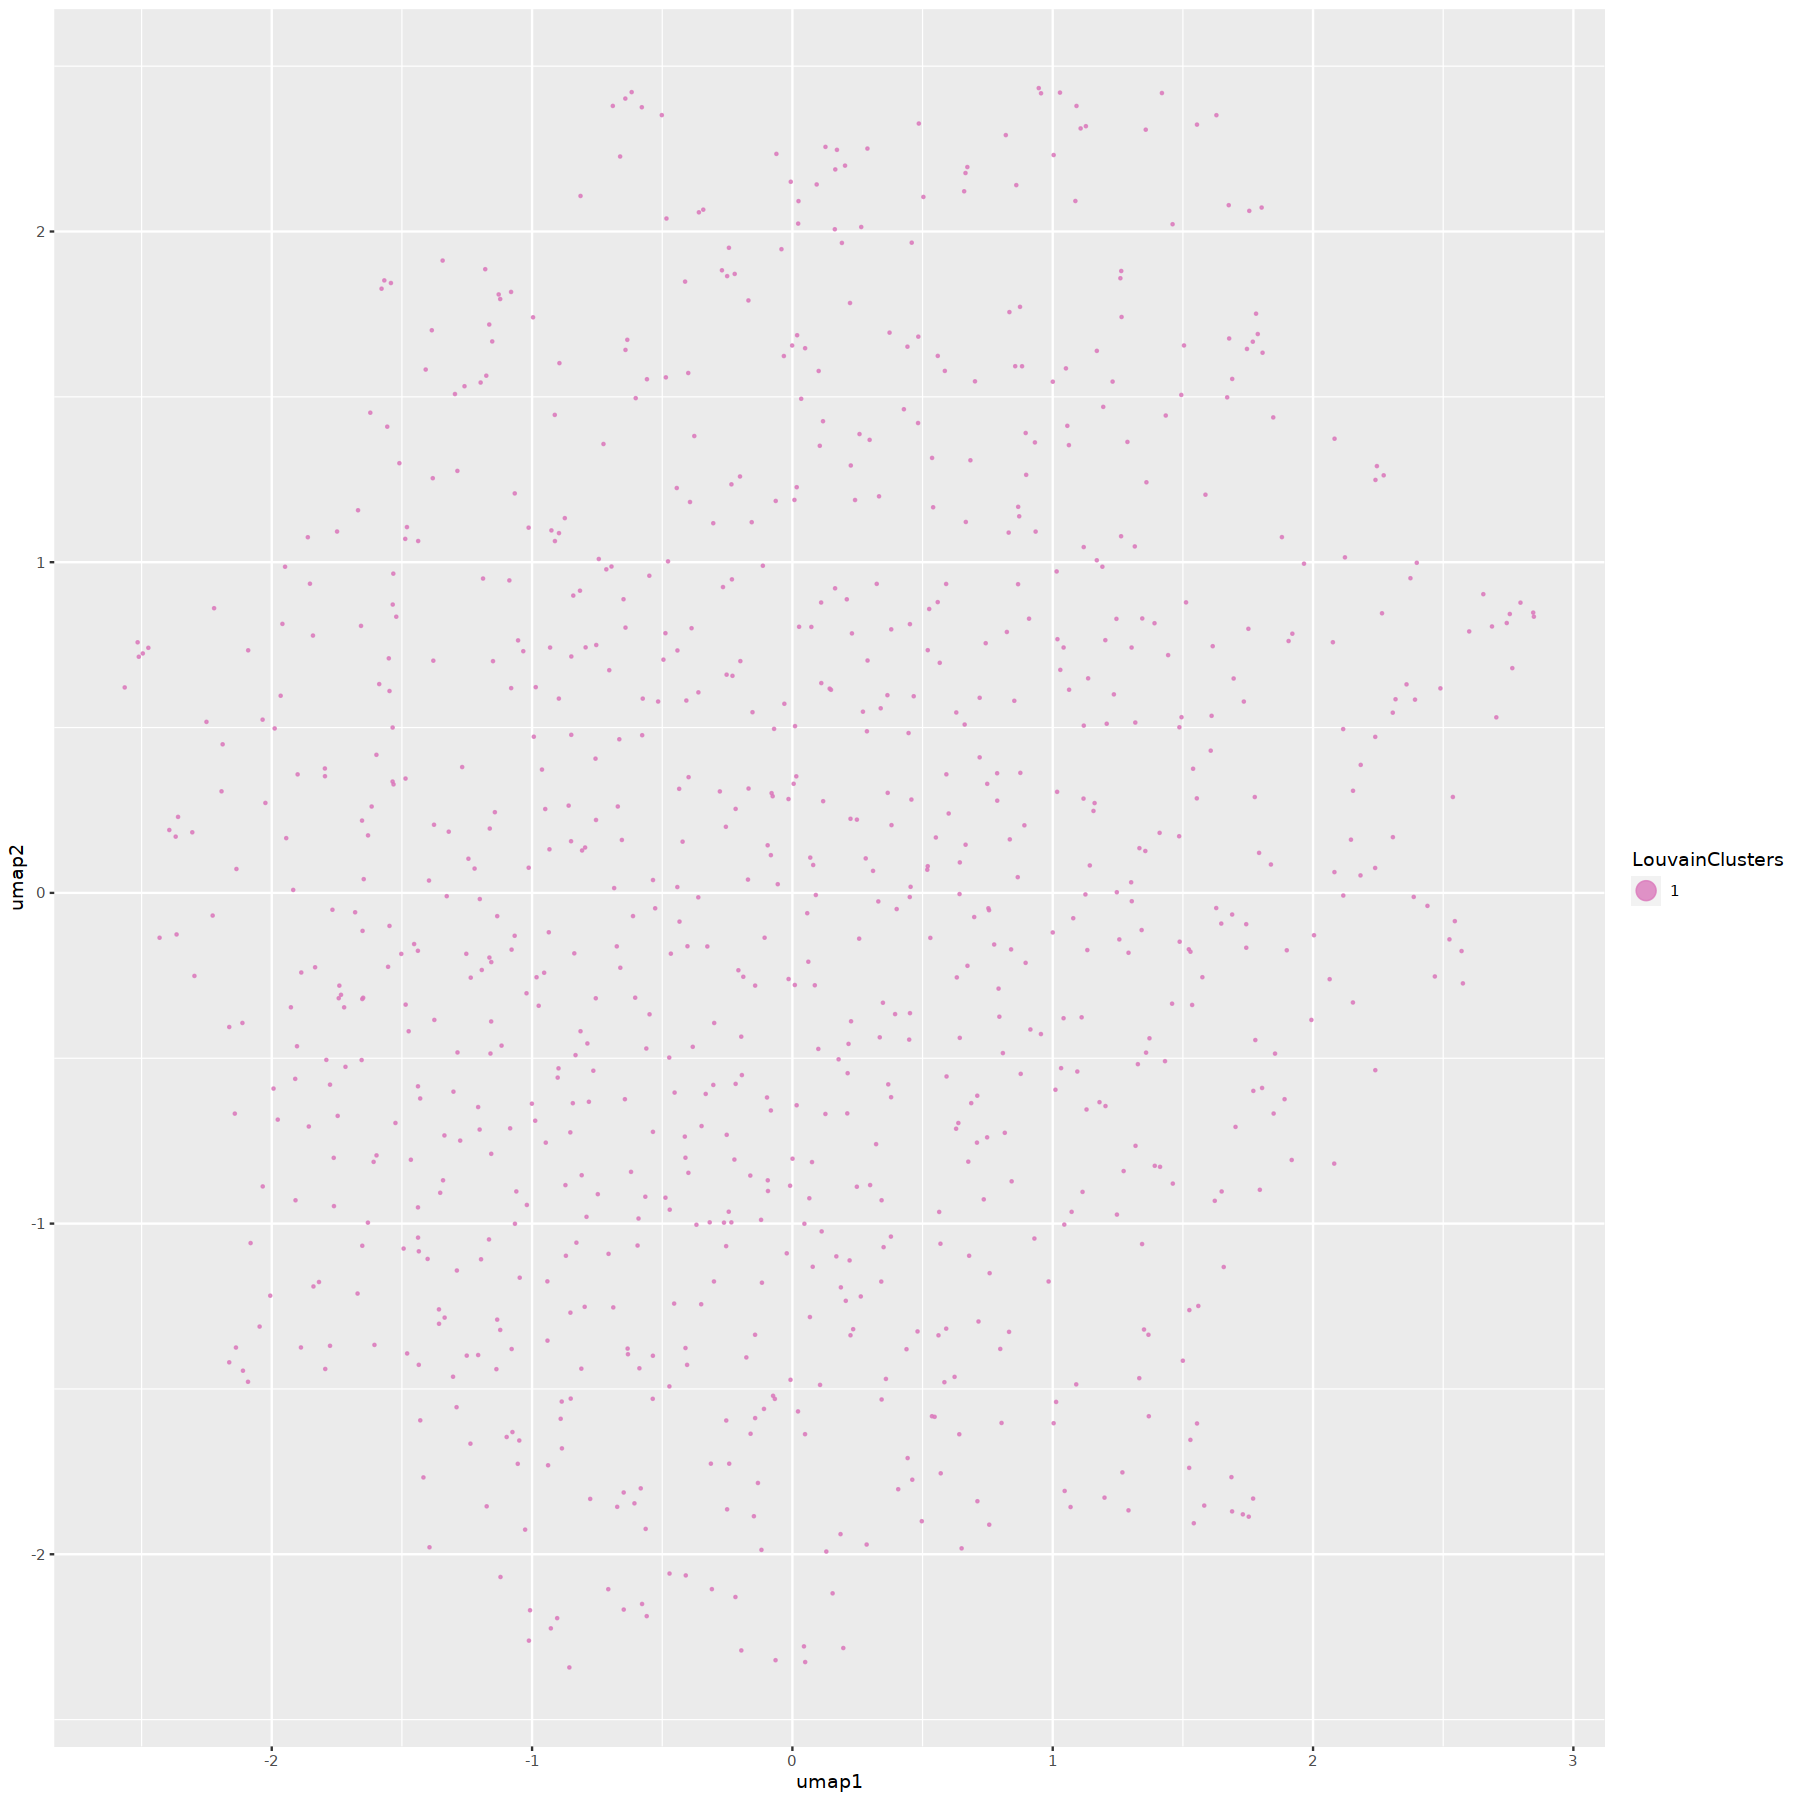

In [15]:
# reduce to 2-dimensions with UMAP ---------------------------------------
Sb.subcluster.LC1.tfidf <- projectUMAP(Sb.subcluster.LC1.tfidf, 
                       verbose=T,
                       k.near=30,
                       m.dist=0.1,
                       svd_slotName="SVD")


ggplot(Sb.subcluster.LC1.tfidf$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

In [20]:
# identify clusters using neighborhood graph -----------------------------
Sb.subcluster.LC1.tfidf.cluster <- callClusters(Sb.subcluster.LC1.tfidf, 
                        res=2,
                        k.near = 30,
                        #min.reads=1000,
                        verbose=T,
                                                min.reads=20,
                        m.clst=5,
                        e.thresh = 20,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
                        cleanCluster=FALSE)


 - filtering outliers in UMAP manifold (z-score e.thresh = 20) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 905
Number of edges: 95311

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.0406
Number of communities: 137
Elapsed time: 3 seconds


78 singletons identified. 59 final clusters.

 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



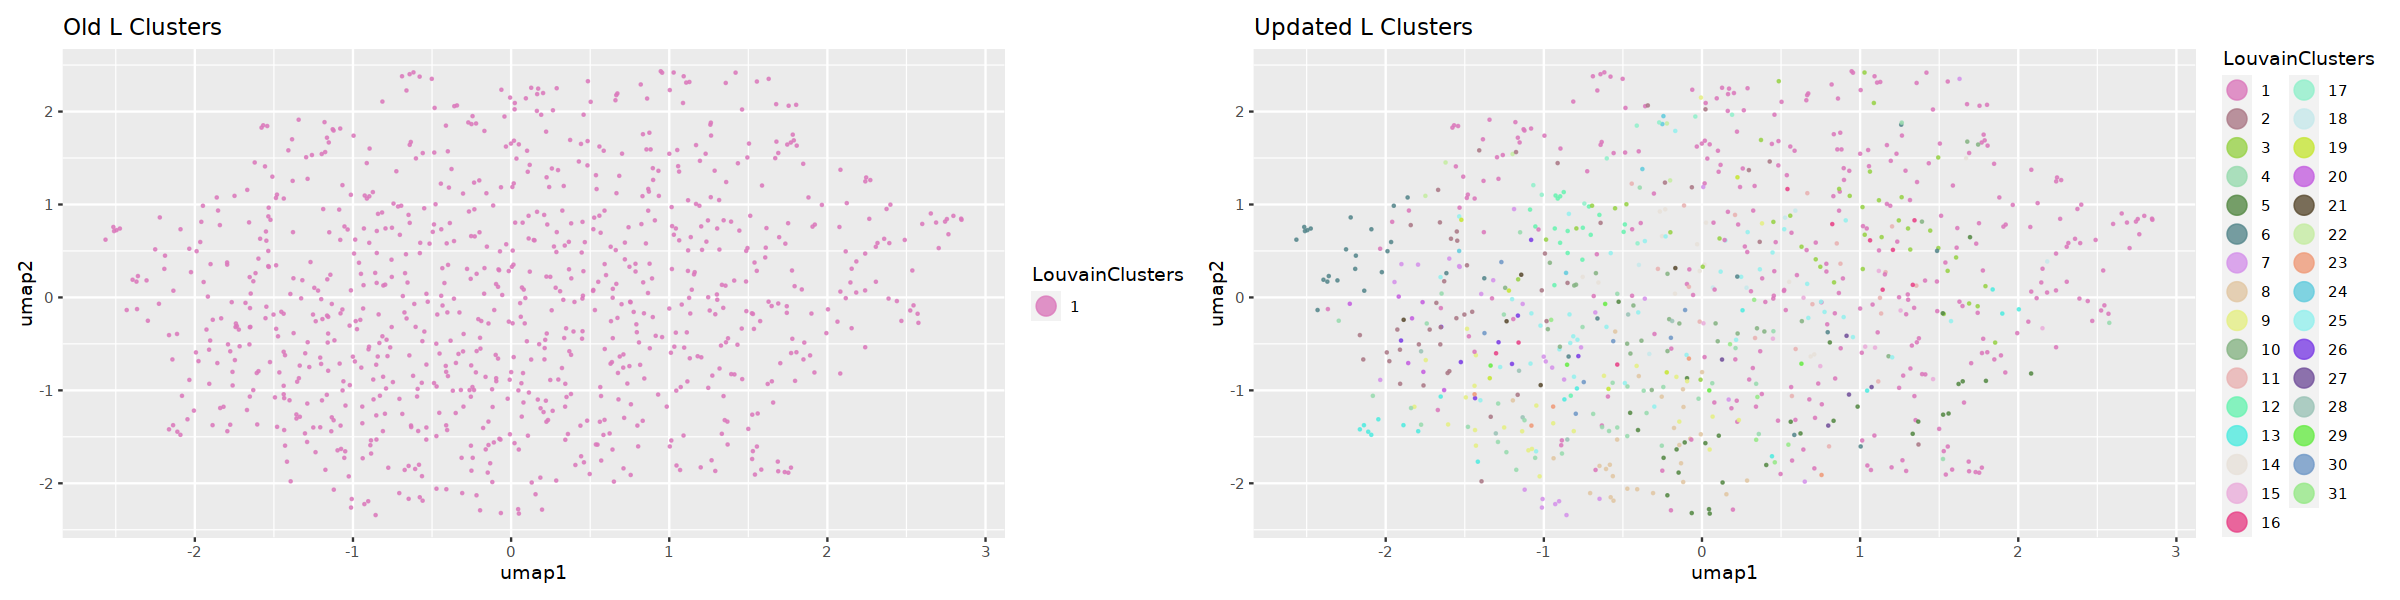

In [21]:
options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(Sb.subcluster.LC1.tfidf.cluster$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(Sb.subcluster.LC1.tfidf.cluster$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")


old_clusters + new_clusters 

# Reclustering sieve elements

 - converting triplet format to sparseMatrix



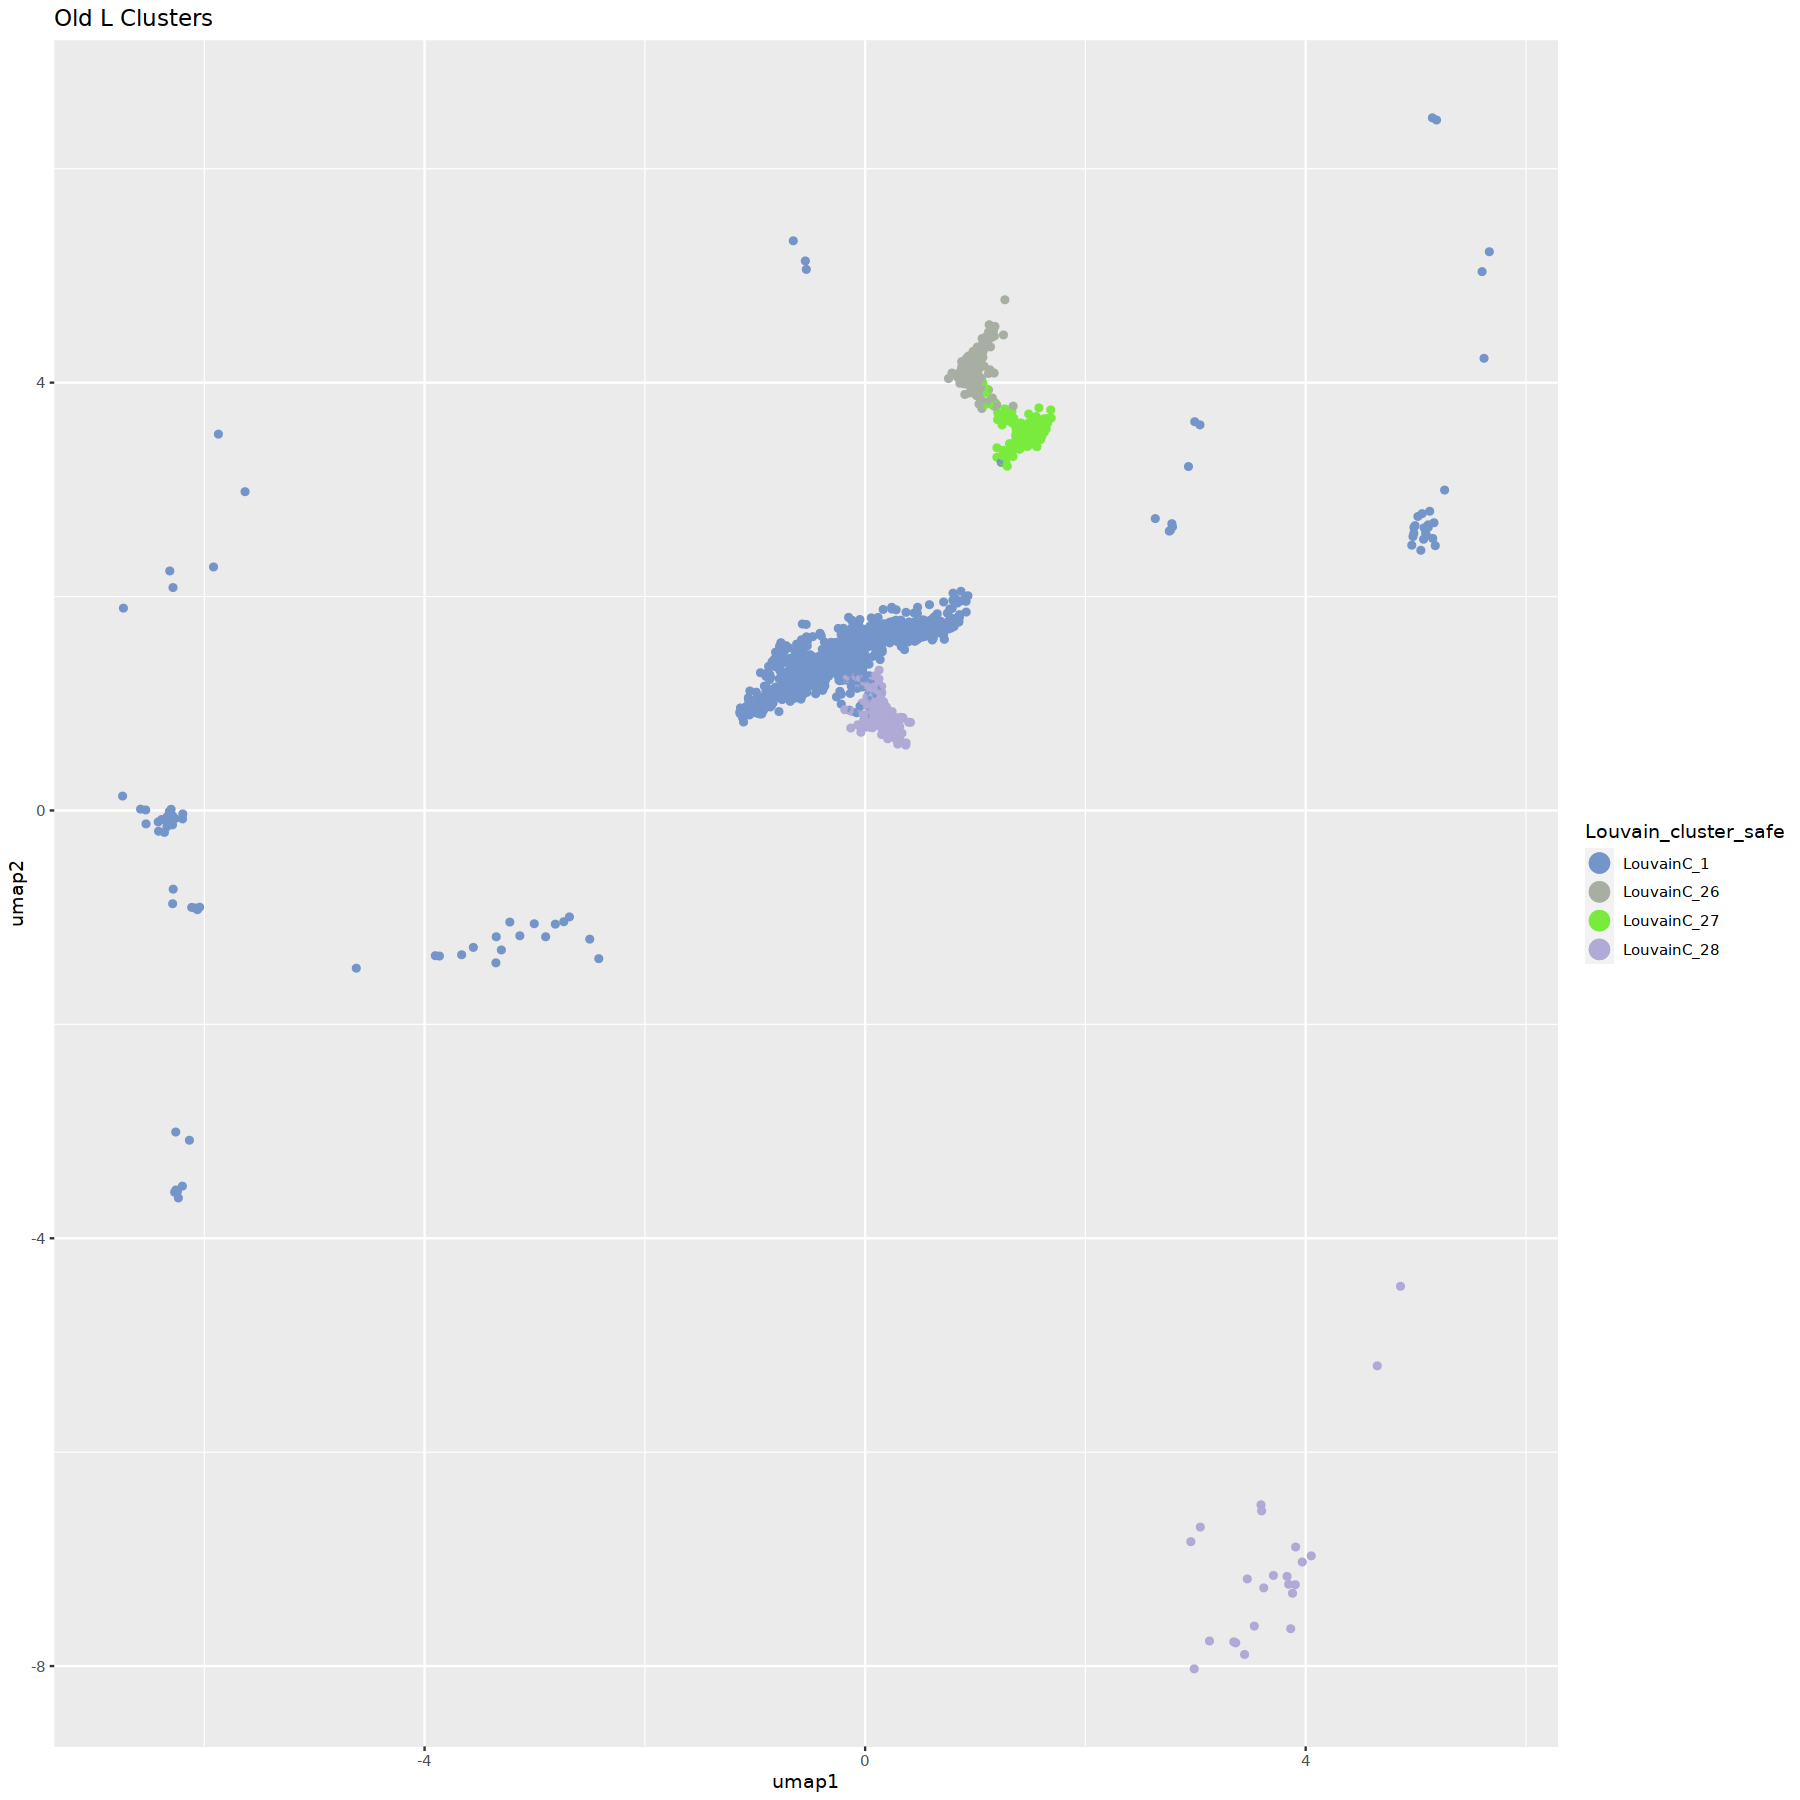

In [28]:
# Re-clustering sievee elements and companion cells

sb.loaded_socrates_data.LC1 <- loaded_socrates_data
cleaned_cluster_meta <- sb.loaded_socrates_data.LC1$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))
    
sb.loaded_socrates_data.LC1$Clusters <- cleaned_cluster_meta

library(cowplot)
library(randomcoloR)
options(repr.plot.width=15, repr.plot.height=15)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)


Sb.subcluster.LC1 <- Sb.subcluster

clusters <- c("LouvainC_26", "LouvainC_27", "LouvainC_28", "LouvainC_1")

#c("LouvainC_18","LouvainC_5","LouvainC_7","LouvainC_32",
#  "LouvainC_24","LouvainC_21","LouvainC_8","LouvainC_20","LouvainC_23")

sb.loaded_socrates_data.LC1$Clusters  %>% 
    dplyr::filter(Louvain_cluster_safe %in% clusters) %>% 
    group_by(Louvain_cluster_safe) %>% 
    ggplot(., aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

chosen_subcluster <- sb.loaded_socrates_data.LC1$Clusters %>% 
    filter(Louvain_cluster_safe %in% clusters)

meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- meta_df$cellID
Sb.subcluster.LC1$meta <- meta_df
Sb.subcluster.LC1$meta.v3 <- meta_df



Sb.subcluster.LC1$acr <- read.table("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/Sb_peak_calls/Sb.peaks/Sb.cluster_peaks.500bp_peaks.bed")

Sb.subcluster.LC1 <- generateMatrix(Sb.subcluster.LC1, 
                                              filtered=FALSE,
                                              peaks = TRUE,
                                              verbose=TRUE)


## Generate Sparse Matrix
Sb.subcluster.LC1 <- convertSparseData(Sb.subcluster.LC1, verbose = TRUE)

In [38]:
# clean sparse counts matrix ---------------------------------------------
Sb.subcluster.LC1.clean <- cleanData(Sb.subcluster.LC1, 
                     min.t=0.001,  # minimum feature frequency across cells
                     max.t =.001,
                     verbose=T)

   * Input: cells = 1703 | peaks = 80004

   * Filtered: cells = 1698 | peaks = 79235



 - non-linear dimensionality reduction with UMAP ...

13:24:20 UMAP embedding parameters a = 1.577 b = 0.8951

13:24:20 Read 1703 rows and found 30 numeric columns

13:24:20 Using Annoy for neighbor search, n_neighbors = 30

13:24:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:24:21 Writing NN index file to temp file /tmp/RtmpNM2R3f/file38e4025ff5843

13:24:21 Searching Annoy index using 16 threads, search_k = 3000

13:24:21 Annoy recall = 100%

13:24:24 Commencing smooth kNN distance calibration using 16 threads

13:24:27 Initializing from normalized Laplacian + noise

13:24:27 Commencing optimization for 500 epochs, with 88402 positive edges

13:24:37 Optimization finished



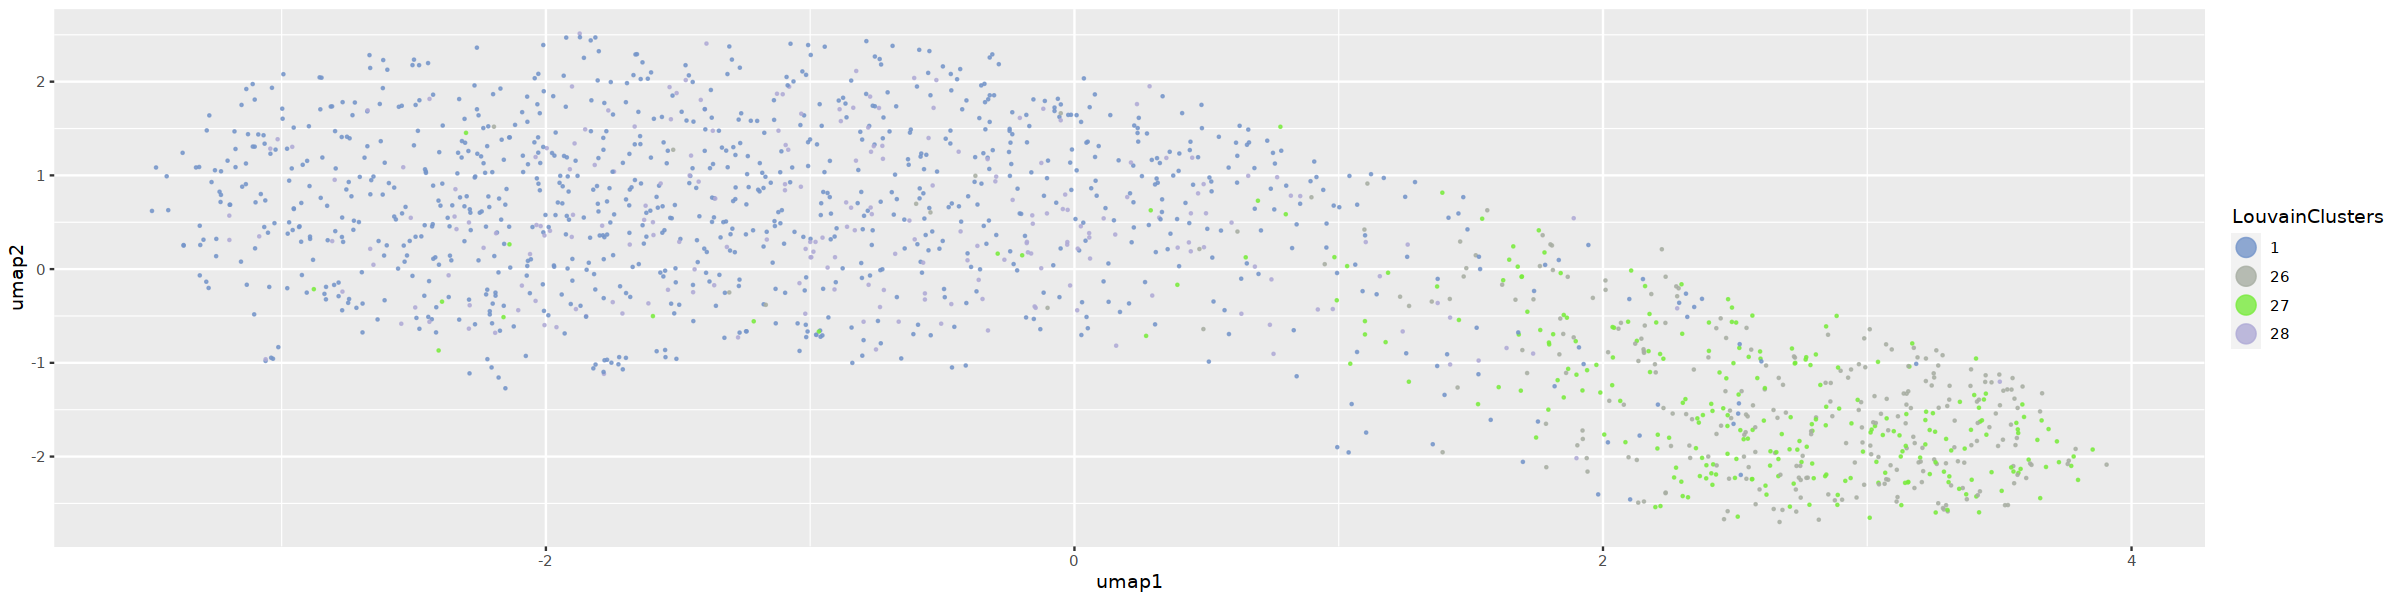

In [39]:
# normalize with TFIDF ---------------------------------------------------
Sb.subcluster.LC1.tfidf <- tfidf(Sb.subcluster.LC1)

# project with NMF -------------------------------------------------------
Sb.subcluster.LC1.tfidf <- reduceDims(Sb.subcluster.LC1.tfidf,
                      method="SVD", 
                      n.pcs=30, 
                      svd_slotName="SVD")

# reduce to 2-dimensions with UMAP ---------------------------------------
Sb.subcluster.LC1.tfidf <- projectUMAP(Sb.subcluster.LC1.tfidf, 
                       verbose=T,
                       k.near=30,
                       m.dist=0.1,
                       svd_slotName="SVD")


ggplot(Sb.subcluster.LC1.tfidf$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1680
Number of edges: 193741

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.2145
Number of communities: 7
Elapsed time: 3 seconds


 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



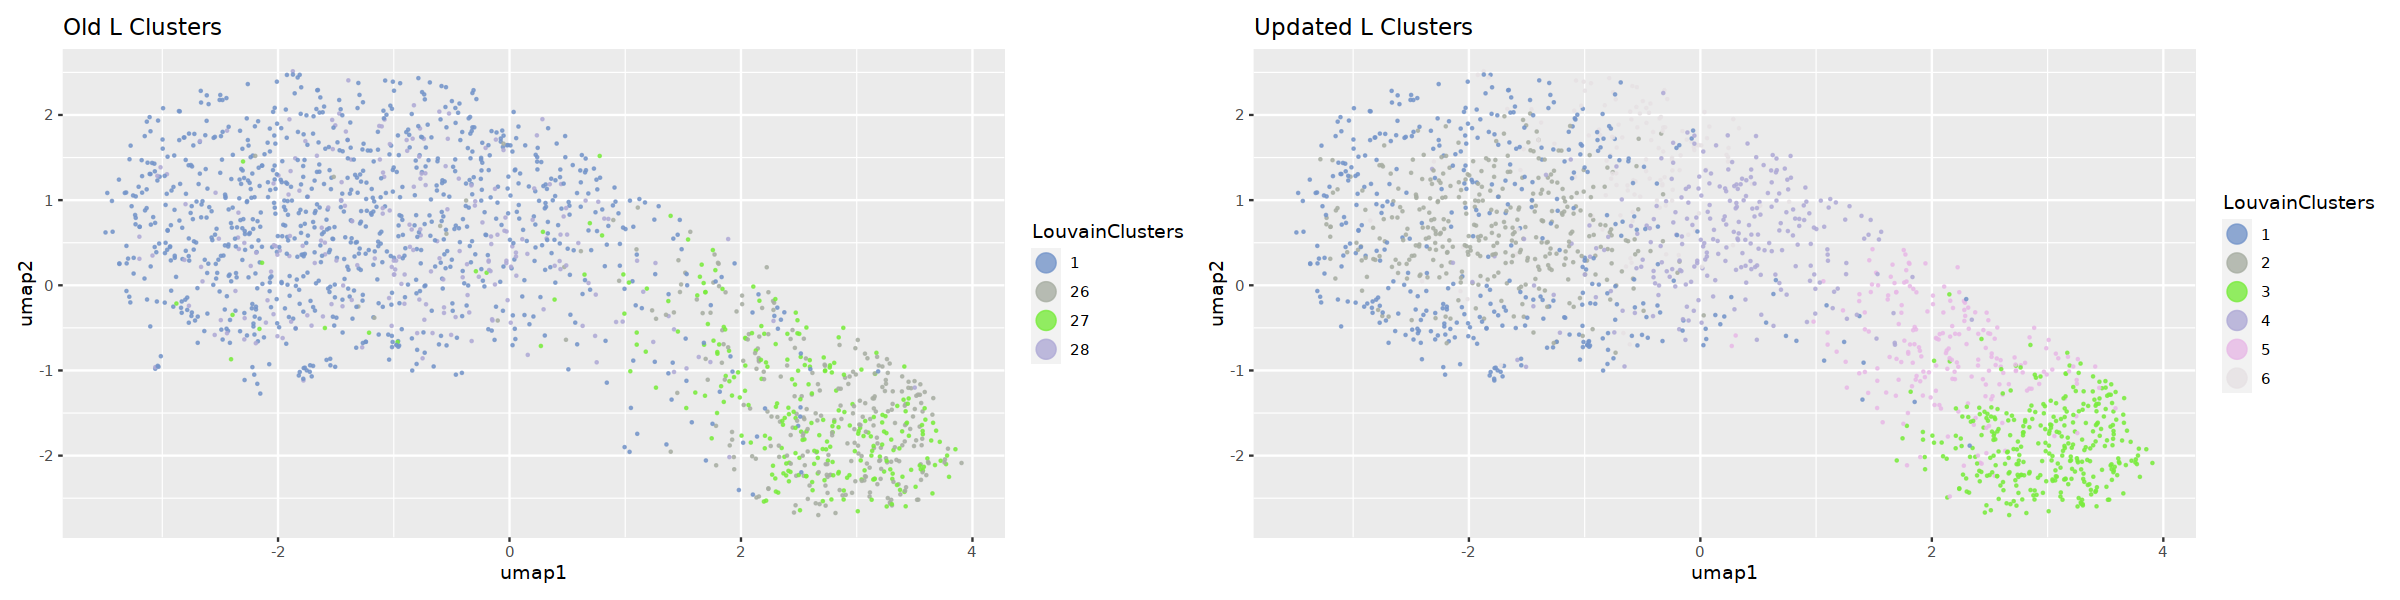

In [40]:
# identify clusters using neighborhood graph -----------------------------
Sb.subcluster.LC1.tfidf.cluster <- callClusters(Sb.subcluster.LC1.tfidf, 
                        res=2,
                        k.near = 30,
                        min.reads=10,
                        verbose=T,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
                        cleanCluster=FALSE)


options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(Sb.subcluster.LC1.tfidf.cluster$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(Sb.subcluster.LC1.tfidf.cluster$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")


old_clusters + new_clusters 

In [42]:
### Kernal Corrupted to just linked to the previosly run gene body accessability calculations
Sb.subcluster.companion_cells.tfidf.cluster.cluster <- Sb.subcluster.LC1.tfidf.cluster
Sb.subcluster.companion_cells.tfidf.cluster.cluster$acr_counts_raw <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.gene_counts.output"
## Execute Annotation Attempt #1

library(presto)
Sb.subcluster.companion_cells.tfidf.cluster.cluster <- run_presto(Sb.subcluster.companion_cells.tfidf.cluster.cluster,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")



grabbed_top_marker_per_cluster <- top_markers(Sb.subcluster.companion_cells.tfidf.cluster.cluster$presto_marker, 200)

represented_marker_lst <- list()
for (i in unique(Sb.subcluster.companion_cells.tfidf.cluster.cluster$sub_cluster$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
    marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

# A tibble: 6 × 14
  cellID      total    tss   acrs  ptmt nSites log10nSites sampleID  umap1 umap2
  <chr>       <dbl>  <dbl>  <dbl> <dbl>  <dbl>       <dbl> <chr>     <dbl> <dbl>
1 BC:Z:GCCA… 193716 115473 154235     0  30754        4.49 rep1      0.519 0.830
2 BC:Z:CGAT… 159908  50092  29336     0  15761        4.20 rep1     -2.24  0.615
3 BC:Z:TTAG…  97214  55597  66879     0  19633        4.29 rep1      0.854 0.697
4 BC:Z:ACAG…  85372  44652  47133     0  16224        4.21 rep1      0.394 1.05 
5 BC:Z:ACAG…  76967  29710  25436     0  11680        4.07 rep1     -0.580 1.23 
6 BC:Z:ACAG…  62553  24175  15366     0   8289        3.92 rep1     -2.23  0.453
# … with 4 more variables: doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, Louvain_cluster_safe <chr>
# A tibble: 6 × 3
  gene_name        barcode                                         accessability
  <chr>            <chr>                                                   <dbl>
1 Sobic.001G125600 BC:Z:ACAGTGCTTGTATG

$`4`
# A tibble: 4 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     5 Sobic.002G207900              Chr02 61233338 61239219 gl1   epid… axill…
2    23 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
3   147 Sobic.004G062500              Chr04  5115447  5120789 bm5   vasc… axill…
4   198 Sorbiv5.1_pg14938.valid.m7.g  Chr03  8560607  8567782 ocl1  prot… axill…

$`2`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

$`6`
# A tibble: 5 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     5 Sobic.002G207900              Chr02 61233338 61239219 gl1   epid… axill…
2   131 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
3   141 Sorbiv5.1_pg18563.valid.m1.g  Chr07  6900132  6906079 ocl5  prot… axill…
4   145 Sobic.001G157400              Chr01 12875142 12881054 ZmHB… pith… axill…
5   173 Sorbiv5.1_pg7967.valid.m15.g  Chr06 58346770 58354051 pdf2  prot… axill…

$`5`
# A tibble: 1 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1    61 Sobic.001G537300 Chr01 84195608 84203525 rld1  SAM,leaf_primordi… axill…

$`3`
# A tibble: 4 × 8
   rank geneID                       chr      start      end name   type  tissue
  <int> <chr>                        <chr>    <dbl>    <dbl> <chr>  <chr> <chr> 
1    41 Sobic.001G488700             Chr01 80047831 80054246 sut1_… comp… axill…
2    56 Sorbiv5.1_pg26238.m1.g       Chr02 19991876 19997282 hp2    prot… axill…
3   114 Sorbiv5.1_pg26255.valid.m1.g Chr02 13930257 13934220 acl5   xylem axill…
4   173 Sorbiv5.1_pg1793.valid.m1.g  Chr01 13056142 13064330 bhlh43 bund… axill…

$`1`
# A tibble: 0 × 8
# … with 8 variables: rank <int>, geneID <chr>, chr <chr>, start <dbl>,
#   end <dbl>, name <chr>, type <chr>, tissue <chr>

## Testing bin SIze


In [76]:
sb.loaded_socrates_data.mesophyll <- loaded_socrates_data
cleaned_cluster_meta <- sb.loaded_socrates_data.mesophyll$Clusters  %>% 
        group_by(LouvainClusters)  %>% 
        mutate(Louvain_cluster_safe = str_c("LouvainC_", LouvainClusters))
    
sb.loaded_socrates_data.mesophyll$Clusters <- cleaned_cluster_meta

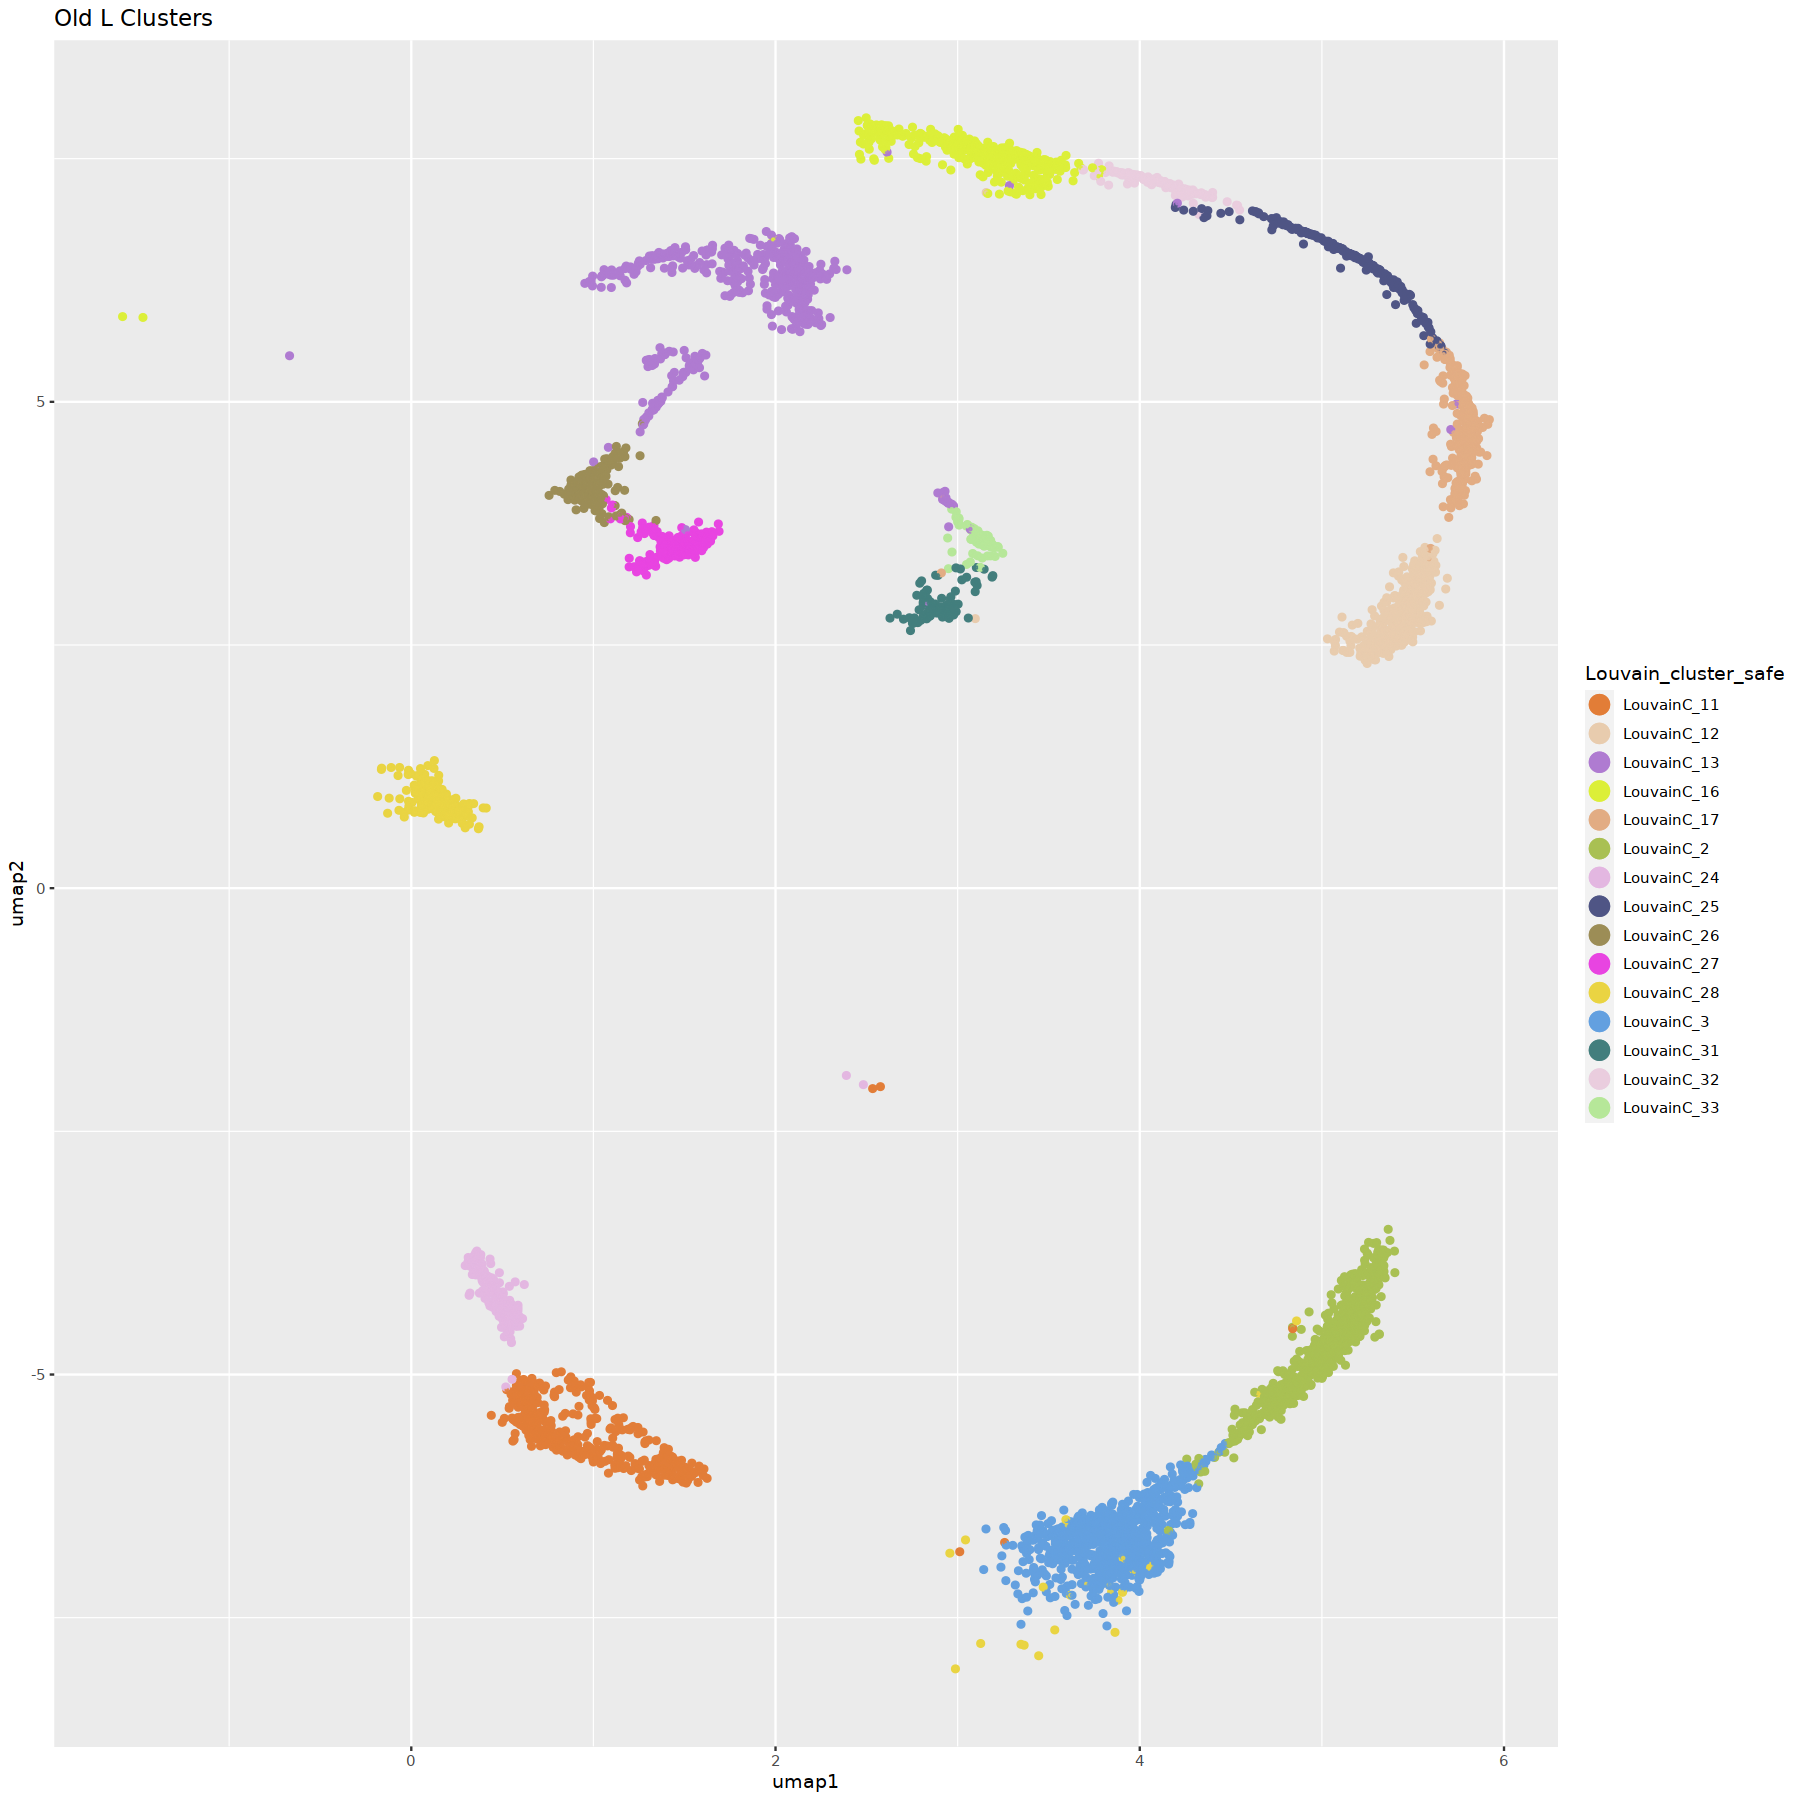

In [77]:
library(cowplot)
library(randomcoloR)
options(repr.plot.width=15, repr.plot.height=15)
other <- randomcoloR::distinctColorPalette(k = 55)
other <- sample(other)


Sb.subcluster.mesophyll <- Sb.subcluster
clusters <- c("LouvainC_16","LouvainC_32","LouvainC_25","LouvainC_17","LouvainC_12","LouvainC_3",
              "LouvainC_24", "LouvainC_13","LouvainC_33","LouvainC_31","LouvainC_2","LouvainC_11","LouvainC_28",
              "LouvainC_25","LouvainC_26","LouvainC_27","LouvainC_31")

#c("LouvainC_18","LouvainC_5","LouvainC_7","LouvainC_32",
#  "LouvainC_24","LouvainC_21","LouvainC_8","LouvainC_20","LouvainC_23")

sb.loaded_socrates_data.mesophyll$Clusters  %>% 
    dplyr::filter(Louvain_cluster_safe %in% clusters) %>% 
    group_by(Louvain_cluster_safe) %>% 
    ggplot(., aes(umap1, umap2, color = Louvain_cluster_safe)) + geom_point() +
 scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Old L Clusters")

chosen_subcluster <- sb.loaded_socrates_data.mesophyll$Clusters %>% 
    filter(Louvain_cluster_safe %in% clusters)

meta_df <- as.data.frame(chosen_subcluster)
rownames(meta_df) <- meta_df$cellID
Sb.subcluster.mesophyll$meta <- meta_df
Sb.subcluster.mesophyll$meta.v3 <- meta_df

In [78]:
Sb.subcluster.mesophyll <- generateMatrix(Sb.subcluster.mesophyll, 
                                              windows = 100,
                                              filtered=FALSE,
                                              peaks = FALSE,
                                              verbose=TRUE)


## Generate Sparse Matrix
Sb.subcluster.mesophyll <- convertSparseData(Sb.subcluster.mesophyll, verbose = TRUE)

 - converting triplet format to sparseMatrix



In [79]:
# clean sparse counts matrix ---------------------------------------------
Sb.subcluster.mesophyll <- cleanData(Sb.subcluster.mesophyll, 
                     min.t=0.02,  # minimum feature frequency across cells
                     max.t = .01,
                     verbose=T)


   * Input: cells = 5877 | peaks = 5753555

   * Filtered: cells = 5876 | peaks = 66405



In [82]:
# normalize with TFIDF ---------------------------------------------------
Sb.subcluster.mesophyll.tfidf <- tfidf(Sb.subcluster.mesophyll)

# project with NMF -------------------------------------------------------
Sb.subcluster.mesophyll.tfidf <- reduceDims(Sb.subcluster.mesophyll.tfidf,
                      method="SVD", 
                      n.pcs=30, 
                      svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

13:06:28 UMAP embedding parameters a = 1.896 b = 0.8006

13:06:28 Read 5876 rows and found 29 numeric columns

13:06:28 Using Annoy for neighbor search, n_neighbors = 30

13:06:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:06:28 Writing NN index file to temp file /tmp/RtmpeUqKjE/file86c92070165f

13:06:28 Searching Annoy index using 16 threads, search_k = 3000

13:06:29 Annoy recall = 100%

13:06:31 Commencing smooth kNN distance calibration using 16 threads

13:06:34 Initializing from normalized Laplacian + noise

13:06:34 Commencing optimization for 500 epochs, with 269424 positive edges

13:07:00 Optimization finished



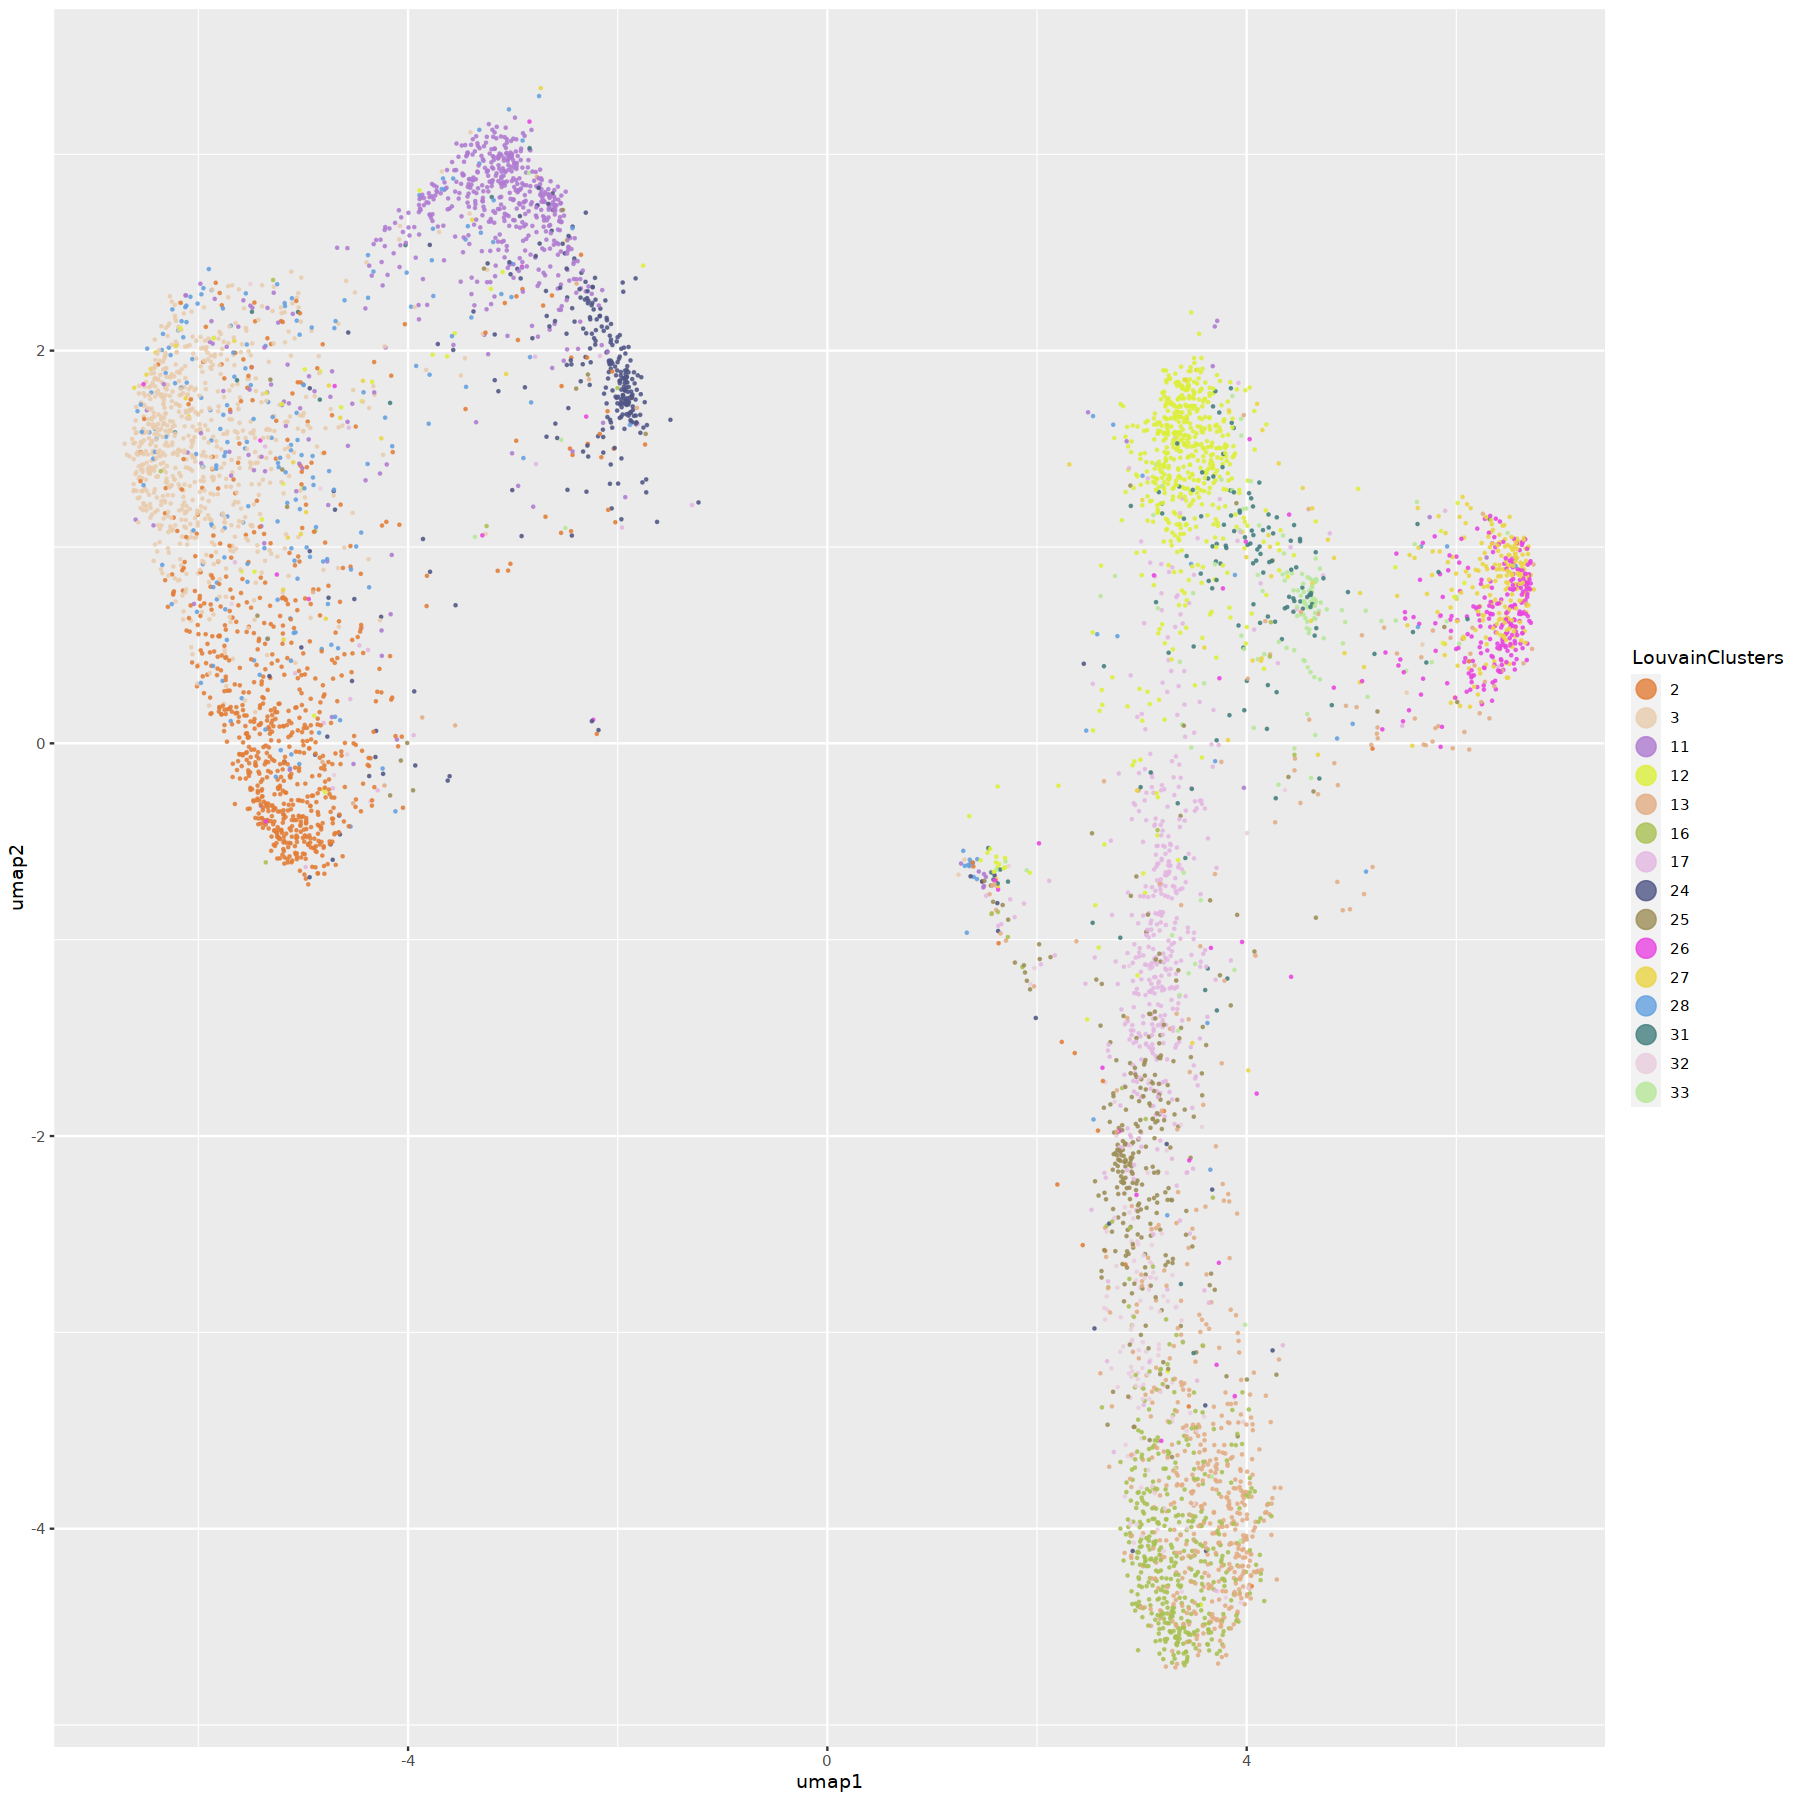

In [83]:
# reduce to 2-dimensions with UMAP ---------------------------------------
Sb.subcluster.mesophyll.tfidf <- projectUMAP(Sb.subcluster.mesophyll.tfidf, 
                       verbose=T,
                       k.near=30,
                       m.dist=0.01,
                       svd_slotName="SVD")


ggplot(Sb.subcluster.mesophyll.tfidf$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)

In [89]:
# identify clusters using neighborhood graph -----------------------------
Sb.subcluster.mesophyll.tfidf.cluster <- callClusters(Sb.subcluster.mesophyll.tfidf, 
                        res=4,
                        k.near = 15,
                        #min.reads=1000,
                        verbose=T,
                        svd_slotName= "SVD",
                        cluster_slotName="sub_cluster",
                        min.reads=1,
                        m.clst=1,
                        e.thresh = 10,
                        cleanCluster=FALSE)


 - filtering outliers in UMAP manifold (z-score e.thresh = 10) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5872
Number of edges: 235693

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.4784
Number of communities: 17
Elapsed time: 13 seconds


 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



In [90]:
str(Sb.subcluster.mesophyll.tfidf.cluster)

List of 11
 $ counts     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:16208730] 0 1 2 4 5 6 10 16 17 21 ...
  .. ..@ p       : int [1:5877] 0 32062 61043 83194 96135 118198 136928 157475 178427 188535 ...
  .. ..@ Dim     : int [1:2] 66405 5876
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:66405] "Chr01_10011401_10011500" "Chr01_10011501_10011600" "Chr01_10011601_10011700" "Chr01_10013401_10013500" ...
  .. .. ..$ : chr [1:5876] "BC:Z:TTAGGCCTTGTAAGCGAGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1" "BC:Z:GCCAATGATCAGCTAAGGTGGCCACTA-Sorghum_leaf.sciATAC_rep1" "BC:Z:TGACCACTTGTAAAACAGTTTCGACCG-Sorghum_leaf.sciATAC_rep1" "BC:Z:ACAGTGCTTGTAAGCGAGTGAAAACCG-Sorghum_leaf.sciATAC_rep1" ...
  .. ..@ x       : num [1:16208730] 1 1 1 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ meta       :'data.frame':	5876 obs. of  14 variables:
  ..$ cellID              : chr [1:5876] "BC:Z:TTAGGCCTTGTAAGCGAGTTTCGTCGG-Sorghum_leaf.sciATAC_rep1" "BC:Z:GCCAATGATCAGCTAAGGTGGCCACT

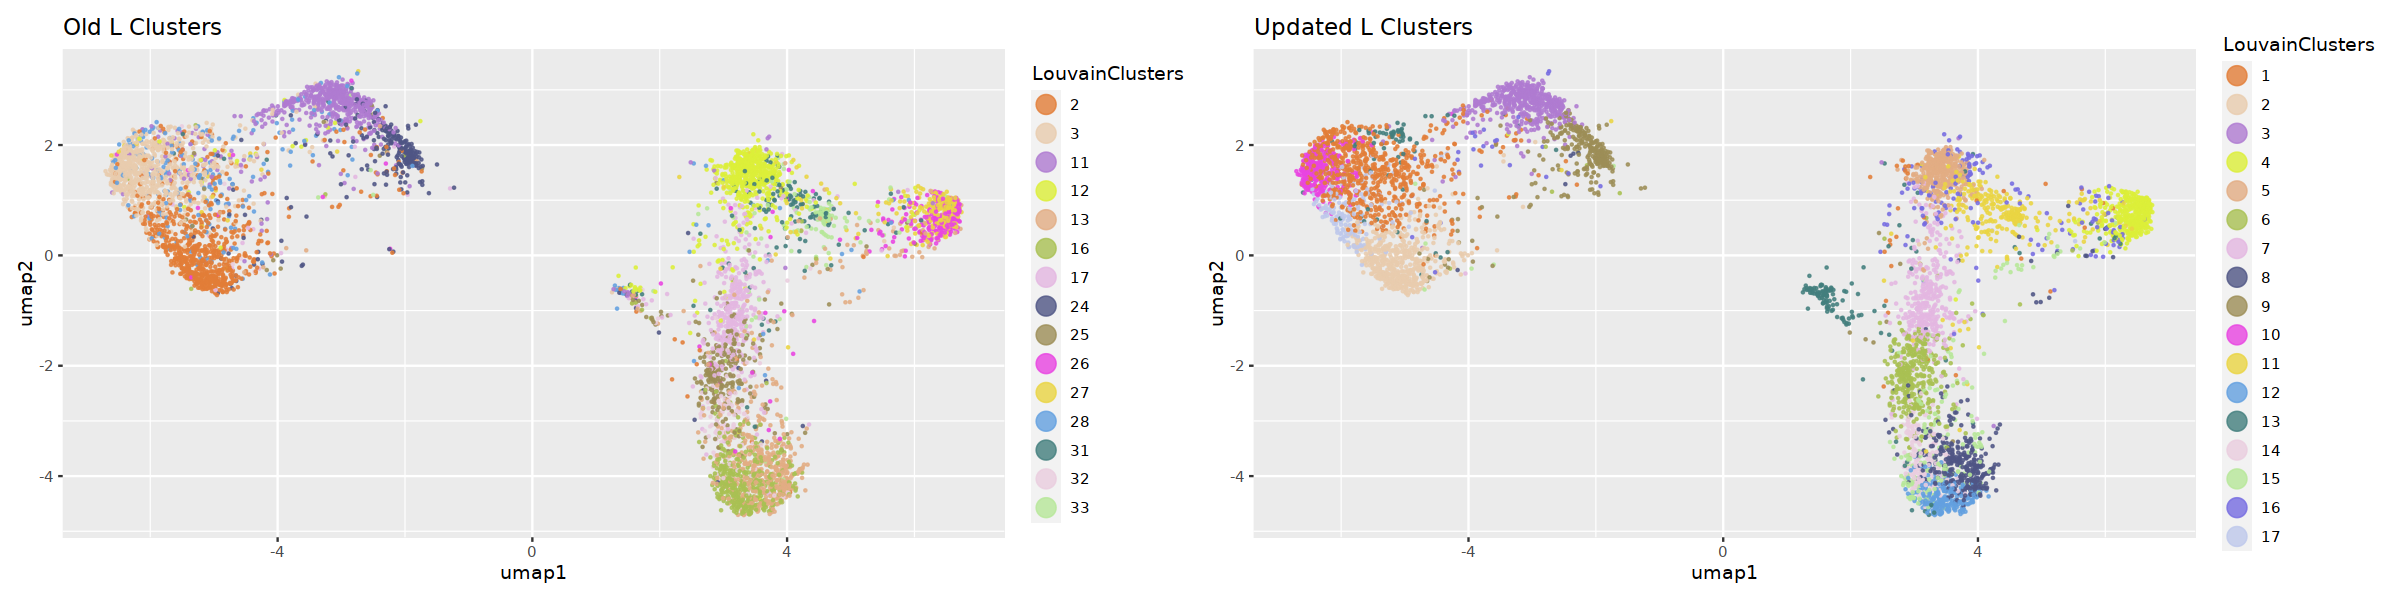

In [91]:
options(repr.plot.width=20, repr.plot.height=5)

old_clusters <- ggplot(Sb.subcluster.mesophyll.tfidf.cluster$meta, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8)+ ggtitle("Old L Clusters")

new_clusters <- ggplot(Sb.subcluster.mesophyll.tfidf.cluster$sub_cluster, aes(x=umap1, y = umap2, color = LouvainClusters)) +
  scale_colour_manual(values=other)  + guides(colour = guide_legend(override.aes = list(size=5))) + 
 geom_point(size = .25, alpha = .8) + ggtitle("Updated L Clusters")


old_clusters + new_clusters 

In [92]:
### Kernal Corrupted to just linked to the previosly run gene body accessability calculations
Sb.subcluster.mesophyll.tfidf.cluster.cluster <- Sb.subcluster.mesophyll.tfidf.cluster
Sb.subcluster.mesophyll.tfidf.cluster.cluster$acr_counts_raw <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/clustering/Sb.gene_counts.output"
## Execute Annotation Attempt #1

library(presto)
Sb.subcluster.mesophyll.tfidf.cluster.cluster <- run_presto(Sb.subcluster.mesophyll.tfidf.cluster.cluster,
           meta_slot = "sub_cluster",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

# A tibble: 6 × 14
  cellID        total   tss  acrs  ptmt nSites log10nSites sampleID umap1  umap2
  <chr>         <dbl> <dbl> <dbl> <dbl>  <dbl>       <dbl> <chr>    <dbl>  <dbl>
1 BC:Z:TTAGGCC… 88482 54555 72636     0  65230        4.81 rep1     -6.66  1.46 
2 BC:Z:GCCAATG… 83441 49165 67016     0  62340        4.79 rep1      4.71  0.717
3 BC:Z:TGACCAC… 58556 34781 42497     0  46454        4.67 rep1      3.54  1.52 
4 BC:Z:ACAGTGC… 55513 24058 23649     0  48696        4.69 rep1     -5.82  0.381
5 BC:Z:ATCACGA… 55460 32640 43116     0  44723        4.65 rep1      3.20 -0.522
6 BC:Z:TGACCAC… 54543 31146 39663     0  43785        4.64 rep1      3.05 -3.88 
# … with 4 more variables: doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <fct>, Louvain_cluster_safe <chr>
# A tibble: 6 × 3
  gene_name        barcode                                         accessability
  <chr>            <chr>                                                   <dbl>
1 Sobic.001G125600 BC:Z:ACAGTGCTTGTATG

In [93]:
grabbed_top_marker_per_cluster <- top_markers(Sb.subcluster.mesophyll.tfidf.cluster.cluster$presto_marker, 200)

represented_marker_lst <- list()
for (i in unique(Sb.subcluster.mesophyll.tfidf.cluster.cluster$sub_cluster$LouvainClusters)) {
    
    make_set <- setNames("geneID",i) 
    markers_present_in_presto <- left_join(grabbed_top_marker_per_cluster, 
                                           marker_list_sb, by = make_set)  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, i, chr:tissue) %>% 
    dplyr::rename("geneID" = i)
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

$`10`
# A tibble: 3 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     1 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2     2 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
3   137 Sobic.005G042000              Chr05  3935393  3936843 ssu2… bund… axill…

$`11`
# A tibble: 5 × 8
   rank geneID                 chr      start      end name         type  tissue
  <int> <chr>                  <chr>    <dbl>    <dbl> <chr>        <chr> <chr> 
1    13 Sobic.002G083600       Chr02  8962876  8967240 SID1         spik… axill…
2   144 Sobic.001G327900       Chr01 65660828 65664161 shr1         matu… axill…
3   150 Sobic.008G015200       Chr08  1324018  1337760 brk3         subs… axill…
4   182 Sorbiv5.1_pg15531.m1.g Chr03  3341071  3347117 me3_ortho_c… bund… axill…
5   194 Sorbiv5.1_pg26238.m1.g Chr02 19991876 19997282 hp2          prot… axill…

$`5`
# A tibble: 2 × 8
   rank geneID                 chr     start     end name           type  tissue
  <int> <chr>                  <chr>   <dbl>   <dbl> <chr>          <chr> <chr> 
1    16 Sorbiv5.1_pg15531.m1.g Chr03 3341071 3347117 me3_ortho_cou… bund… axill…
2   164 Sobic.005G042000       Chr05 3935393 3936843 ssu2__ssu1     bund… axill…

$`17`
# A tibble: 5 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     1 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
2     4 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
3    33 Sobic.005G042000              Chr05  3935393  3936843 ssu2… bund… axill…
4   110 Sobic.002G207900              Chr02 61233338 61239219 gl1   epid… axill…
5   162 Sobic.001G267100              Chr01 54978216 54983302 ZmLA… proc… axill…

$`7`
# A tibble: 2 × 8
   rank geneID                chr      start      end name  type          tissue
  <int> <chr>                 <chr>    <dbl>    <dbl> <chr> <chr>         <chr> 
1     2 Sorbiv5.1_pg9159.m1.g Chr06 41574374 41588764 ba2   axillary_mer… axill…
2    11 Sobic.007G141200      Chr07 60395810 60403219 ccr1  vascular_scl… axill…

$`14`
# A tibble: 2 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1   126 Sobic.008G112200 Chr08 54920473 54923616 myb46 xylem              axill…
2   151 Sobic.007G211200 Chr07 67406141 67408727 pan1  subsidary_mother_… axill…

$`3`
# A tibble: 4 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1     3 Sorbiv5.1_pg15362.valid.m24.g Chr03 63610236 63623676 cah1  meso… axill…
2     5 Sobic.010G160700              Chr10 48834723 48842334 pepc1 meso… axill…
3   173 Sorbiv5.1_pg14938.valid.m7.g  Chr03  8560607  8567782 ocl1  prot… axill…
4   177 Sobic.008G193300              Chr08 65745228 65750046 sut2  comp… axill…

$`8`
# A tibble: 2 × 8
   rank geneID           chr      start      end name  type               tissue
  <int> <chr>            <chr>    <dbl>    <dbl> <chr> <chr>              <chr> 
1    14 Sobic.002G032500 Chr02  3002965  3011531 pan2  subsidiary_mother… axill…
2   133 Sobic.007G211200 Chr07 67406141 67408727 pan1  subsidary_mother_… axill…

$`4`
# A tibble: 5 × 8
   rank geneID                        chr      start      end name  type  tissue
  <int> <chr>                         <chr>    <dbl>    <dbl> <chr> <chr> <chr> 
1    35 Sorbiv5.1_pg26238.m1.g        Chr02 19991876 19997282 hp2   prot… axill…
2    96 Sobic.001G488700              Chr01 80047831 80054246 sut1… comp… axill…
3    99 Sorbiv5.1_pg1793.valid.m1.g   Chr01 13056142 13064330 bhlh… bund… axill…
4   121 Sorbiv5.1_pg29247.valid.m13.g Chr09 53708860 53